<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-15 19:35:16.856235: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-15 19:35:16.898174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-15 19:35:16.898211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-15 19:35:16.899257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 19:35:16.904825: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-15 19:35:16.905437: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-15 19:35:17.645777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-15 19:35:20.033759: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 94ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

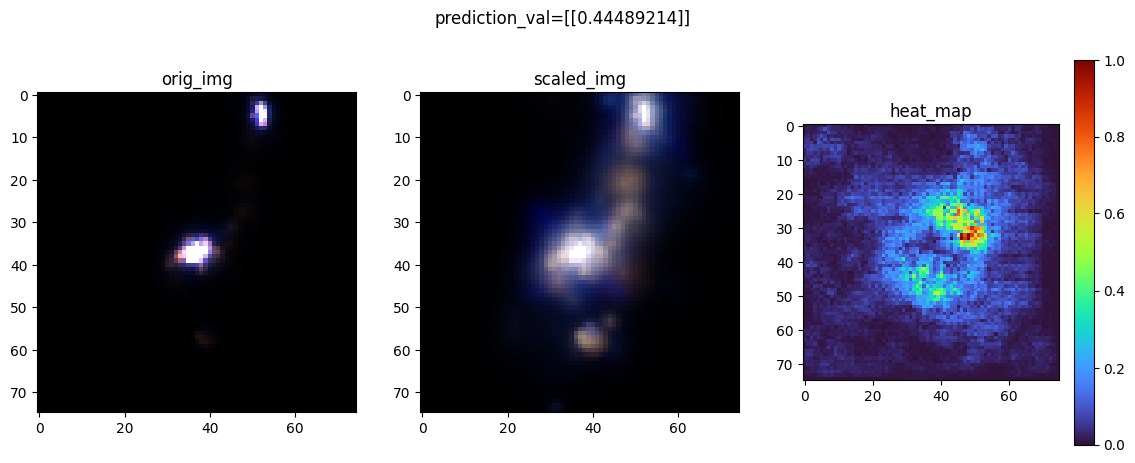

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

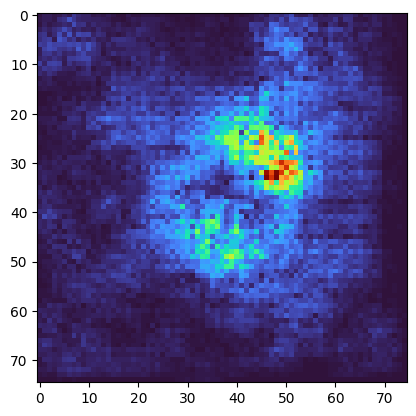

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-15 19:35:23.086712: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-15 19:35:23.925253: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-15 19:35:23.997809: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-15 19:35:24.041750: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-15 19:35:25.533800: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

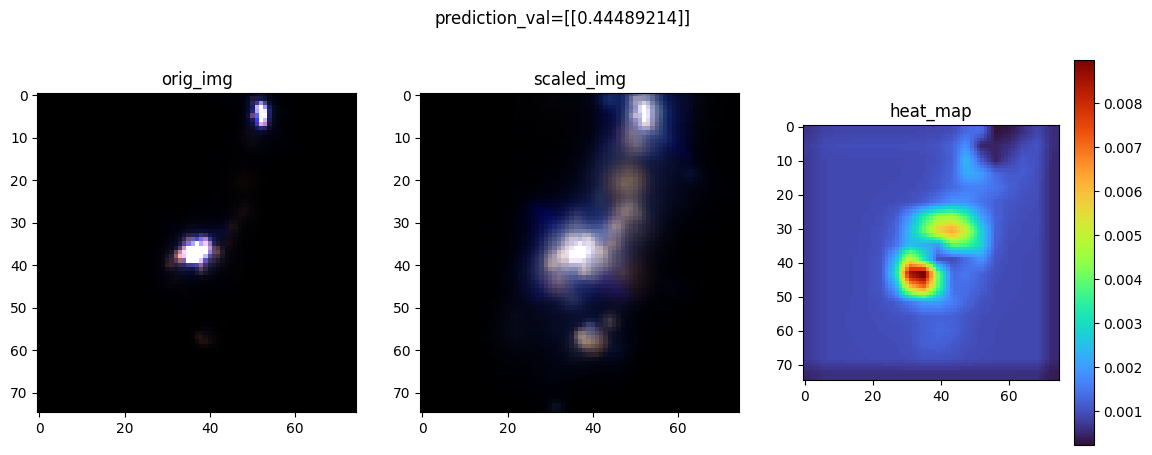

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 4/32 [==>...........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 1s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

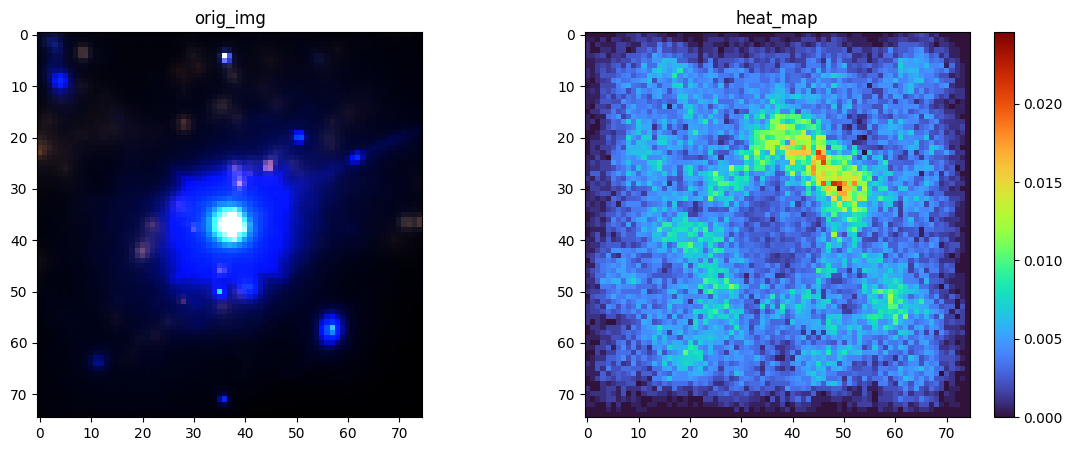

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:18 - loss: 0.7100 - accuracy: 0.5000

  2/338 [..............................] - ETA: 19s - loss: 0.7110 - accuracy: 0.4688 

  3/338 [..............................] - ETA: 19s - loss: 0.7099 - accuracy: 0.5000

  4/338 [..............................] - ETA: 19s - loss: 0.7104 - accuracy: 0.4688

  5/338 [..............................] - ETA: 19s - loss: 0.7100 - accuracy: 0.4688

  6/338 [..............................] - ETA: 19s - loss: 0.7098 - accuracy: 0.4635

  7/338 [..............................] - ETA: 19s - loss: 0.7091 - accuracy: 0.4821

  8/338 [..............................] - ETA: 19s - loss: 0.7086 - accuracy: 0.4883

  9/338 [..............................] - ETA: 19s - loss: 0.7078 - accuracy: 0.5139

 10/338 [..............................] - ETA: 18s - loss: 0.7078 - accuracy: 0.5000

 11/338 [..............................] - ETA: 18s - loss: 0.7076 - accuracy: 0.5000

 12/338 [>.............................] - ETA: 18s - loss: 0.7073 - accuracy: 0.5000

 13/338 [>.............................] - ETA: 18s - loss: 0.7072 - accuracy: 0.4928

 14/338 [>.............................] - ETA: 18s - loss: 0.7066 - accuracy: 0.5067

 15/338 [>.............................] - ETA: 18s - loss: 0.7064 - accuracy: 0.5083

 16/338 [>.............................] - ETA: 18s - loss: 0.7061 - accuracy: 0.5078

 17/338 [>.............................] - ETA: 18s - loss: 0.7060 - accuracy: 0.5037

 18/338 [>.............................] - ETA: 18s - loss: 0.7057 - accuracy: 0.5052

 19/338 [>.............................] - ETA: 18s - loss: 0.7056 - accuracy: 0.5000

 20/338 [>.............................] - ETA: 18s - loss: 0.7054 - accuracy: 0.4984

 21/338 [>.............................] - ETA: 17s - loss: 0.7053 - accuracy: 0.4940

 22/338 [>.............................] - ETA: 17s - loss: 0.7052 - accuracy: 0.4915

 23/338 [=>............................] - ETA: 17s - loss: 0.7049 - accuracy: 0.4932

 24/338 [=>............................] - ETA: 17s - loss: 0.7047 - accuracy: 0.4948

 25/338 [=>............................] - ETA: 17s - loss: 0.7046 - accuracy: 0.4913

 26/338 [=>............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.4964

 27/338 [=>............................] - ETA: 17s - loss: 0.7042 - accuracy: 0.4919

 28/338 [=>............................] - ETA: 17s - loss: 0.7042 - accuracy: 0.4855

 29/338 [=>............................] - ETA: 17s - loss: 0.7040 - accuracy: 0.4860

 30/338 [=>............................] - ETA: 17s - loss: 0.7037 - accuracy: 0.4917

 31/338 [=>............................] - ETA: 17s - loss: 0.7035 - accuracy: 0.4929

 32/338 [=>............................] - ETA: 17s - loss: 0.7034 - accuracy: 0.4922

 33/338 [=>............................] - ETA: 17s - loss: 0.7032 - accuracy: 0.4915

 34/338 [==>...........................] - ETA: 17s - loss: 0.7031 - accuracy: 0.4917

 35/338 [==>...........................] - ETA: 17s - loss: 0.7030 - accuracy: 0.4893

 36/338 [==>...........................] - ETA: 17s - loss: 0.7029 - accuracy: 0.4878

 37/338 [==>...........................] - ETA: 17s - loss: 0.7027 - accuracy: 0.4899

 38/338 [==>...........................] - ETA: 16s - loss: 0.7026 - accuracy: 0.4877

 39/338 [==>...........................] - ETA: 16s - loss: 0.7025 - accuracy: 0.4872

 40/338 [==>...........................] - ETA: 16s - loss: 0.7023 - accuracy: 0.4891

 41/338 [==>...........................] - ETA: 16s - loss: 0.7022 - accuracy: 0.4886

 42/338 [==>...........................] - ETA: 16s - loss: 0.7021 - accuracy: 0.4888

 43/338 [==>...........................] - ETA: 16s - loss: 0.7019 - accuracy: 0.4891

 44/338 [==>...........................] - ETA: 16s - loss: 0.7018 - accuracy: 0.4886

 45/338 [==>...........................] - ETA: 16s - loss: 0.7017 - accuracy: 0.4889

 46/338 [===>..........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.4857

 47/338 [===>..........................] - ETA: 16s - loss: 0.7015 - accuracy: 0.4834

 48/338 [===>..........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.4798

 49/338 [===>..........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.4802

 50/338 [===>..........................] - ETA: 16s - loss: 0.7012 - accuracy: 0.4831

 51/338 [===>..........................] - ETA: 16s - loss: 0.7011 - accuracy: 0.4847

 52/338 [===>..........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.4886

 53/338 [===>..........................] - ETA: 16s - loss: 0.7009 - accuracy: 0.4894

 54/338 [===>..........................] - ETA: 16s - loss: 0.7009 - accuracy: 0.4907

 55/338 [===>..........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.4926

 56/338 [===>..........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.4955

 57/338 [====>.........................] - ETA: 15s - loss: 0.7006 - accuracy: 0.4962

 58/338 [====>.........................] - ETA: 15s - loss: 0.7005 - accuracy: 0.4973

 59/338 [====>.........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.4974

 60/338 [====>.........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.4969

 61/338 [====>.........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.4995

 62/338 [====>.........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.4985

 63/338 [====>.........................] - ETA: 15s - loss: 0.7001 - accuracy: 0.5010

 64/338 [====>.........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.5024

 65/338 [====>.........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.5029

 66/338 [====>.........................] - ETA: 15s - loss: 0.6999 - accuracy: 0.5066

 67/338 [====>.........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5051

 68/338 [=====>........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5041

 69/338 [=====>........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.5059

 70/338 [=====>........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.5071

 71/338 [=====>........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.5066

 72/338 [=====>........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5048

 73/338 [=====>........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.5056

 74/338 [=====>........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5072

 75/338 [=====>........................] - ETA: 14s - loss: 0.6993 - accuracy: 0.5083

 76/338 [=====>........................] - ETA: 14s - loss: 0.6993 - accuracy: 0.5090

 77/338 [=====>........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.5122

 78/338 [=====>........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.5124

 79/338 [======>.......................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5119

 80/338 [======>.......................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5117

 81/338 [======>.......................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5139

 82/338 [======>.......................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5118

 83/338 [======>.......................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5109

 84/338 [======>.......................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5115

 85/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5114

 86/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5113

 87/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5111

 88/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5107

 89/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5098

 90/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5118

 91/338 [=======>......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5117

 92/338 [=======>......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5126

 93/338 [=======>......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5151

 94/338 [=======>......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5140

 95/338 [=======>......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5138

 96/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5130

 97/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5135

 98/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5124

 99/338 [=======>......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5133

100/338 [=======>......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5128

101/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5133

102/338 [========>.....................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5135

103/338 [========>.....................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5127

104/338 [========>.....................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5117

105/338 [========>.....................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5119

106/338 [========>.....................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5121

107/338 [========>.....................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5137

108/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5133

109/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5135

110/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5145

111/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5146

112/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5151

113/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5160

114/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5170

115/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5168

116/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5156

117/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5166

118/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5172

119/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5165

120/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5172

121/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5168

122/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5161

123/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5158

124/338 [==========>...................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5156

125/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5153

126/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5134

127/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5145

128/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5142

129/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5143

130/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5135

131/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5141

132/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5142

133/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5134

134/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5149

135/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5150

136/338 [===========>..................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5156

137/338 [===========>..................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5151

138/338 [===========>..................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5159

139/338 [===========>..................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5148

140/338 [===========>..................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5141

141/338 [===========>..................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5140

142/338 [===========>..................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5141

143/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5140

144/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5145

145/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5157

146/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5154

147/338 [============>.................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5149

148/338 [============>.................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5150

149/338 [============>.................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5151

150/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5150

151/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5145

152/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5142

153/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5135

154/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5132

155/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5131

156/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5130

157/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5141

158/338 [=============>................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5150

159/338 [=============>................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5147

160/338 [=============>................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5143

161/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5155 

162/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5152

163/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5153

164/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5154

165/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5144

166/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5145

167/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5144

168/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5147

169/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5146

170/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5145

171/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5146

172/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5147

173/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5145

174/338 [==============>...............] - ETA: 9s - loss: 0.6961 - accuracy: 0.5147

175/338 [==============>...............] - ETA: 9s - loss: 0.6961 - accuracy: 0.5154

176/338 [==============>...............] - ETA: 9s - loss: 0.6961 - accuracy: 0.5163

177/338 [==============>...............] - ETA: 9s - loss: 0.6960 - accuracy: 0.5162

178/338 [==============>...............] - ETA: 9s - loss: 0.6960 - accuracy: 0.5167

179/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5169

180/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5170

181/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5176

182/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5179

183/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5172

184/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5178

185/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5184

186/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5190

187/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5185

188/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5185

189/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5187

190/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5174

191/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5172

192/338 [================>.............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5179

193/338 [================>.............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5178

194/338 [================>.............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5187

195/338 [================>.............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5196

196/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5195

197/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5198

198/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5205

199/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5206

200/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5206

201/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5204

202/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5213

203/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5212

204/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5211

205/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5216

206/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5217

207/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5225

208/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5225

209/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5227

210/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5237

211/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5235

212/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5233

213/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5232

214/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5234

215/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5231

216/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5226

217/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5229

218/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5228

219/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5237

220/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5240

221/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5249

222/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5253

223/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5247

224/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5254

225/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5256

226/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5260

227/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5256

228/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5254

229/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5258

230/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5257

231/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5264

232/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5268

233/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5262

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5258

235/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5255

236/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5258

237/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5256

238/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5259

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5262

240/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5260

241/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5259

242/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5258

243/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5257

244/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5259

245/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5259

246/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5265

247/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5269

248/338 [=====================>........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5271

249/338 [=====================>........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5264

250/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5268

251/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5268

252/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5268

253/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5271

254/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5269

255/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5266

256/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5264

257/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5257

258/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5262

259/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5259

260/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5266

261/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5267

262/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5271

263/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5276

264/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5283

265/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5284

266/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5282

267/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5280

268/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5279

269/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5280

270/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5280

271/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5279

272/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5280

273/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5280

274/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5282

275/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5282

276/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5283

277/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5281

278/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5279

279/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5281

280/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5282

281/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5282

282/338 [========================>.....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5280

283/338 [========================>.....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5275

284/338 [========================>.....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5277

285/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5275

286/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5273

287/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5280

288/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5279

289/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5281

290/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5280

291/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5278

292/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5276

293/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5278

294/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5284

295/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5285

296/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5288

297/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5289

298/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5289

299/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5294

300/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5294

301/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5296

302/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5302

303/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5303

304/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5297

305/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5296

306/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5291

307/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5293

308/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5294

309/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5294

310/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5291

311/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5291

312/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5291

313/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5291

314/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5287

315/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5283

316/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5279

317/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5281

318/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5277

319/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5275

320/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5277

321/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5276

322/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5273

323/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5278

324/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5271

325/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5270

326/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5266

327/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5269

328/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5269

329/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5274

330/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5274

331/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5276

332/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5273

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5273

334/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5275

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5273

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5272

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5266

338/338 [==============================] - 22s 62ms/step - loss: 0.6933 - accuracy: 0.5267 - val_loss: 0.6918 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.7007 - accuracy: 0.4688

  2/338 [..............................] - ETA: 18s - loss: 0.6883 - accuracy: 0.5781

  3/338 [..............................] - ETA: 18s - loss: 0.6894 - accuracy: 0.5521

  4/338 [..............................] - ETA: 18s - loss: 0.6899 - accuracy: 0.5391

  5/338 [..............................] - ETA: 18s - loss: 0.6895 - accuracy: 0.5437

  6/338 [..............................] - ETA: 18s - loss: 0.6915 - accuracy: 0.5260

  7/338 [..............................] - ETA: 18s - loss: 0.6904 - accuracy: 0.5402

  8/338 [..............................] - ETA: 18s - loss: 0.6909 - accuracy: 0.5312

  9/338 [..............................] - ETA: 18s - loss: 0.6899 - accuracy: 0.5382

 10/338 [..............................] - ETA: 18s - loss: 0.6902 - accuracy: 0.5344

 11/338 [..............................] - ETA: 18s - loss: 0.6897 - accuracy: 0.5398

 12/338 [>.............................] - ETA: 18s - loss: 0.6903 - accuracy: 0.5339

 13/338 [>.............................] - ETA: 18s - loss: 0.6890 - accuracy: 0.5457

 14/338 [>.............................] - ETA: 18s - loss: 0.6887 - accuracy: 0.5469

 15/338 [>.............................] - ETA: 18s - loss: 0.6893 - accuracy: 0.5417

 16/338 [>.............................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5371

 17/338 [>.............................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5368

 18/338 [>.............................] - ETA: 18s - loss: 0.6910 - accuracy: 0.5278

 19/338 [>.............................] - ETA: 18s - loss: 0.6909 - accuracy: 0.5280

 20/338 [>.............................] - ETA: 17s - loss: 0.6908 - accuracy: 0.5281

 21/338 [>.............................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5312

 22/338 [>.............................] - ETA: 17s - loss: 0.6899 - accuracy: 0.5341

 23/338 [=>............................] - ETA: 17s - loss: 0.6898 - accuracy: 0.5340

 24/338 [=>............................] - ETA: 17s - loss: 0.6897 - accuracy: 0.5352

 25/338 [=>............................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5325

 26/338 [=>............................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5288

 27/338 [=>............................] - ETA: 17s - loss: 0.6907 - accuracy: 0.5255

 28/338 [=>............................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5234

 29/338 [=>............................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5216

 30/338 [=>............................] - ETA: 17s - loss: 0.6911 - accuracy: 0.5219

 31/338 [=>............................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5202

 32/338 [=>............................] - ETA: 17s - loss: 0.6920 - accuracy: 0.5137

 33/338 [=>............................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5123

 34/338 [==>...........................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5129

 35/338 [==>...........................] - ETA: 17s - loss: 0.6920 - accuracy: 0.5143

 36/338 [==>...........................] - ETA: 17s - loss: 0.6924 - accuracy: 0.5104

 37/338 [==>...........................] - ETA: 17s - loss: 0.6924 - accuracy: 0.5093

 38/338 [==>...........................] - ETA: 17s - loss: 0.6925 - accuracy: 0.5074

 39/338 [==>...........................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5080

 40/338 [==>...........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5086

 41/338 [==>...........................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5069

 42/338 [==>...........................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5097

 43/338 [==>...........................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5073

 44/338 [==>...........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5071

 45/338 [==>...........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5063

 46/338 [===>..........................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5075

 47/338 [===>..........................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5113

 48/338 [===>..........................] - ETA: 16s - loss: 0.6917 - accuracy: 0.5130

 49/338 [===>..........................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5115

 50/338 [===>..........................] - ETA: 16s - loss: 0.6917 - accuracy: 0.5125

 51/338 [===>..........................] - ETA: 16s - loss: 0.6915 - accuracy: 0.5141

 52/338 [===>..........................] - ETA: 16s - loss: 0.6915 - accuracy: 0.5138

 53/338 [===>..........................] - ETA: 16s - loss: 0.6914 - accuracy: 0.5153

 54/338 [===>..........................] - ETA: 16s - loss: 0.6912 - accuracy: 0.5174

 55/338 [===>..........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5159

 56/338 [===>..........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5140

 57/338 [====>.........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5164

 58/338 [====>.........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5162

 59/338 [====>.........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5154

 60/338 [====>.........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5161

 61/338 [====>.........................] - ETA: 15s - loss: 0.6911 - accuracy: 0.5174

 62/338 [====>.........................] - ETA: 15s - loss: 0.6911 - accuracy: 0.5166

 63/338 [====>.........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5149

 64/338 [====>.........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5137

 65/338 [====>.........................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5120

 66/338 [====>.........................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5128

 67/338 [====>.........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5117

 68/338 [=====>........................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5097

 69/338 [=====>........................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5095

 70/338 [=====>........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5121

 71/338 [=====>........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5136

 72/338 [=====>........................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5135

 73/338 [=====>........................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5137

 74/338 [=====>........................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5127

 75/338 [=====>........................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5133

 76/338 [=====>........................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5140

 77/338 [=====>........................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5150

 78/338 [=====>........................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5148

 79/338 [======>.......................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5146

 80/338 [======>.......................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5148

 81/338 [======>.......................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5154

 82/338 [======>.......................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5156

 83/338 [======>.......................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5147

 84/338 [======>.......................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5141

 85/338 [======>.......................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5132

 86/338 [======>.......................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5131

 87/338 [======>.......................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5151

 88/338 [======>.......................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5146

 89/338 [======>.......................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5162

 90/338 [======>.......................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5156

 91/338 [=======>......................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5148

 92/338 [=======>......................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5153

 93/338 [=======>......................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5155

 94/338 [=======>......................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5160

 95/338 [=======>......................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5155

 96/338 [=======>......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5176

 97/338 [=======>......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5168

 98/338 [=======>......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5179

 99/338 [=======>......................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5180

100/338 [=======>......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5175

101/338 [=======>......................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5176

102/338 [========>.....................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5172

103/338 [========>.....................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5173

104/338 [========>.....................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5180

105/338 [========>.....................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5173

106/338 [========>.....................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5180

107/338 [========>.....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5190

108/338 [========>.....................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5191

109/338 [========>.....................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5195

110/338 [========>.....................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5205

111/338 [========>.....................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5206

112/338 [========>.....................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5215

113/338 [=========>....................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5216

114/338 [=========>....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5233

115/338 [=========>....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5236

116/338 [=========>....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5245

117/338 [=========>....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5243

118/338 [=========>....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5241

119/338 [=========>....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5239

120/338 [=========>....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5229

121/338 [=========>....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5230

122/338 [=========>....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5228

123/338 [=========>....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5236

124/338 [==========>...................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5244

125/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5247

126/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5243

127/338 [==========>...................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5231

128/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5239

129/338 [==========>...................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5252

130/338 [==========>...................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5248

131/338 [==========>...................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5255

132/338 [==========>...................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5253

133/338 [==========>...................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5258

134/338 [==========>...................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5273

135/338 [==========>...................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5273

136/338 [===========>..................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5273

137/338 [===========>..................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5285

138/338 [===========>..................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5276

139/338 [===========>..................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5281

140/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5283

141/338 [===========>..................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5277

142/338 [===========>..................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5271

143/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5282

144/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5286

145/338 [===========>..................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5291

146/338 [===========>..................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5291

147/338 [============>.................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5300

148/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5289

149/338 [============>.................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5294

150/338 [============>.................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5302

151/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5308

152/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5308

153/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5308

154/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5304

155/338 [============>.................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5300

156/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5308

157/338 [============>.................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5297

158/338 [=============>................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5299

159/338 [=============>................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5299

160/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5293 

161/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5293

162/338 [=============>................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5295

163/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5288

164/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5288

165/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5286

166/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5296

167/338 [=============>................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5303

168/338 [=============>................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5307

169/338 [==============>...............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5307

170/338 [==============>...............] - ETA: 9s - loss: 0.6885 - accuracy: 0.5311

171/338 [==============>...............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5302

172/338 [==============>...............] - ETA: 9s - loss: 0.6887 - accuracy: 0.5296

173/338 [==============>...............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5302

174/338 [==============>...............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5304

175/338 [==============>...............] - ETA: 9s - loss: 0.6887 - accuracy: 0.5296

176/338 [==============>...............] - ETA: 9s - loss: 0.6887 - accuracy: 0.5298

177/338 [==============>...............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5297

178/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5309

179/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5300

180/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5297

181/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5295

182/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5294

183/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5299

184/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5296

185/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5299

186/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5304

187/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5304

188/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5299

189/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5291

190/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5296

191/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5291

192/338 [================>.............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5295

193/338 [================>.............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5288

194/338 [================>.............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5280

195/338 [================>.............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5280

196/338 [================>.............] - ETA: 7s - loss: 0.6888 - accuracy: 0.5281

197/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5286

198/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5281

199/338 [================>.............] - ETA: 7s - loss: 0.6888 - accuracy: 0.5275

200/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5278

201/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5285

202/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5285

203/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5286

204/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5283

205/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5285

206/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5284

207/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5284

208/338 [=================>............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5290

209/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5287

210/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5281

211/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5287

212/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5289

213/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5285

214/338 [=================>............] - ETA: 6s - loss: 0.6886 - accuracy: 0.5286

215/338 [==================>...........] - ETA: 6s - loss: 0.6885 - accuracy: 0.5294

216/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5305

217/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5310

218/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5312

219/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5315

220/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5312

221/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5311

222/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5314

223/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5317

224/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5321

225/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5319

226/338 [===================>..........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5317

227/338 [===================>..........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5321

228/338 [===================>..........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5321

229/338 [===================>..........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5322

230/338 [===================>..........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5326

231/338 [===================>..........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5326

232/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5327

233/338 [===================>..........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5330

234/338 [===================>..........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5337

235/338 [===================>..........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5339

236/338 [===================>..........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5340

237/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5339

238/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5335

239/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5341

240/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5335

241/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5337

242/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5338

243/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5341

244/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5343

245/338 [====================>.........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5349

246/338 [====================>.........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5353

247/338 [====================>.........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5349

248/338 [=====================>........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5343

249/338 [=====================>........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5345

250/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5345

251/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5345

252/338 [=====================>........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5345

253/338 [=====================>........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5351

254/338 [=====================>........] - ETA: 4s - loss: 0.6874 - accuracy: 0.5354

255/338 [=====================>........] - ETA: 4s - loss: 0.6874 - accuracy: 0.5355

256/338 [=====================>........] - ETA: 4s - loss: 0.6874 - accuracy: 0.5354

257/338 [=====================>........] - ETA: 4s - loss: 0.6874 - accuracy: 0.5354

258/338 [=====================>........] - ETA: 4s - loss: 0.6874 - accuracy: 0.5350

259/338 [=====================>........] - ETA: 4s - loss: 0.6874 - accuracy: 0.5352

260/338 [======================>.......] - ETA: 4s - loss: 0.6875 - accuracy: 0.5347

261/338 [======================>.......] - ETA: 4s - loss: 0.6875 - accuracy: 0.5348

262/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5342

263/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5339

264/338 [======================>.......] - ETA: 4s - loss: 0.6877 - accuracy: 0.5336

265/338 [======================>.......] - ETA: 4s - loss: 0.6877 - accuracy: 0.5335

266/338 [======================>.......] - ETA: 4s - loss: 0.6877 - accuracy: 0.5334

267/338 [======================>.......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5334

268/338 [======================>.......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5329

269/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5322

270/338 [======================>.......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5326

271/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5321

272/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5318

273/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5324

274/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5325

275/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5326

276/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5325

277/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5326

278/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5325

279/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5325

280/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5320

281/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5316

282/338 [========================>.....] - ETA: 3s - loss: 0.6878 - accuracy: 0.5320

283/338 [========================>.....] - ETA: 3s - loss: 0.6878 - accuracy: 0.5316

284/338 [========================>.....] - ETA: 3s - loss: 0.6879 - accuracy: 0.5314

285/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5316

286/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5320

287/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5314

288/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5315

289/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5315

290/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5315

291/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5314

292/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5312

293/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5311

294/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5309

295/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5303

296/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5299

297/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5300

298/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5299

299/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5295

300/338 [=========================>....] - ETA: 2s - loss: 0.6880 - accuracy: 0.5290

301/338 [=========================>....] - ETA: 2s - loss: 0.6880 - accuracy: 0.5293

302/338 [=========================>....] - ETA: 2s - loss: 0.6880 - accuracy: 0.5293

303/338 [=========================>....] - ETA: 1s - loss: 0.6880 - accuracy: 0.5293

304/338 [=========================>....] - ETA: 1s - loss: 0.6880 - accuracy: 0.5291

305/338 [==========================>...] - ETA: 1s - loss: 0.6880 - accuracy: 0.5290

306/338 [==========================>...] - ETA: 1s - loss: 0.6880 - accuracy: 0.5290

307/338 [==========================>...] - ETA: 1s - loss: 0.6880 - accuracy: 0.5291

308/338 [==========================>...] - ETA: 1s - loss: 0.6880 - accuracy: 0.5290

309/338 [==========================>...] - ETA: 1s - loss: 0.6880 - accuracy: 0.5290

310/338 [==========================>...] - ETA: 1s - loss: 0.6880 - accuracy: 0.5289

311/338 [==========================>...] - ETA: 1s - loss: 0.6880 - accuracy: 0.5291

312/338 [==========================>...] - ETA: 1s - loss: 0.6880 - accuracy: 0.5294

313/338 [==========================>...] - ETA: 1s - loss: 0.6880 - accuracy: 0.5294

314/338 [==========================>...] - ETA: 1s - loss: 0.6879 - accuracy: 0.5296

315/338 [==========================>...] - ETA: 1s - loss: 0.6880 - accuracy: 0.5291

316/338 [===========================>..] - ETA: 1s - loss: 0.6880 - accuracy: 0.5290

317/338 [===========================>..] - ETA: 1s - loss: 0.6880 - accuracy: 0.5290

318/338 [===========================>..] - ETA: 1s - loss: 0.6880 - accuracy: 0.5292

319/338 [===========================>..] - ETA: 1s - loss: 0.6880 - accuracy: 0.5287

320/338 [===========================>..] - ETA: 1s - loss: 0.6880 - accuracy: 0.5288

321/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5285

322/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5280

323/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5281

324/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5280

325/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5280

326/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5276

327/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5275

328/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5275

329/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5277

330/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5275

331/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5267

332/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5268

333/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5268

334/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5272

335/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5276

336/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5270

337/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5270

338/338 [==============================] - 21s 61ms/step - loss: 0.6879 - accuracy: 0.5271 - val_loss: 0.6873 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6961 - accuracy: 0.3750

  2/338 [..............................] - ETA: 18s - loss: 0.6851 - accuracy: 0.4844

  3/338 [..............................] - ETA: 18s - loss: 0.6845 - accuracy: 0.5104

  4/338 [..............................] - ETA: 18s - loss: 0.6840 - accuracy: 0.5078

  5/338 [..............................] - ETA: 18s - loss: 0.6853 - accuracy: 0.4875

  6/338 [..............................] - ETA: 18s - loss: 0.6893 - accuracy: 0.4583

  7/338 [..............................] - ETA: 18s - loss: 0.6865 - accuracy: 0.4777

  8/338 [..............................] - ETA: 18s - loss: 0.6856 - accuracy: 0.4844

  9/338 [..............................] - ETA: 18s - loss: 0.6852 - accuracy: 0.4826

 10/338 [..............................] - ETA: 18s - loss: 0.6867 - accuracy: 0.4906

 11/338 [..............................] - ETA: 18s - loss: 0.6866 - accuracy: 0.5057

 12/338 [>.............................] - ETA: 18s - loss: 0.6861 - accuracy: 0.5156

 13/338 [>.............................] - ETA: 18s - loss: 0.6854 - accuracy: 0.5361

 14/338 [>.............................] - ETA: 18s - loss: 0.6864 - accuracy: 0.5379

 15/338 [>.............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5479

 16/338 [>.............................] - ETA: 17s - loss: 0.6853 - accuracy: 0.5547

 17/338 [>.............................] - ETA: 17s - loss: 0.6854 - accuracy: 0.5570

 18/338 [>.............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5538

 19/338 [>.............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5559

 20/338 [>.............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5594

 21/338 [>.............................] - ETA: 17s - loss: 0.6863 - accuracy: 0.5625

 22/338 [>.............................] - ETA: 17s - loss: 0.6858 - accuracy: 0.5668

 23/338 [=>............................] - ETA: 17s - loss: 0.6851 - accuracy: 0.5734

 24/338 [=>............................] - ETA: 17s - loss: 0.6845 - accuracy: 0.5781

 25/338 [=>............................] - ETA: 17s - loss: 0.6842 - accuracy: 0.5788

 26/338 [=>............................] - ETA: 17s - loss: 0.6840 - accuracy: 0.5769

 27/338 [=>............................] - ETA: 17s - loss: 0.6837 - accuracy: 0.5799

 28/338 [=>............................] - ETA: 17s - loss: 0.6834 - accuracy: 0.5837

 29/338 [=>............................] - ETA: 17s - loss: 0.6842 - accuracy: 0.5841

 30/338 [=>............................] - ETA: 17s - loss: 0.6836 - accuracy: 0.5896

 31/338 [=>............................] - ETA: 17s - loss: 0.6838 - accuracy: 0.5887

 32/338 [=>............................] - ETA: 17s - loss: 0.6841 - accuracy: 0.5898

 33/338 [=>............................] - ETA: 17s - loss: 0.6838 - accuracy: 0.5938

 34/338 [==>...........................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5910

 35/338 [==>...........................] - ETA: 16s - loss: 0.6837 - accuracy: 0.5902

 36/338 [==>...........................] - ETA: 16s - loss: 0.6837 - accuracy: 0.5911

 37/338 [==>...........................] - ETA: 16s - loss: 0.6835 - accuracy: 0.5929

 38/338 [==>...........................] - ETA: 16s - loss: 0.6838 - accuracy: 0.5905

 39/338 [==>...........................] - ETA: 16s - loss: 0.6836 - accuracy: 0.5921

 40/338 [==>...........................] - ETA: 16s - loss: 0.6837 - accuracy: 0.5891

 41/338 [==>...........................] - ETA: 16s - loss: 0.6843 - accuracy: 0.5861

 42/338 [==>...........................] - ETA: 16s - loss: 0.6847 - accuracy: 0.5833

 43/338 [==>...........................] - ETA: 16s - loss: 0.6849 - accuracy: 0.5821

 44/338 [==>...........................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5788

 45/338 [==>...........................] - ETA: 16s - loss: 0.6847 - accuracy: 0.5813

 46/338 [===>..........................] - ETA: 16s - loss: 0.6846 - accuracy: 0.5815

 47/338 [===>..........................] - ETA: 16s - loss: 0.6849 - accuracy: 0.5798

 48/338 [===>..........................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5846

 49/338 [===>..........................] - ETA: 16s - loss: 0.6847 - accuracy: 0.5804

 50/338 [===>..........................] - ETA: 16s - loss: 0.6846 - accuracy: 0.5800

 51/338 [===>..........................] - ETA: 16s - loss: 0.6844 - accuracy: 0.5809

 52/338 [===>..........................] - ETA: 16s - loss: 0.6842 - accuracy: 0.5823

 53/338 [===>..........................] - ETA: 16s - loss: 0.6845 - accuracy: 0.5802

 54/338 [===>..........................] - ETA: 15s - loss: 0.6840 - accuracy: 0.5828

 55/338 [===>..........................] - ETA: 15s - loss: 0.6837 - accuracy: 0.5847

 56/338 [===>..........................] - ETA: 15s - loss: 0.6842 - accuracy: 0.5820

 57/338 [====>.........................] - ETA: 15s - loss: 0.6845 - accuracy: 0.5806

 58/338 [====>.........................] - ETA: 15s - loss: 0.6850 - accuracy: 0.5792

 59/338 [====>.........................] - ETA: 15s - loss: 0.6851 - accuracy: 0.5784

 60/338 [====>.........................] - ETA: 15s - loss: 0.6853 - accuracy: 0.5781

 61/338 [====>.........................] - ETA: 15s - loss: 0.6852 - accuracy: 0.5784

 62/338 [====>.........................] - ETA: 15s - loss: 0.6850 - accuracy: 0.5817

 63/338 [====>.........................] - ETA: 15s - loss: 0.6846 - accuracy: 0.5833

 64/338 [====>.........................] - ETA: 15s - loss: 0.6846 - accuracy: 0.5835

 65/338 [====>.........................] - ETA: 15s - loss: 0.6845 - accuracy: 0.5841

 66/338 [====>.........................] - ETA: 15s - loss: 0.6845 - accuracy: 0.5852

 67/338 [====>.........................] - ETA: 15s - loss: 0.6846 - accuracy: 0.5849

 68/338 [=====>........................] - ETA: 15s - loss: 0.6845 - accuracy: 0.5850

 69/338 [=====>........................] - ETA: 15s - loss: 0.6843 - accuracy: 0.5851

 70/338 [=====>........................] - ETA: 15s - loss: 0.6841 - accuracy: 0.5848

 71/338 [=====>........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5867

 72/338 [=====>........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5859

 73/338 [=====>........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5865

 74/338 [=====>........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5874

 75/338 [=====>........................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5863

 76/338 [=====>........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5880

 77/338 [=====>........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5856

 78/338 [=====>........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5861

 79/338 [======>.......................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5878

 80/338 [======>.......................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5871

 81/338 [======>.......................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5868

 82/338 [======>.......................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5896

 83/338 [======>.......................] - ETA: 14s - loss: 0.6835 - accuracy: 0.5907

 84/338 [======>.......................] - ETA: 14s - loss: 0.6834 - accuracy: 0.5904

 85/338 [======>.......................] - ETA: 14s - loss: 0.6832 - accuracy: 0.5923

 86/338 [======>.......................] - ETA: 14s - loss: 0.6834 - accuracy: 0.5912

 87/338 [======>.......................] - ETA: 14s - loss: 0.6834 - accuracy: 0.5898

 88/338 [======>.......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5891

 89/338 [======>.......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5892

 90/338 [======>.......................] - ETA: 13s - loss: 0.6835 - accuracy: 0.5892

 91/338 [=======>......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5903

 92/338 [=======>......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5907

 93/338 [=======>......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5907

 94/338 [=======>......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5914

 95/338 [=======>......................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5921

 96/338 [=======>......................] - ETA: 13s - loss: 0.6832 - accuracy: 0.5931

 97/338 [=======>......................] - ETA: 13s - loss: 0.6830 - accuracy: 0.5947

 98/338 [=======>......................] - ETA: 13s - loss: 0.6828 - accuracy: 0.5963

 99/338 [=======>......................] - ETA: 13s - loss: 0.6828 - accuracy: 0.5960

100/338 [=======>......................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5959

101/338 [=======>......................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5959

102/338 [========>.....................] - ETA: 13s - loss: 0.6828 - accuracy: 0.5959

103/338 [========>.....................] - ETA: 13s - loss: 0.6828 - accuracy: 0.5962

104/338 [========>.....................] - ETA: 13s - loss: 0.6826 - accuracy: 0.5971

105/338 [========>.....................] - ETA: 13s - loss: 0.6824 - accuracy: 0.5985

106/338 [========>.....................] - ETA: 12s - loss: 0.6824 - accuracy: 0.5982

107/338 [========>.....................] - ETA: 12s - loss: 0.6824 - accuracy: 0.5981

108/338 [========>.....................] - ETA: 12s - loss: 0.6826 - accuracy: 0.5969

109/338 [========>.....................] - ETA: 12s - loss: 0.6826 - accuracy: 0.5966

110/338 [========>.....................] - ETA: 12s - loss: 0.6827 - accuracy: 0.5969

111/338 [========>.....................] - ETA: 12s - loss: 0.6827 - accuracy: 0.5963

112/338 [========>.....................] - ETA: 12s - loss: 0.6827 - accuracy: 0.5960

113/338 [=========>....................] - ETA: 12s - loss: 0.6826 - accuracy: 0.5965

114/338 [=========>....................] - ETA: 12s - loss: 0.6825 - accuracy: 0.5973

115/338 [=========>....................] - ETA: 12s - loss: 0.6823 - accuracy: 0.5986

116/338 [=========>....................] - ETA: 12s - loss: 0.6820 - accuracy: 0.6002

117/338 [=========>....................] - ETA: 12s - loss: 0.6819 - accuracy: 0.6007

118/338 [=========>....................] - ETA: 12s - loss: 0.6822 - accuracy: 0.5993

119/338 [=========>....................] - ETA: 12s - loss: 0.6823 - accuracy: 0.5987

120/338 [=========>....................] - ETA: 12s - loss: 0.6819 - accuracy: 0.6005

121/338 [=========>....................] - ETA: 12s - loss: 0.6820 - accuracy: 0.5999

122/338 [=========>....................] - ETA: 12s - loss: 0.6820 - accuracy: 0.6002

123/338 [=========>....................] - ETA: 12s - loss: 0.6818 - accuracy: 0.6006

124/338 [==========>...................] - ETA: 11s - loss: 0.6816 - accuracy: 0.6018

125/338 [==========>...................] - ETA: 11s - loss: 0.6814 - accuracy: 0.6022

126/338 [==========>...................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6019

127/338 [==========>...................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6021

128/338 [==========>...................] - ETA: 11s - loss: 0.6816 - accuracy: 0.6013

129/338 [==========>...................] - ETA: 11s - loss: 0.6817 - accuracy: 0.6010

130/338 [==========>...................] - ETA: 11s - loss: 0.6817 - accuracy: 0.6010

131/338 [==========>...................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6026

132/338 [==========>...................] - ETA: 11s - loss: 0.6813 - accuracy: 0.6037

133/338 [==========>...................] - ETA: 11s - loss: 0.6813 - accuracy: 0.6034

134/338 [==========>...................] - ETA: 11s - loss: 0.6813 - accuracy: 0.6035

135/338 [==========>...................] - ETA: 11s - loss: 0.6810 - accuracy: 0.6046

136/338 [===========>..................] - ETA: 11s - loss: 0.6809 - accuracy: 0.6055

137/338 [===========>..................] - ETA: 11s - loss: 0.6812 - accuracy: 0.6040

138/338 [===========>..................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6051

139/338 [===========>..................] - ETA: 11s - loss: 0.6810 - accuracy: 0.6057

140/338 [===========>..................] - ETA: 11s - loss: 0.6810 - accuracy: 0.6054

141/338 [===========>..................] - ETA: 11s - loss: 0.6810 - accuracy: 0.6055

142/338 [===========>..................] - ETA: 10s - loss: 0.6810 - accuracy: 0.6056

143/338 [===========>..................] - ETA: 10s - loss: 0.6810 - accuracy: 0.6060

144/338 [===========>..................] - ETA: 10s - loss: 0.6809 - accuracy: 0.6070

145/338 [===========>..................] - ETA: 10s - loss: 0.6806 - accuracy: 0.6078

146/338 [===========>..................] - ETA: 10s - loss: 0.6805 - accuracy: 0.6085

147/338 [============>.................] - ETA: 10s - loss: 0.6806 - accuracy: 0.6086

148/338 [============>.................] - ETA: 10s - loss: 0.6804 - accuracy: 0.6096

149/338 [============>.................] - ETA: 10s - loss: 0.6802 - accuracy: 0.6103

150/338 [============>.................] - ETA: 10s - loss: 0.6801 - accuracy: 0.6110

151/338 [============>.................] - ETA: 10s - loss: 0.6802 - accuracy: 0.6107

152/338 [============>.................] - ETA: 10s - loss: 0.6801 - accuracy: 0.6110

153/338 [============>.................] - ETA: 10s - loss: 0.6801 - accuracy: 0.6107

154/338 [============>.................] - ETA: 10s - loss: 0.6803 - accuracy: 0.6098

155/338 [============>.................] - ETA: 10s - loss: 0.6802 - accuracy: 0.6103

156/338 [============>.................] - ETA: 10s - loss: 0.6802 - accuracy: 0.6110

157/338 [============>.................] - ETA: 10s - loss: 0.6802 - accuracy: 0.6109

158/338 [=============>................] - ETA: 10s - loss: 0.6803 - accuracy: 0.6106

159/338 [=============>................] - ETA: 10s - loss: 0.6802 - accuracy: 0.6118

160/338 [=============>................] - ETA: 9s - loss: 0.6802 - accuracy: 0.6119 

161/338 [=============>................] - ETA: 9s - loss: 0.6802 - accuracy: 0.6116

162/338 [=============>................] - ETA: 9s - loss: 0.6802 - accuracy: 0.6113

163/338 [=============>................] - ETA: 9s - loss: 0.6802 - accuracy: 0.6118

164/338 [=============>................] - ETA: 9s - loss: 0.6800 - accuracy: 0.6128

165/338 [=============>................] - ETA: 9s - loss: 0.6803 - accuracy: 0.6119

166/338 [=============>................] - ETA: 9s - loss: 0.6801 - accuracy: 0.6122

167/338 [=============>................] - ETA: 9s - loss: 0.6801 - accuracy: 0.6123

168/338 [=============>................] - ETA: 9s - loss: 0.6801 - accuracy: 0.6129

169/338 [==============>...............] - ETA: 9s - loss: 0.6800 - accuracy: 0.6130

170/338 [==============>...............] - ETA: 9s - loss: 0.6802 - accuracy: 0.6129

171/338 [==============>...............] - ETA: 9s - loss: 0.6802 - accuracy: 0.6129

172/338 [==============>...............] - ETA: 9s - loss: 0.6803 - accuracy: 0.6126

173/338 [==============>...............] - ETA: 9s - loss: 0.6802 - accuracy: 0.6127

174/338 [==============>...............] - ETA: 9s - loss: 0.6803 - accuracy: 0.6126

175/338 [==============>...............] - ETA: 9s - loss: 0.6804 - accuracy: 0.6118

176/338 [==============>...............] - ETA: 9s - loss: 0.6803 - accuracy: 0.6117

177/338 [==============>...............] - ETA: 9s - loss: 0.6803 - accuracy: 0.6114

178/338 [==============>...............] - ETA: 8s - loss: 0.6803 - accuracy: 0.6115

179/338 [==============>...............] - ETA: 8s - loss: 0.6802 - accuracy: 0.6121

180/338 [==============>...............] - ETA: 8s - loss: 0.6804 - accuracy: 0.6113

181/338 [===============>..............] - ETA: 8s - loss: 0.6804 - accuracy: 0.6108

182/338 [===============>..............] - ETA: 8s - loss: 0.6805 - accuracy: 0.6104

183/338 [===============>..............] - ETA: 8s - loss: 0.6805 - accuracy: 0.6108

184/338 [===============>..............] - ETA: 8s - loss: 0.6806 - accuracy: 0.6106

185/338 [===============>..............] - ETA: 8s - loss: 0.6805 - accuracy: 0.6106

186/338 [===============>..............] - ETA: 8s - loss: 0.6806 - accuracy: 0.6107

187/338 [===============>..............] - ETA: 8s - loss: 0.6806 - accuracy: 0.6108

188/338 [===============>..............] - ETA: 8s - loss: 0.6806 - accuracy: 0.6104

189/338 [===============>..............] - ETA: 8s - loss: 0.6805 - accuracy: 0.6114

190/338 [===============>..............] - ETA: 8s - loss: 0.6805 - accuracy: 0.6115

191/338 [===============>..............] - ETA: 8s - loss: 0.6805 - accuracy: 0.6116

192/338 [================>.............] - ETA: 8s - loss: 0.6803 - accuracy: 0.6123

193/338 [================>.............] - ETA: 8s - loss: 0.6803 - accuracy: 0.6125

194/338 [================>.............] - ETA: 8s - loss: 0.6804 - accuracy: 0.6123

195/338 [================>.............] - ETA: 8s - loss: 0.6802 - accuracy: 0.6133

196/338 [================>.............] - ETA: 7s - loss: 0.6802 - accuracy: 0.6132

197/338 [================>.............] - ETA: 7s - loss: 0.6801 - accuracy: 0.6137

198/338 [================>.............] - ETA: 7s - loss: 0.6801 - accuracy: 0.6140

199/338 [================>.............] - ETA: 7s - loss: 0.6801 - accuracy: 0.6137

200/338 [================>.............] - ETA: 7s - loss: 0.6800 - accuracy: 0.6142

201/338 [================>.............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6147

202/338 [================>.............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6149

203/338 [=================>............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6148

204/338 [=================>............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6147

205/338 [=================>............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6148

206/338 [=================>............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6145

207/338 [=================>............] - ETA: 7s - loss: 0.6797 - accuracy: 0.6147

208/338 [=================>............] - ETA: 7s - loss: 0.6799 - accuracy: 0.6142

209/338 [=================>............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6141

210/338 [=================>............] - ETA: 7s - loss: 0.6799 - accuracy: 0.6137

211/338 [=================>............] - ETA: 7s - loss: 0.6799 - accuracy: 0.6134

212/338 [=================>............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6141

213/338 [=================>............] - ETA: 6s - loss: 0.6799 - accuracy: 0.6138

214/338 [=================>............] - ETA: 6s - loss: 0.6797 - accuracy: 0.6146

215/338 [==================>...........] - ETA: 6s - loss: 0.6797 - accuracy: 0.6150

216/338 [==================>...........] - ETA: 6s - loss: 0.6796 - accuracy: 0.6155

217/338 [==================>...........] - ETA: 6s - loss: 0.6795 - accuracy: 0.6156

218/338 [==================>...........] - ETA: 6s - loss: 0.6796 - accuracy: 0.6155

219/338 [==================>...........] - ETA: 6s - loss: 0.6795 - accuracy: 0.6159

220/338 [==================>...........] - ETA: 6s - loss: 0.6793 - accuracy: 0.6165

221/338 [==================>...........] - ETA: 6s - loss: 0.6793 - accuracy: 0.6165

222/338 [==================>...........] - ETA: 6s - loss: 0.6792 - accuracy: 0.6168

223/338 [==================>...........] - ETA: 6s - loss: 0.6794 - accuracy: 0.6163

224/338 [==================>...........] - ETA: 6s - loss: 0.6793 - accuracy: 0.6166

225/338 [==================>...........] - ETA: 6s - loss: 0.6793 - accuracy: 0.6167

226/338 [===================>..........] - ETA: 6s - loss: 0.6792 - accuracy: 0.6171

227/338 [===================>..........] - ETA: 6s - loss: 0.6791 - accuracy: 0.6174

228/338 [===================>..........] - ETA: 6s - loss: 0.6790 - accuracy: 0.6179

229/338 [===================>..........] - ETA: 6s - loss: 0.6788 - accuracy: 0.6187

230/338 [===================>..........] - ETA: 6s - loss: 0.6789 - accuracy: 0.6185

231/338 [===================>..........] - ETA: 5s - loss: 0.6789 - accuracy: 0.6184

232/338 [===================>..........] - ETA: 5s - loss: 0.6789 - accuracy: 0.6181

233/338 [===================>..........] - ETA: 5s - loss: 0.6790 - accuracy: 0.6179

234/338 [===================>..........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6186

235/338 [===================>..........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6186

236/338 [===================>..........] - ETA: 5s - loss: 0.6789 - accuracy: 0.6181

237/338 [====================>.........] - ETA: 5s - loss: 0.6789 - accuracy: 0.6180

238/338 [====================>.........] - ETA: 5s - loss: 0.6790 - accuracy: 0.6178

239/338 [====================>.........] - ETA: 5s - loss: 0.6789 - accuracy: 0.6182

240/338 [====================>.........] - ETA: 5s - loss: 0.6790 - accuracy: 0.6176

241/338 [====================>.........] - ETA: 5s - loss: 0.6791 - accuracy: 0.6173

242/338 [====================>.........] - ETA: 5s - loss: 0.6789 - accuracy: 0.6183

243/338 [====================>.........] - ETA: 5s - loss: 0.6790 - accuracy: 0.6178

244/338 [====================>.........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6182

245/338 [====================>.........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6185

246/338 [====================>.........] - ETA: 5s - loss: 0.6787 - accuracy: 0.6185

247/338 [====================>.........] - ETA: 5s - loss: 0.6789 - accuracy: 0.6177

248/338 [=====================>........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6184

249/338 [=====================>........] - ETA: 4s - loss: 0.6787 - accuracy: 0.6187

250/338 [=====================>........] - ETA: 4s - loss: 0.6786 - accuracy: 0.6190

251/338 [=====================>........] - ETA: 4s - loss: 0.6786 - accuracy: 0.6190

252/338 [=====================>........] - ETA: 4s - loss: 0.6785 - accuracy: 0.6197

253/338 [=====================>........] - ETA: 4s - loss: 0.6784 - accuracy: 0.6199

254/338 [=====================>........] - ETA: 4s - loss: 0.6783 - accuracy: 0.6202

255/338 [=====================>........] - ETA: 4s - loss: 0.6782 - accuracy: 0.6205

256/338 [=====================>........] - ETA: 4s - loss: 0.6782 - accuracy: 0.6206

257/338 [=====================>........] - ETA: 4s - loss: 0.6782 - accuracy: 0.6205

258/338 [=====================>........] - ETA: 4s - loss: 0.6782 - accuracy: 0.6203

259/338 [=====================>........] - ETA: 4s - loss: 0.6782 - accuracy: 0.6204

260/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6204

261/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6202

262/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6202

263/338 [======================>.......] - ETA: 4s - loss: 0.6781 - accuracy: 0.6205

264/338 [======================>.......] - ETA: 4s - loss: 0.6781 - accuracy: 0.6206

265/338 [======================>.......] - ETA: 4s - loss: 0.6780 - accuracy: 0.6210

266/338 [======================>.......] - ETA: 4s - loss: 0.6781 - accuracy: 0.6208

267/338 [======================>.......] - ETA: 3s - loss: 0.6781 - accuracy: 0.6207

268/338 [======================>.......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6203

269/338 [======================>.......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6205

270/338 [======================>.......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6200

271/338 [=======================>......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6199

272/338 [=======================>......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6203

273/338 [=======================>......] - ETA: 3s - loss: 0.6781 - accuracy: 0.6209

274/338 [=======================>......] - ETA: 3s - loss: 0.6781 - accuracy: 0.6208

275/338 [=======================>......] - ETA: 3s - loss: 0.6778 - accuracy: 0.6216

276/338 [=======================>......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6214

277/338 [=======================>......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6213

278/338 [=======================>......] - ETA: 3s - loss: 0.6778 - accuracy: 0.6214

279/338 [=======================>......] - ETA: 3s - loss: 0.6777 - accuracy: 0.6218

280/338 [=======================>......] - ETA: 3s - loss: 0.6777 - accuracy: 0.6220

281/338 [=======================>......] - ETA: 3s - loss: 0.6777 - accuracy: 0.6220

282/338 [========================>.....] - ETA: 3s - loss: 0.6775 - accuracy: 0.6223

283/338 [========================>.....] - ETA: 3s - loss: 0.6776 - accuracy: 0.6221

284/338 [========================>.....] - ETA: 3s - loss: 0.6775 - accuracy: 0.6221

285/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6223

286/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6222

287/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6222

288/338 [========================>.....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6227

289/338 [========================>.....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6225

290/338 [========================>.....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6228

291/338 [========================>.....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6231

292/338 [========================>.....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6232

293/338 [=========================>....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6229

294/338 [=========================>....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6231

295/338 [=========================>....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6225

296/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6228

297/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6229

298/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6227

299/338 [=========================>....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6230

300/338 [=========================>....] - ETA: 2s - loss: 0.6771 - accuracy: 0.6232

301/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6227

302/338 [=========================>....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6228

303/338 [=========================>....] - ETA: 1s - loss: 0.6773 - accuracy: 0.6226

304/338 [=========================>....] - ETA: 1s - loss: 0.6773 - accuracy: 0.6225

305/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6228

306/338 [==========================>...] - ETA: 1s - loss: 0.6775 - accuracy: 0.6219

307/338 [==========================>...] - ETA: 1s - loss: 0.6774 - accuracy: 0.6221

308/338 [==========================>...] - ETA: 1s - loss: 0.6774 - accuracy: 0.6222

309/338 [==========================>...] - ETA: 1s - loss: 0.6774 - accuracy: 0.6223

310/338 [==========================>...] - ETA: 1s - loss: 0.6774 - accuracy: 0.6223

311/338 [==========================>...] - ETA: 1s - loss: 0.6774 - accuracy: 0.6222

312/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6225

313/338 [==========================>...] - ETA: 1s - loss: 0.6774 - accuracy: 0.6223

314/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6226

315/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6228

316/338 [===========================>..] - ETA: 1s - loss: 0.6772 - accuracy: 0.6227

317/338 [===========================>..] - ETA: 1s - loss: 0.6771 - accuracy: 0.6231

318/338 [===========================>..] - ETA: 1s - loss: 0.6770 - accuracy: 0.6234

319/338 [===========================>..] - ETA: 1s - loss: 0.6770 - accuracy: 0.6235

320/338 [===========================>..] - ETA: 1s - loss: 0.6770 - accuracy: 0.6233

321/338 [===========================>..] - ETA: 0s - loss: 0.6770 - accuracy: 0.6234

322/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6236

323/338 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.6241

324/338 [===========================>..] - ETA: 0s - loss: 0.6767 - accuracy: 0.6244

325/338 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.6241

326/338 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.6238

327/338 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.6236

328/338 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.6237

329/338 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.6237

330/338 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.6235

331/338 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.6230

332/338 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.6232

333/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6236

334/338 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.6241

335/338 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.6241

336/338 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.6241

337/338 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.6239

338/338 [==============================] - 20s 60ms/step - loss: 0.6767 - accuracy: 0.6237 - val_loss: 0.6666 - val_accuracy: 0.6452


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6871 - accuracy: 0.5625

  2/338 [..............................] - ETA: 19s - loss: 0.6501 - accuracy: 0.7031

  3/338 [..............................] - ETA: 19s - loss: 0.6490 - accuracy: 0.7083

  4/338 [..............................] - ETA: 19s - loss: 0.6575 - accuracy: 0.6719

  5/338 [..............................] - ETA: 18s - loss: 0.6668 - accuracy: 0.6375

  6/338 [..............................] - ETA: 18s - loss: 0.6724 - accuracy: 0.6198

  7/338 [..............................] - ETA: 18s - loss: 0.6723 - accuracy: 0.6205

  8/338 [..............................] - ETA: 18s - loss: 0.6698 - accuracy: 0.6406

  9/338 [..............................] - ETA: 18s - loss: 0.6690 - accuracy: 0.6389

 10/338 [..............................] - ETA: 18s - loss: 0.6698 - accuracy: 0.6344

 11/338 [..............................] - ETA: 18s - loss: 0.6709 - accuracy: 0.6307

 12/338 [>.............................] - ETA: 18s - loss: 0.6724 - accuracy: 0.6250

 13/338 [>.............................] - ETA: 18s - loss: 0.6734 - accuracy: 0.6226

 14/338 [>.............................] - ETA: 18s - loss: 0.6721 - accuracy: 0.6250

 15/338 [>.............................] - ETA: 18s - loss: 0.6727 - accuracy: 0.6229

 16/338 [>.............................] - ETA: 18s - loss: 0.6717 - accuracy: 0.6270

 17/338 [>.............................] - ETA: 18s - loss: 0.6707 - accuracy: 0.6305

 18/338 [>.............................] - ETA: 17s - loss: 0.6708 - accuracy: 0.6302

 19/338 [>.............................] - ETA: 17s - loss: 0.6713 - accuracy: 0.6266

 20/338 [>.............................] - ETA: 17s - loss: 0.6718 - accuracy: 0.6266

 21/338 [>.............................] - ETA: 17s - loss: 0.6726 - accuracy: 0.6235

 22/338 [>.............................] - ETA: 17s - loss: 0.6726 - accuracy: 0.6236

 23/338 [=>............................] - ETA: 17s - loss: 0.6742 - accuracy: 0.6182

 24/338 [=>............................] - ETA: 17s - loss: 0.6738 - accuracy: 0.6198

 25/338 [=>............................] - ETA: 17s - loss: 0.6721 - accuracy: 0.6250

 26/338 [=>............................] - ETA: 17s - loss: 0.6717 - accuracy: 0.6262

 27/338 [=>............................] - ETA: 17s - loss: 0.6713 - accuracy: 0.6285

 28/338 [=>............................] - ETA: 17s - loss: 0.6699 - accuracy: 0.6328

 29/338 [=>............................] - ETA: 17s - loss: 0.6708 - accuracy: 0.6293

 30/338 [=>............................] - ETA: 17s - loss: 0.6716 - accuracy: 0.6260

 31/338 [=>............................] - ETA: 17s - loss: 0.6717 - accuracy: 0.6250

 32/338 [=>............................] - ETA: 17s - loss: 0.6728 - accuracy: 0.6191

 33/338 [=>............................] - ETA: 17s - loss: 0.6728 - accuracy: 0.6193

 34/338 [==>...........................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6213

 35/338 [==>...........................] - ETA: 16s - loss: 0.6722 - accuracy: 0.6223

 36/338 [==>...........................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6241

 37/338 [==>...........................] - ETA: 16s - loss: 0.6717 - accuracy: 0.6242

 38/338 [==>...........................] - ETA: 16s - loss: 0.6710 - accuracy: 0.6275

 39/338 [==>...........................] - ETA: 16s - loss: 0.6706 - accuracy: 0.6298

 40/338 [==>...........................] - ETA: 16s - loss: 0.6707 - accuracy: 0.6281

 41/338 [==>...........................] - ETA: 16s - loss: 0.6707 - accuracy: 0.6288

 42/338 [==>...........................] - ETA: 16s - loss: 0.6714 - accuracy: 0.6257

 43/338 [==>...........................] - ETA: 16s - loss: 0.6713 - accuracy: 0.6265

 44/338 [==>...........................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6243

 45/338 [==>...........................] - ETA: 16s - loss: 0.6721 - accuracy: 0.6229

 46/338 [===>..........................] - ETA: 16s - loss: 0.6727 - accuracy: 0.6209

 47/338 [===>..........................] - ETA: 16s - loss: 0.6732 - accuracy: 0.6197

 48/338 [===>..........................] - ETA: 16s - loss: 0.6729 - accuracy: 0.6198

 49/338 [===>..........................] - ETA: 16s - loss: 0.6722 - accuracy: 0.6224

 50/338 [===>..........................] - ETA: 16s - loss: 0.6713 - accuracy: 0.6250

 51/338 [===>..........................] - ETA: 16s - loss: 0.6714 - accuracy: 0.6244

 52/338 [===>..........................] - ETA: 16s - loss: 0.6707 - accuracy: 0.6262

 53/338 [===>..........................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6274

 54/338 [===>..........................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6279

 55/338 [===>..........................] - ETA: 15s - loss: 0.6699 - accuracy: 0.6290

 56/338 [===>..........................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6295

 57/338 [====>.........................] - ETA: 15s - loss: 0.6698 - accuracy: 0.6283

 58/338 [====>.........................] - ETA: 15s - loss: 0.6701 - accuracy: 0.6272

 59/338 [====>.........................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6276

 60/338 [====>.........................] - ETA: 15s - loss: 0.6698 - accuracy: 0.6286

 61/338 [====>.........................] - ETA: 15s - loss: 0.6692 - accuracy: 0.6306

 62/338 [====>.........................] - ETA: 15s - loss: 0.6690 - accuracy: 0.6310

 63/338 [====>.........................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6295

 64/338 [====>.........................] - ETA: 15s - loss: 0.6706 - accuracy: 0.6255

 65/338 [====>.........................] - ETA: 15s - loss: 0.6706 - accuracy: 0.6255

 66/338 [====>.........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6264

 67/338 [====>.........................] - ETA: 15s - loss: 0.6704 - accuracy: 0.6255

 68/338 [=====>........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6264

 69/338 [=====>........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6268

 70/338 [=====>........................] - ETA: 14s - loss: 0.6702 - accuracy: 0.6254

 71/338 [=====>........................] - ETA: 14s - loss: 0.6701 - accuracy: 0.6259

 72/338 [=====>........................] - ETA: 14s - loss: 0.6698 - accuracy: 0.6263

 73/338 [=====>........................] - ETA: 14s - loss: 0.6695 - accuracy: 0.6276

 74/338 [=====>........................] - ETA: 14s - loss: 0.6697 - accuracy: 0.6267

 75/338 [=====>........................] - ETA: 14s - loss: 0.6688 - accuracy: 0.6300

 76/338 [=====>........................] - ETA: 14s - loss: 0.6687 - accuracy: 0.6303

 77/338 [=====>........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6287

 78/338 [=====>........................] - ETA: 14s - loss: 0.6690 - accuracy: 0.6290

 79/338 [======>.......................] - ETA: 14s - loss: 0.6690 - accuracy: 0.6290

 80/338 [======>.......................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6297

 81/338 [======>.......................] - ETA: 14s - loss: 0.6688 - accuracy: 0.6300

 82/338 [======>.......................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6284

 83/338 [======>.......................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6299

 84/338 [======>.......................] - ETA: 14s - loss: 0.6682 - accuracy: 0.6324

 85/338 [======>.......................] - ETA: 14s - loss: 0.6684 - accuracy: 0.6320

 86/338 [======>.......................] - ETA: 14s - loss: 0.6684 - accuracy: 0.6323

 87/338 [======>.......................] - ETA: 14s - loss: 0.6686 - accuracy: 0.6315

 88/338 [======>.......................] - ETA: 14s - loss: 0.6686 - accuracy: 0.6314

 89/338 [======>.......................] - ETA: 13s - loss: 0.6691 - accuracy: 0.6299

 90/338 [======>.......................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6295

 91/338 [=======>......................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6291

 92/338 [=======>......................] - ETA: 13s - loss: 0.6688 - accuracy: 0.6298

 93/338 [=======>......................] - ETA: 13s - loss: 0.6689 - accuracy: 0.6294

 94/338 [=======>......................] - ETA: 13s - loss: 0.6686 - accuracy: 0.6307

 95/338 [=======>......................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6319

 96/338 [=======>......................] - ETA: 13s - loss: 0.6685 - accuracy: 0.6312

 97/338 [=======>......................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6292

 98/338 [=======>......................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6291

 99/338 [=======>......................] - ETA: 13s - loss: 0.6691 - accuracy: 0.6285

100/338 [=======>......................] - ETA: 13s - loss: 0.6689 - accuracy: 0.6284

101/338 [=======>......................] - ETA: 13s - loss: 0.6685 - accuracy: 0.6300

102/338 [========>.....................] - ETA: 13s - loss: 0.6684 - accuracy: 0.6299

103/338 [========>.....................] - ETA: 13s - loss: 0.6684 - accuracy: 0.6299

104/338 [========>.....................] - ETA: 13s - loss: 0.6684 - accuracy: 0.6304

105/338 [========>.....................] - ETA: 13s - loss: 0.6687 - accuracy: 0.6298

106/338 [========>.....................] - ETA: 13s - loss: 0.6684 - accuracy: 0.6306

107/338 [========>.....................] - ETA: 12s - loss: 0.6683 - accuracy: 0.6308

108/338 [========>.....................] - ETA: 12s - loss: 0.6690 - accuracy: 0.6285

109/338 [========>.....................] - ETA: 12s - loss: 0.6688 - accuracy: 0.6287

110/338 [========>.....................] - ETA: 12s - loss: 0.6689 - accuracy: 0.6287

111/338 [========>.....................] - ETA: 12s - loss: 0.6687 - accuracy: 0.6292

112/338 [========>.....................] - ETA: 12s - loss: 0.6686 - accuracy: 0.6289

113/338 [=========>....................] - ETA: 12s - loss: 0.6685 - accuracy: 0.6294

114/338 [=========>....................] - ETA: 12s - loss: 0.6686 - accuracy: 0.6291

115/338 [=========>....................] - ETA: 12s - loss: 0.6685 - accuracy: 0.6291

116/338 [=========>....................] - ETA: 12s - loss: 0.6685 - accuracy: 0.6290

117/338 [=========>....................] - ETA: 12s - loss: 0.6686 - accuracy: 0.6287

118/338 [=========>....................] - ETA: 12s - loss: 0.6687 - accuracy: 0.6282

119/338 [=========>....................] - ETA: 12s - loss: 0.6687 - accuracy: 0.6282

120/338 [=========>....................] - ETA: 12s - loss: 0.6685 - accuracy: 0.6286

121/338 [=========>....................] - ETA: 12s - loss: 0.6685 - accuracy: 0.6281

122/338 [=========>....................] - ETA: 12s - loss: 0.6688 - accuracy: 0.6276

123/338 [=========>....................] - ETA: 12s - loss: 0.6686 - accuracy: 0.6286

124/338 [==========>...................] - ETA: 12s - loss: 0.6684 - accuracy: 0.6293

125/338 [==========>...................] - ETA: 11s - loss: 0.6683 - accuracy: 0.6292

126/338 [==========>...................] - ETA: 11s - loss: 0.6683 - accuracy: 0.6292

127/338 [==========>...................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6289

128/338 [==========>...................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6289

129/338 [==========>...................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6291

130/338 [==========>...................] - ETA: 11s - loss: 0.6682 - accuracy: 0.6298

131/338 [==========>...................] - ETA: 11s - loss: 0.6682 - accuracy: 0.6298

132/338 [==========>...................] - ETA: 11s - loss: 0.6679 - accuracy: 0.6304

133/338 [==========>...................] - ETA: 11s - loss: 0.6682 - accuracy: 0.6295

134/338 [==========>...................] - ETA: 11s - loss: 0.6681 - accuracy: 0.6299

135/338 [==========>...................] - ETA: 11s - loss: 0.6680 - accuracy: 0.6299

136/338 [===========>..................] - ETA: 11s - loss: 0.6679 - accuracy: 0.6305

137/338 [===========>..................] - ETA: 11s - loss: 0.6678 - accuracy: 0.6309

138/338 [===========>..................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6320

139/338 [===========>..................] - ETA: 11s - loss: 0.6672 - accuracy: 0.6324

140/338 [===========>..................] - ETA: 11s - loss: 0.6672 - accuracy: 0.6324

141/338 [===========>..................] - ETA: 11s - loss: 0.6673 - accuracy: 0.6321

142/338 [===========>..................] - ETA: 11s - loss: 0.6672 - accuracy: 0.6323

143/338 [===========>..................] - ETA: 10s - loss: 0.6672 - accuracy: 0.6322

144/338 [===========>..................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6317

145/338 [===========>..................] - ETA: 10s - loss: 0.6673 - accuracy: 0.6321

146/338 [===========>..................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6304

147/338 [============>.................] - ETA: 10s - loss: 0.6681 - accuracy: 0.6301

148/338 [============>.................] - ETA: 10s - loss: 0.6681 - accuracy: 0.6303

149/338 [============>.................] - ETA: 10s - loss: 0.6684 - accuracy: 0.6294

150/338 [============>.................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6296

151/338 [============>.................] - ETA: 10s - loss: 0.6681 - accuracy: 0.6302

152/338 [============>.................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6295

153/338 [============>.................] - ETA: 10s - loss: 0.6684 - accuracy: 0.6289

154/338 [============>.................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6295

155/338 [============>.................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6294

156/338 [============>.................] - ETA: 10s - loss: 0.6684 - accuracy: 0.6290

157/338 [============>.................] - ETA: 10s - loss: 0.6682 - accuracy: 0.6298

158/338 [=============>................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6294

159/338 [=============>................] - ETA: 10s - loss: 0.6684 - accuracy: 0.6287

160/338 [=============>................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6297 

161/338 [=============>................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6299

162/338 [=============>................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6294

163/338 [=============>................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6296

164/338 [=============>................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6300

165/338 [=============>................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6290

166/338 [=============>................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6295

167/338 [=============>................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6297

168/338 [=============>................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6293

169/338 [==============>...............] - ETA: 9s - loss: 0.6677 - accuracy: 0.6302

170/338 [==============>...............] - ETA: 9s - loss: 0.6676 - accuracy: 0.6307

171/338 [==============>...............] - ETA: 9s - loss: 0.6679 - accuracy: 0.6298

172/338 [==============>...............] - ETA: 9s - loss: 0.6678 - accuracy: 0.6301

173/338 [==============>...............] - ETA: 9s - loss: 0.6679 - accuracy: 0.6297

174/338 [==============>...............] - ETA: 9s - loss: 0.6676 - accuracy: 0.6306

175/338 [==============>...............] - ETA: 9s - loss: 0.6678 - accuracy: 0.6304

176/338 [==============>...............] - ETA: 9s - loss: 0.6677 - accuracy: 0.6310

177/338 [==============>...............] - ETA: 9s - loss: 0.6677 - accuracy: 0.6308

178/338 [==============>...............] - ETA: 8s - loss: 0.6678 - accuracy: 0.6304

179/338 [==============>...............] - ETA: 8s - loss: 0.6679 - accuracy: 0.6299

180/338 [==============>...............] - ETA: 8s - loss: 0.6677 - accuracy: 0.6302

181/338 [===============>..............] - ETA: 8s - loss: 0.6676 - accuracy: 0.6309

182/338 [===============>..............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6314

183/338 [===============>..............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6313

184/338 [===============>..............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6315

185/338 [===============>..............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6313

186/338 [===============>..............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6316

187/338 [===============>..............] - ETA: 8s - loss: 0.6676 - accuracy: 0.6312

188/338 [===============>..............] - ETA: 8s - loss: 0.6675 - accuracy: 0.6315

189/338 [===============>..............] - ETA: 8s - loss: 0.6677 - accuracy: 0.6311

190/338 [===============>..............] - ETA: 8s - loss: 0.6680 - accuracy: 0.6303

191/338 [===============>..............] - ETA: 8s - loss: 0.6679 - accuracy: 0.6302

192/338 [================>.............] - ETA: 8s - loss: 0.6680 - accuracy: 0.6300

193/338 [================>.............] - ETA: 8s - loss: 0.6680 - accuracy: 0.6300

194/338 [================>.............] - ETA: 8s - loss: 0.6682 - accuracy: 0.6295

195/338 [================>.............] - ETA: 8s - loss: 0.6683 - accuracy: 0.6293

196/338 [================>.............] - ETA: 7s - loss: 0.6682 - accuracy: 0.6295

197/338 [================>.............] - ETA: 7s - loss: 0.6682 - accuracy: 0.6296

198/338 [================>.............] - ETA: 7s - loss: 0.6681 - accuracy: 0.6302

199/338 [================>.............] - ETA: 7s - loss: 0.6676 - accuracy: 0.6314

200/338 [================>.............] - ETA: 7s - loss: 0.6675 - accuracy: 0.6317

201/338 [================>.............] - ETA: 7s - loss: 0.6674 - accuracy: 0.6318

202/338 [================>.............] - ETA: 7s - loss: 0.6675 - accuracy: 0.6318

203/338 [=================>............] - ETA: 7s - loss: 0.6677 - accuracy: 0.6308

204/338 [=================>............] - ETA: 7s - loss: 0.6677 - accuracy: 0.6310

205/338 [=================>............] - ETA: 7s - loss: 0.6677 - accuracy: 0.6308

206/338 [=================>............] - ETA: 7s - loss: 0.6676 - accuracy: 0.6311

207/338 [=================>............] - ETA: 7s - loss: 0.6676 - accuracy: 0.6310

208/338 [=================>............] - ETA: 7s - loss: 0.6673 - accuracy: 0.6318

209/338 [=================>............] - ETA: 7s - loss: 0.6672 - accuracy: 0.6317

210/338 [=================>............] - ETA: 7s - loss: 0.6673 - accuracy: 0.6315

211/338 [=================>............] - ETA: 7s - loss: 0.6672 - accuracy: 0.6317

212/338 [=================>............] - ETA: 7s - loss: 0.6673 - accuracy: 0.6315

213/338 [=================>............] - ETA: 6s - loss: 0.6671 - accuracy: 0.6317

214/338 [=================>............] - ETA: 6s - loss: 0.6671 - accuracy: 0.6319

215/338 [==================>...........] - ETA: 6s - loss: 0.6670 - accuracy: 0.6321

216/338 [==================>...........] - ETA: 6s - loss: 0.6672 - accuracy: 0.6314

217/338 [==================>...........] - ETA: 6s - loss: 0.6670 - accuracy: 0.6319

218/338 [==================>...........] - ETA: 6s - loss: 0.6671 - accuracy: 0.6316

219/338 [==================>...........] - ETA: 6s - loss: 0.6670 - accuracy: 0.6318

220/338 [==================>...........] - ETA: 6s - loss: 0.6671 - accuracy: 0.6317

221/338 [==================>...........] - ETA: 6s - loss: 0.6671 - accuracy: 0.6318

222/338 [==================>...........] - ETA: 6s - loss: 0.6671 - accuracy: 0.6319

223/338 [==================>...........] - ETA: 6s - loss: 0.6669 - accuracy: 0.6324

224/338 [==================>...........] - ETA: 6s - loss: 0.6668 - accuracy: 0.6327

225/338 [==================>...........] - ETA: 6s - loss: 0.6667 - accuracy: 0.6332

226/338 [===================>..........] - ETA: 6s - loss: 0.6666 - accuracy: 0.6333

227/338 [===================>..........] - ETA: 6s - loss: 0.6664 - accuracy: 0.6341

228/338 [===================>..........] - ETA: 6s - loss: 0.6662 - accuracy: 0.6345

229/338 [===================>..........] - ETA: 6s - loss: 0.6663 - accuracy: 0.6343

230/338 [===================>..........] - ETA: 6s - loss: 0.6661 - accuracy: 0.6349

231/338 [===================>..........] - ETA: 5s - loss: 0.6659 - accuracy: 0.6354

232/338 [===================>..........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6355

233/338 [===================>..........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6359

234/338 [===================>..........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6360

235/338 [===================>..........] - ETA: 5s - loss: 0.6659 - accuracy: 0.6355

236/338 [===================>..........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6353

237/338 [====================>.........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6357

238/338 [====================>.........] - ETA: 5s - loss: 0.6659 - accuracy: 0.6356

239/338 [====================>.........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6359

240/338 [====================>.........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6359

241/338 [====================>.........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6356

242/338 [====================>.........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6361

243/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6361

244/338 [====================>.........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6358

245/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6360

246/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6361

247/338 [====================>.........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6363

248/338 [=====================>........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6357

249/338 [=====================>........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6353

250/338 [=====================>........] - ETA: 4s - loss: 0.6659 - accuracy: 0.6352

251/338 [=====================>........] - ETA: 4s - loss: 0.6659 - accuracy: 0.6351

252/338 [=====================>........] - ETA: 4s - loss: 0.6661 - accuracy: 0.6345

253/338 [=====================>........] - ETA: 4s - loss: 0.6661 - accuracy: 0.6345

254/338 [=====================>........] - ETA: 4s - loss: 0.6661 - accuracy: 0.6346

255/338 [=====================>........] - ETA: 4s - loss: 0.6662 - accuracy: 0.6342

256/338 [=====================>........] - ETA: 4s - loss: 0.6662 - accuracy: 0.6340

257/338 [=====================>........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6346

258/338 [=====================>........] - ETA: 4s - loss: 0.6659 - accuracy: 0.6348

259/338 [=====================>........] - ETA: 4s - loss: 0.6658 - accuracy: 0.6348

260/338 [======================>.......] - ETA: 4s - loss: 0.6658 - accuracy: 0.6351

261/338 [======================>.......] - ETA: 4s - loss: 0.6658 - accuracy: 0.6348

262/338 [======================>.......] - ETA: 4s - loss: 0.6658 - accuracy: 0.6348

263/338 [======================>.......] - ETA: 4s - loss: 0.6658 - accuracy: 0.6346

264/338 [======================>.......] - ETA: 4s - loss: 0.6657 - accuracy: 0.6347

265/338 [======================>.......] - ETA: 4s - loss: 0.6657 - accuracy: 0.6347

266/338 [======================>.......] - ETA: 4s - loss: 0.6656 - accuracy: 0.6348

267/338 [======================>.......] - ETA: 3s - loss: 0.6657 - accuracy: 0.6346

268/338 [======================>.......] - ETA: 3s - loss: 0.6658 - accuracy: 0.6341

269/338 [======================>.......] - ETA: 3s - loss: 0.6658 - accuracy: 0.6342

270/338 [======================>.......] - ETA: 3s - loss: 0.6659 - accuracy: 0.6338

271/338 [=======================>......] - ETA: 3s - loss: 0.6657 - accuracy: 0.6342

272/338 [=======================>......] - ETA: 3s - loss: 0.6658 - accuracy: 0.6341

273/338 [=======================>......] - ETA: 3s - loss: 0.6658 - accuracy: 0.6338

274/338 [=======================>......] - ETA: 3s - loss: 0.6657 - accuracy: 0.6340

275/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6339

276/338 [=======================>......] - ETA: 3s - loss: 0.6657 - accuracy: 0.6334

277/338 [=======================>......] - ETA: 3s - loss: 0.6658 - accuracy: 0.6332

278/338 [=======================>......] - ETA: 3s - loss: 0.6657 - accuracy: 0.6332

279/338 [=======================>......] - ETA: 3s - loss: 0.6657 - accuracy: 0.6333

280/338 [=======================>......] - ETA: 3s - loss: 0.6658 - accuracy: 0.6328

281/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6331

282/338 [========================>.....] - ETA: 3s - loss: 0.6656 - accuracy: 0.6331

283/338 [========================>.....] - ETA: 3s - loss: 0.6656 - accuracy: 0.6332

284/338 [========================>.....] - ETA: 3s - loss: 0.6656 - accuracy: 0.6333

285/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6334

286/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6335

287/338 [========================>.....] - ETA: 2s - loss: 0.6655 - accuracy: 0.6339

288/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6339

289/338 [========================>.....] - ETA: 2s - loss: 0.6657 - accuracy: 0.6335

290/338 [========================>.....] - ETA: 2s - loss: 0.6657 - accuracy: 0.6337

291/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6338

292/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6337

293/338 [=========================>....] - ETA: 2s - loss: 0.6655 - accuracy: 0.6341

294/338 [=========================>....] - ETA: 2s - loss: 0.6654 - accuracy: 0.6345

295/338 [=========================>....] - ETA: 2s - loss: 0.6652 - accuracy: 0.6347

296/338 [=========================>....] - ETA: 2s - loss: 0.6652 - accuracy: 0.6348

297/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6352

298/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6353

299/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6351

300/338 [=========================>....] - ETA: 2s - loss: 0.6650 - accuracy: 0.6355

301/338 [=========================>....] - ETA: 2s - loss: 0.6650 - accuracy: 0.6356

302/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6352

303/338 [=========================>....] - ETA: 1s - loss: 0.6652 - accuracy: 0.6353

304/338 [=========================>....] - ETA: 1s - loss: 0.6650 - accuracy: 0.6358

305/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6362

306/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6362

307/338 [==========================>...] - ETA: 1s - loss: 0.6650 - accuracy: 0.6361

308/338 [==========================>...] - ETA: 1s - loss: 0.6651 - accuracy: 0.6358

309/338 [==========================>...] - ETA: 1s - loss: 0.6651 - accuracy: 0.6357

310/338 [==========================>...] - ETA: 1s - loss: 0.6650 - accuracy: 0.6360

311/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6362

312/338 [==========================>...] - ETA: 1s - loss: 0.6648 - accuracy: 0.6362

313/338 [==========================>...] - ETA: 1s - loss: 0.6646 - accuracy: 0.6368

314/338 [==========================>...] - ETA: 1s - loss: 0.6643 - accuracy: 0.6375

315/338 [==========================>...] - ETA: 1s - loss: 0.6645 - accuracy: 0.6371

316/338 [===========================>..] - ETA: 1s - loss: 0.6644 - accuracy: 0.6374

317/338 [===========================>..] - ETA: 1s - loss: 0.6643 - accuracy: 0.6376

318/338 [===========================>..] - ETA: 1s - loss: 0.6643 - accuracy: 0.6376

319/338 [===========================>..] - ETA: 1s - loss: 0.6642 - accuracy: 0.6377

320/338 [===========================>..] - ETA: 1s - loss: 0.6641 - accuracy: 0.6379

321/338 [===========================>..] - ETA: 0s - loss: 0.6642 - accuracy: 0.6378

322/338 [===========================>..] - ETA: 0s - loss: 0.6641 - accuracy: 0.6379

323/338 [===========================>..] - ETA: 0s - loss: 0.6641 - accuracy: 0.6379

324/338 [===========================>..] - ETA: 0s - loss: 0.6641 - accuracy: 0.6377

325/338 [===========================>..] - ETA: 0s - loss: 0.6640 - accuracy: 0.6380

326/338 [===========================>..] - ETA: 0s - loss: 0.6637 - accuracy: 0.6387

327/338 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6386

328/338 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6382

329/338 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6383

330/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6384

331/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6385

332/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6384

333/338 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6382

334/338 [============================>.] - ETA: 0s - loss: 0.6638 - accuracy: 0.6381

335/338 [============================>.] - ETA: 0s - loss: 0.6640 - accuracy: 0.6374

336/338 [============================>.] - ETA: 0s - loss: 0.6638 - accuracy: 0.6376

337/338 [============================>.] - ETA: 0s - loss: 0.6638 - accuracy: 0.6376

338/338 [==============================] - 20s 60ms/step - loss: 0.6638 - accuracy: 0.6376 - val_loss: 0.6629 - val_accuracy: 0.6714


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6655 - accuracy: 0.6250

  2/338 [..............................] - ETA: 19s - loss: 0.6655 - accuracy: 0.6250

  3/338 [..............................] - ETA: 18s - loss: 0.6662 - accuracy: 0.6250

  4/338 [..............................] - ETA: 19s - loss: 0.6751 - accuracy: 0.5859

  5/338 [..............................] - ETA: 18s - loss: 0.6632 - accuracy: 0.6187

  6/338 [..............................] - ETA: 18s - loss: 0.6612 - accuracy: 0.6198

  7/338 [..............................] - ETA: 18s - loss: 0.6645 - accuracy: 0.6116

  8/338 [..............................] - ETA: 18s - loss: 0.6627 - accuracy: 0.6094

  9/338 [..............................] - ETA: 18s - loss: 0.6636 - accuracy: 0.6076

 10/338 [..............................] - ETA: 18s - loss: 0.6626 - accuracy: 0.6094

 11/338 [..............................] - ETA: 18s - loss: 0.6657 - accuracy: 0.6023

 12/338 [>.............................] - ETA: 18s - loss: 0.6632 - accuracy: 0.6120

 13/338 [>.............................] - ETA: 18s - loss: 0.6633 - accuracy: 0.6130

 14/338 [>.............................] - ETA: 18s - loss: 0.6597 - accuracy: 0.6205

 15/338 [>.............................] - ETA: 18s - loss: 0.6622 - accuracy: 0.6146

 16/338 [>.............................] - ETA: 18s - loss: 0.6591 - accuracy: 0.6250

 17/338 [>.............................] - ETA: 18s - loss: 0.6592 - accuracy: 0.6250

 18/338 [>.............................] - ETA: 18s - loss: 0.6556 - accuracy: 0.6354

 19/338 [>.............................] - ETA: 17s - loss: 0.6575 - accuracy: 0.6332

 20/338 [>.............................] - ETA: 17s - loss: 0.6583 - accuracy: 0.6313

 21/338 [>.............................] - ETA: 17s - loss: 0.6565 - accuracy: 0.6354

 22/338 [>.............................] - ETA: 17s - loss: 0.6572 - accuracy: 0.6335

 23/338 [=>............................] - ETA: 17s - loss: 0.6556 - accuracy: 0.6359

 24/338 [=>............................] - ETA: 17s - loss: 0.6551 - accuracy: 0.6393

 25/338 [=>............................] - ETA: 17s - loss: 0.6551 - accuracy: 0.6400

 26/338 [=>............................] - ETA: 17s - loss: 0.6530 - accuracy: 0.6454

 27/338 [=>............................] - ETA: 17s - loss: 0.6531 - accuracy: 0.6458

 28/338 [=>............................] - ETA: 17s - loss: 0.6545 - accuracy: 0.6429

 29/338 [=>............................] - ETA: 17s - loss: 0.6542 - accuracy: 0.6433

 30/338 [=>............................] - ETA: 17s - loss: 0.6525 - accuracy: 0.6479

 31/338 [=>............................] - ETA: 17s - loss: 0.6527 - accuracy: 0.6472

 32/338 [=>............................] - ETA: 17s - loss: 0.6521 - accuracy: 0.6484

 33/338 [=>............................] - ETA: 17s - loss: 0.6530 - accuracy: 0.6458

 34/338 [==>...........................] - ETA: 17s - loss: 0.6523 - accuracy: 0.6480

 35/338 [==>...........................] - ETA: 16s - loss: 0.6538 - accuracy: 0.6438

 36/338 [==>...........................] - ETA: 16s - loss: 0.6523 - accuracy: 0.6476

 37/338 [==>...........................] - ETA: 16s - loss: 0.6527 - accuracy: 0.6470

 38/338 [==>...........................] - ETA: 16s - loss: 0.6528 - accuracy: 0.6464

 39/338 [==>...........................] - ETA: 16s - loss: 0.6523 - accuracy: 0.6474

 40/338 [==>...........................] - ETA: 16s - loss: 0.6529 - accuracy: 0.6461

 41/338 [==>...........................] - ETA: 16s - loss: 0.6541 - accuracy: 0.6425

 42/338 [==>...........................] - ETA: 16s - loss: 0.6544 - accuracy: 0.6406

 43/338 [==>...........................] - ETA: 16s - loss: 0.6542 - accuracy: 0.6417

 44/338 [==>...........................] - ETA: 16s - loss: 0.6542 - accuracy: 0.6413

 45/338 [==>...........................] - ETA: 16s - loss: 0.6547 - accuracy: 0.6403

 46/338 [===>..........................] - ETA: 16s - loss: 0.6545 - accuracy: 0.6413

 47/338 [===>..........................] - ETA: 16s - loss: 0.6543 - accuracy: 0.6423

 48/338 [===>..........................] - ETA: 16s - loss: 0.6545 - accuracy: 0.6432

 49/338 [===>..........................] - ETA: 16s - loss: 0.6536 - accuracy: 0.6460

 50/338 [===>..........................] - ETA: 16s - loss: 0.6540 - accuracy: 0.6456

 51/338 [===>..........................] - ETA: 16s - loss: 0.6544 - accuracy: 0.6458

 52/338 [===>..........................] - ETA: 15s - loss: 0.6545 - accuracy: 0.6466

 53/338 [===>..........................] - ETA: 15s - loss: 0.6535 - accuracy: 0.6492

 54/338 [===>..........................] - ETA: 15s - loss: 0.6535 - accuracy: 0.6499

 55/338 [===>..........................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6506

 56/338 [===>..........................] - ETA: 15s - loss: 0.6535 - accuracy: 0.6496

 57/338 [====>.........................] - ETA: 15s - loss: 0.6541 - accuracy: 0.6475

 58/338 [====>.........................] - ETA: 15s - loss: 0.6535 - accuracy: 0.6487

 59/338 [====>.........................] - ETA: 15s - loss: 0.6528 - accuracy: 0.6504

 60/338 [====>.........................] - ETA: 15s - loss: 0.6518 - accuracy: 0.6526

 61/338 [====>.........................] - ETA: 15s - loss: 0.6521 - accuracy: 0.6516

 62/338 [====>.........................] - ETA: 15s - loss: 0.6538 - accuracy: 0.6477

 63/338 [====>.........................] - ETA: 15s - loss: 0.6524 - accuracy: 0.6513

 64/338 [====>.........................] - ETA: 15s - loss: 0.6521 - accuracy: 0.6519

 65/338 [====>.........................] - ETA: 15s - loss: 0.6521 - accuracy: 0.6524

 66/338 [====>.........................] - ETA: 15s - loss: 0.6528 - accuracy: 0.6501

 67/338 [====>.........................] - ETA: 15s - loss: 0.6541 - accuracy: 0.6469

 68/338 [=====>........................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6489

 69/338 [=====>........................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6504

 70/338 [=====>........................] - ETA: 14s - loss: 0.6531 - accuracy: 0.6491

 71/338 [=====>........................] - ETA: 14s - loss: 0.6526 - accuracy: 0.6501

 72/338 [=====>........................] - ETA: 14s - loss: 0.6516 - accuracy: 0.6523

 73/338 [=====>........................] - ETA: 14s - loss: 0.6514 - accuracy: 0.6524

 74/338 [=====>........................] - ETA: 14s - loss: 0.6509 - accuracy: 0.6537

 75/338 [=====>........................] - ETA: 14s - loss: 0.6503 - accuracy: 0.6550

 76/338 [=====>........................] - ETA: 14s - loss: 0.6512 - accuracy: 0.6530

 77/338 [=====>........................] - ETA: 14s - loss: 0.6513 - accuracy: 0.6530

 78/338 [=====>........................] - ETA: 14s - loss: 0.6511 - accuracy: 0.6534

 79/338 [======>.......................] - ETA: 14s - loss: 0.6510 - accuracy: 0.6535

 80/338 [======>.......................] - ETA: 14s - loss: 0.6508 - accuracy: 0.6539

 81/338 [======>.......................] - ETA: 14s - loss: 0.6518 - accuracy: 0.6516

 82/338 [======>.......................] - ETA: 14s - loss: 0.6523 - accuracy: 0.6505

 83/338 [======>.......................] - ETA: 14s - loss: 0.6522 - accuracy: 0.6510

 84/338 [======>.......................] - ETA: 14s - loss: 0.6528 - accuracy: 0.6499

 85/338 [======>.......................] - ETA: 14s - loss: 0.6525 - accuracy: 0.6507

 86/338 [======>.......................] - ETA: 14s - loss: 0.6523 - accuracy: 0.6512

 87/338 [======>.......................] - ETA: 13s - loss: 0.6522 - accuracy: 0.6512

 88/338 [======>.......................] - ETA: 13s - loss: 0.6517 - accuracy: 0.6520

 89/338 [======>.......................] - ETA: 13s - loss: 0.6513 - accuracy: 0.6527

 90/338 [======>.......................] - ETA: 13s - loss: 0.6503 - accuracy: 0.6552

 91/338 [=======>......................] - ETA: 13s - loss: 0.6500 - accuracy: 0.6562

 92/338 [=======>......................] - ETA: 13s - loss: 0.6494 - accuracy: 0.6576

 93/338 [=======>......................] - ETA: 13s - loss: 0.6492 - accuracy: 0.6583

 94/338 [=======>......................] - ETA: 13s - loss: 0.6489 - accuracy: 0.6589

 95/338 [=======>......................] - ETA: 13s - loss: 0.6492 - accuracy: 0.6586

 96/338 [=======>......................] - ETA: 13s - loss: 0.6491 - accuracy: 0.6592

 97/338 [=======>......................] - ETA: 13s - loss: 0.6488 - accuracy: 0.6601

 98/338 [=======>......................] - ETA: 13s - loss: 0.6485 - accuracy: 0.6610

 99/338 [=======>......................] - ETA: 13s - loss: 0.6486 - accuracy: 0.6610

100/338 [=======>......................] - ETA: 13s - loss: 0.6488 - accuracy: 0.6606

101/338 [=======>......................] - ETA: 13s - loss: 0.6485 - accuracy: 0.6612

102/338 [========>.....................] - ETA: 13s - loss: 0.6480 - accuracy: 0.6624

103/338 [========>.....................] - ETA: 13s - loss: 0.6482 - accuracy: 0.6620

104/338 [========>.....................] - ETA: 13s - loss: 0.6482 - accuracy: 0.6620

105/338 [========>.....................] - ETA: 13s - loss: 0.6479 - accuracy: 0.6628

106/338 [========>.....................] - ETA: 12s - loss: 0.6477 - accuracy: 0.6630

107/338 [========>.....................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6638

108/338 [========>.....................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6646

109/338 [========>.....................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6654

110/338 [========>.....................] - ETA: 12s - loss: 0.6466 - accuracy: 0.6651

111/338 [========>.....................] - ETA: 12s - loss: 0.6466 - accuracy: 0.6653

112/338 [========>.....................] - ETA: 12s - loss: 0.6471 - accuracy: 0.6641

113/338 [=========>....................] - ETA: 12s - loss: 0.6471 - accuracy: 0.6643

114/338 [=========>....................] - ETA: 12s - loss: 0.6471 - accuracy: 0.6647

115/338 [=========>....................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6660

116/338 [=========>....................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6651

117/338 [=========>....................] - ETA: 12s - loss: 0.6465 - accuracy: 0.6653

118/338 [=========>....................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6658

119/338 [=========>....................] - ETA: 12s - loss: 0.6463 - accuracy: 0.6662

120/338 [=========>....................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6659

121/338 [=========>....................] - ETA: 12s - loss: 0.6461 - accuracy: 0.6661

122/338 [=========>....................] - ETA: 12s - loss: 0.6466 - accuracy: 0.6652

123/338 [=========>....................] - ETA: 12s - loss: 0.6461 - accuracy: 0.6664

124/338 [==========>...................] - ETA: 11s - loss: 0.6464 - accuracy: 0.6656

125/338 [==========>...................] - ETA: 11s - loss: 0.6467 - accuracy: 0.6653

126/338 [==========>...................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6647

127/338 [==========>...................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6641

128/338 [==========>...................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6643

129/338 [==========>...................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6645

130/338 [==========>...................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6647

131/338 [==========>...................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6651

132/338 [==========>...................] - ETA: 11s - loss: 0.6470 - accuracy: 0.6645

133/338 [==========>...................] - ETA: 11s - loss: 0.6470 - accuracy: 0.6647

134/338 [==========>...................] - ETA: 11s - loss: 0.6475 - accuracy: 0.6635

135/338 [==========>...................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6634

136/338 [===========>..................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6638

137/338 [===========>..................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6642

138/338 [===========>..................] - ETA: 11s - loss: 0.6467 - accuracy: 0.6649

139/338 [===========>..................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6643

140/338 [===========>..................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6641

141/338 [===========>..................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6636

142/338 [===========>..................] - ETA: 10s - loss: 0.6471 - accuracy: 0.6640

143/338 [===========>..................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6637

144/338 [===========>..................] - ETA: 10s - loss: 0.6469 - accuracy: 0.6645

145/338 [===========>..................] - ETA: 10s - loss: 0.6471 - accuracy: 0.6640

146/338 [===========>..................] - ETA: 10s - loss: 0.6471 - accuracy: 0.6640

147/338 [============>.................] - ETA: 10s - loss: 0.6469 - accuracy: 0.6643

148/338 [============>.................] - ETA: 10s - loss: 0.6464 - accuracy: 0.6653

149/338 [============>.................] - ETA: 10s - loss: 0.6460 - accuracy: 0.6661

150/338 [============>.................] - ETA: 10s - loss: 0.6461 - accuracy: 0.6658

151/338 [============>.................] - ETA: 10s - loss: 0.6464 - accuracy: 0.6654

152/338 [============>.................] - ETA: 10s - loss: 0.6465 - accuracy: 0.6653

153/338 [============>.................] - ETA: 10s - loss: 0.6465 - accuracy: 0.6652

154/338 [============>.................] - ETA: 10s - loss: 0.6461 - accuracy: 0.6660

155/338 [============>.................] - ETA: 10s - loss: 0.6466 - accuracy: 0.6647

156/338 [============>.................] - ETA: 10s - loss: 0.6465 - accuracy: 0.6651

157/338 [============>.................] - ETA: 10s - loss: 0.6464 - accuracy: 0.6654

158/338 [=============>................] - ETA: 10s - loss: 0.6467 - accuracy: 0.6648

159/338 [=============>................] - ETA: 9s - loss: 0.6471 - accuracy: 0.6639 

160/338 [=============>................] - ETA: 9s - loss: 0.6475 - accuracy: 0.6635

161/338 [=============>................] - ETA: 9s - loss: 0.6475 - accuracy: 0.6632

162/338 [=============>................] - ETA: 9s - loss: 0.6473 - accuracy: 0.6636

163/338 [=============>................] - ETA: 9s - loss: 0.6471 - accuracy: 0.6641

164/338 [=============>................] - ETA: 9s - loss: 0.6474 - accuracy: 0.6633

165/338 [=============>................] - ETA: 9s - loss: 0.6479 - accuracy: 0.6621

166/338 [=============>................] - ETA: 9s - loss: 0.6477 - accuracy: 0.6625

167/338 [=============>................] - ETA: 9s - loss: 0.6477 - accuracy: 0.6624

168/338 [=============>................] - ETA: 9s - loss: 0.6475 - accuracy: 0.6628

169/338 [==============>...............] - ETA: 9s - loss: 0.6476 - accuracy: 0.6627

170/338 [==============>...............] - ETA: 9s - loss: 0.6475 - accuracy: 0.6627

171/338 [==============>...............] - ETA: 9s - loss: 0.6475 - accuracy: 0.6626

172/338 [==============>...............] - ETA: 9s - loss: 0.6475 - accuracy: 0.6628

173/338 [==============>...............] - ETA: 9s - loss: 0.6478 - accuracy: 0.6620

174/338 [==============>...............] - ETA: 9s - loss: 0.6478 - accuracy: 0.6622

175/338 [==============>...............] - ETA: 9s - loss: 0.6477 - accuracy: 0.6623

176/338 [==============>...............] - ETA: 9s - loss: 0.6481 - accuracy: 0.6616

177/338 [==============>...............] - ETA: 8s - loss: 0.6482 - accuracy: 0.6610

178/338 [==============>...............] - ETA: 8s - loss: 0.6481 - accuracy: 0.6612

179/338 [==============>...............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6617

180/338 [==============>...............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6618

181/338 [===============>..............] - ETA: 8s - loss: 0.6480 - accuracy: 0.6616

182/338 [===============>..............] - ETA: 8s - loss: 0.6478 - accuracy: 0.6623

183/338 [===============>..............] - ETA: 8s - loss: 0.6474 - accuracy: 0.6631

184/338 [===============>..............] - ETA: 8s - loss: 0.6471 - accuracy: 0.6636

185/338 [===============>..............] - ETA: 8s - loss: 0.6473 - accuracy: 0.6632

186/338 [===============>..............] - ETA: 8s - loss: 0.6473 - accuracy: 0.6630

187/338 [===============>..............] - ETA: 8s - loss: 0.6473 - accuracy: 0.6629

188/338 [===============>..............] - ETA: 8s - loss: 0.6471 - accuracy: 0.6634

189/338 [===============>..............] - ETA: 8s - loss: 0.6471 - accuracy: 0.6635

190/338 [===============>..............] - ETA: 8s - loss: 0.6472 - accuracy: 0.6632

191/338 [===============>..............] - ETA: 8s - loss: 0.6473 - accuracy: 0.6628

192/338 [================>.............] - ETA: 8s - loss: 0.6471 - accuracy: 0.6632

193/338 [================>.............] - ETA: 8s - loss: 0.6475 - accuracy: 0.6626

194/338 [================>.............] - ETA: 8s - loss: 0.6476 - accuracy: 0.6624

195/338 [================>.............] - ETA: 7s - loss: 0.6474 - accuracy: 0.6627

196/338 [================>.............] - ETA: 7s - loss: 0.6473 - accuracy: 0.6629

197/338 [================>.............] - ETA: 7s - loss: 0.6476 - accuracy: 0.6624

198/338 [================>.............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6632

199/338 [================>.............] - ETA: 7s - loss: 0.6471 - accuracy: 0.6633

200/338 [================>.............] - ETA: 7s - loss: 0.6470 - accuracy: 0.6634

201/338 [================>.............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6632

202/338 [================>.............] - ETA: 7s - loss: 0.6470 - accuracy: 0.6632

203/338 [=================>............] - ETA: 7s - loss: 0.6471 - accuracy: 0.6630

204/338 [=================>............] - ETA: 7s - loss: 0.6470 - accuracy: 0.6631

205/338 [=================>............] - ETA: 7s - loss: 0.6470 - accuracy: 0.6631

206/338 [=================>............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6634

207/338 [=================>............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6638

208/338 [=================>............] - ETA: 7s - loss: 0.6467 - accuracy: 0.6636

209/338 [=================>............] - ETA: 7s - loss: 0.6469 - accuracy: 0.6633

210/338 [=================>............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6626

211/338 [=================>............] - ETA: 7s - loss: 0.6471 - accuracy: 0.6631

212/338 [=================>............] - ETA: 7s - loss: 0.6469 - accuracy: 0.6635

213/338 [=================>............] - ETA: 6s - loss: 0.6472 - accuracy: 0.6630

214/338 [=================>............] - ETA: 6s - loss: 0.6471 - accuracy: 0.6633

215/338 [==================>...........] - ETA: 6s - loss: 0.6472 - accuracy: 0.6628

216/338 [==================>...........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6622

217/338 [==================>...........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6623

218/338 [==================>...........] - ETA: 6s - loss: 0.6474 - accuracy: 0.6623

219/338 [==================>...........] - ETA: 6s - loss: 0.6473 - accuracy: 0.6624

220/338 [==================>...........] - ETA: 6s - loss: 0.6472 - accuracy: 0.6625

221/338 [==================>...........] - ETA: 6s - loss: 0.6470 - accuracy: 0.6630

222/338 [==================>...........] - ETA: 6s - loss: 0.6469 - accuracy: 0.6633

223/338 [==================>...........] - ETA: 6s - loss: 0.6467 - accuracy: 0.6637

224/338 [==================>...........] - ETA: 6s - loss: 0.6468 - accuracy: 0.6635

225/338 [==================>...........] - ETA: 6s - loss: 0.6469 - accuracy: 0.6632

226/338 [===================>..........] - ETA: 6s - loss: 0.6470 - accuracy: 0.6629

227/338 [===================>..........] - ETA: 6s - loss: 0.6468 - accuracy: 0.6633

228/338 [===================>..........] - ETA: 6s - loss: 0.6468 - accuracy: 0.6631

229/338 [===================>..........] - ETA: 6s - loss: 0.6467 - accuracy: 0.6632

230/338 [===================>..........] - ETA: 6s - loss: 0.6466 - accuracy: 0.6633

231/338 [===================>..........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6636

232/338 [===================>..........] - ETA: 5s - loss: 0.6465 - accuracy: 0.6637

233/338 [===================>..........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6639

234/338 [===================>..........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6637

235/338 [===================>..........] - ETA: 5s - loss: 0.6466 - accuracy: 0.6636

236/338 [===================>..........] - ETA: 5s - loss: 0.6466 - accuracy: 0.6637

237/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6638

238/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6636

239/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6637

240/338 [====================>.........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6641

241/338 [====================>.........] - ETA: 5s - loss: 0.6463 - accuracy: 0.6638

242/338 [====================>.........] - ETA: 5s - loss: 0.6463 - accuracy: 0.6637

243/338 [====================>.........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6640

244/338 [====================>.........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6637

245/338 [====================>.........] - ETA: 5s - loss: 0.6465 - accuracy: 0.6630

246/338 [====================>.........] - ETA: 5s - loss: 0.6466 - accuracy: 0.6627

247/338 [====================>.........] - ETA: 5s - loss: 0.6466 - accuracy: 0.6628

248/338 [=====================>........] - ETA: 5s - loss: 0.6467 - accuracy: 0.6623

249/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6620

250/338 [=====================>........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6619

251/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6616

252/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6615

253/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6616

254/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6614

255/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6615

256/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6615

257/338 [=====================>........] - ETA: 4s - loss: 0.6472 - accuracy: 0.6611

258/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6615

259/338 [=====================>........] - ETA: 4s - loss: 0.6470 - accuracy: 0.6616

260/338 [======================>.......] - ETA: 4s - loss: 0.6472 - accuracy: 0.6613

261/338 [======================>.......] - ETA: 4s - loss: 0.6471 - accuracy: 0.6615

262/338 [======================>.......] - ETA: 4s - loss: 0.6468 - accuracy: 0.6620

263/338 [======================>.......] - ETA: 4s - loss: 0.6468 - accuracy: 0.6622

264/338 [======================>.......] - ETA: 4s - loss: 0.6466 - accuracy: 0.6624

265/338 [======================>.......] - ETA: 4s - loss: 0.6467 - accuracy: 0.6623

266/338 [======================>.......] - ETA: 4s - loss: 0.6469 - accuracy: 0.6618

267/338 [======================>.......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6618

268/338 [======================>.......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6613

269/338 [======================>.......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6607

270/338 [======================>.......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6609

271/338 [=======================>......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6609

272/338 [=======================>......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6606

273/338 [=======================>......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6601

274/338 [=======================>......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6601

275/338 [=======================>......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6600

276/338 [=======================>......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6603

277/338 [=======================>......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6601

278/338 [=======================>......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6594

279/338 [=======================>......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6594

280/338 [=======================>......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6588

281/338 [=======================>......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6585

282/338 [========================>.....] - ETA: 3s - loss: 0.6472 - accuracy: 0.6586

283/338 [========================>.....] - ETA: 3s - loss: 0.6472 - accuracy: 0.6586

284/338 [========================>.....] - ETA: 3s - loss: 0.6474 - accuracy: 0.6579

285/338 [========================>.....] - ETA: 2s - loss: 0.6472 - accuracy: 0.6583

286/338 [========================>.....] - ETA: 2s - loss: 0.6470 - accuracy: 0.6588

287/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6592

288/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6590

289/338 [========================>.....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6588

290/338 [========================>.....] - ETA: 2s - loss: 0.6466 - accuracy: 0.6593

291/338 [========================>.....] - ETA: 2s - loss: 0.6467 - accuracy: 0.6589

292/338 [========================>.....] - ETA: 2s - loss: 0.6470 - accuracy: 0.6587

293/338 [=========================>....] - ETA: 2s - loss: 0.6470 - accuracy: 0.6586

294/338 [=========================>....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6583

295/338 [=========================>....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6584

296/338 [=========================>....] - ETA: 2s - loss: 0.6472 - accuracy: 0.6585

297/338 [=========================>....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6582

298/338 [=========================>....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6575

299/338 [=========================>....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6576

300/338 [=========================>....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6574

301/338 [=========================>....] - ETA: 2s - loss: 0.6472 - accuracy: 0.6574

302/338 [=========================>....] - ETA: 2s - loss: 0.6471 - accuracy: 0.6575

303/338 [=========================>....] - ETA: 1s - loss: 0.6471 - accuracy: 0.6576

304/338 [=========================>....] - ETA: 1s - loss: 0.6470 - accuracy: 0.6578

305/338 [==========================>...] - ETA: 1s - loss: 0.6471 - accuracy: 0.6578

306/338 [==========================>...] - ETA: 1s - loss: 0.6472 - accuracy: 0.6576

307/338 [==========================>...] - ETA: 1s - loss: 0.6473 - accuracy: 0.6574

308/338 [==========================>...] - ETA: 1s - loss: 0.6474 - accuracy: 0.6570

309/338 [==========================>...] - ETA: 1s - loss: 0.6475 - accuracy: 0.6569

310/338 [==========================>...] - ETA: 1s - loss: 0.6476 - accuracy: 0.6565

311/338 [==========================>...] - ETA: 1s - loss: 0.6475 - accuracy: 0.6568

312/338 [==========================>...] - ETA: 1s - loss: 0.6476 - accuracy: 0.6567

313/338 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.6563

314/338 [==========================>...] - ETA: 1s - loss: 0.6479 - accuracy: 0.6560

315/338 [==========================>...] - ETA: 1s - loss: 0.6479 - accuracy: 0.6561

316/338 [===========================>..] - ETA: 1s - loss: 0.6478 - accuracy: 0.6561

317/338 [===========================>..] - ETA: 1s - loss: 0.6479 - accuracy: 0.6560

318/338 [===========================>..] - ETA: 1s - loss: 0.6480 - accuracy: 0.6560

319/338 [===========================>..] - ETA: 1s - loss: 0.6481 - accuracy: 0.6559

320/338 [===========================>..] - ETA: 1s - loss: 0.6481 - accuracy: 0.6560

321/338 [===========================>..] - ETA: 0s - loss: 0.6481 - accuracy: 0.6558

322/338 [===========================>..] - ETA: 0s - loss: 0.6480 - accuracy: 0.6559

323/338 [===========================>..] - ETA: 0s - loss: 0.6481 - accuracy: 0.6558

324/338 [===========================>..] - ETA: 0s - loss: 0.6480 - accuracy: 0.6559

325/338 [===========================>..] - ETA: 0s - loss: 0.6477 - accuracy: 0.6564

326/338 [===========================>..] - ETA: 0s - loss: 0.6478 - accuracy: 0.6562

327/338 [============================>.] - ETA: 0s - loss: 0.6479 - accuracy: 0.6561

328/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6559

329/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6557

330/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6558

331/338 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.6556

332/338 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.6556

333/338 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6555

334/338 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.6558

335/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6559

336/338 [============================>.] - ETA: 0s - loss: 0.6479 - accuracy: 0.6562

337/338 [============================>.] - ETA: 0s - loss: 0.6478 - accuracy: 0.6562

338/338 [==============================] - 20s 60ms/step - loss: 0.6479 - accuracy: 0.6562 - val_loss: 0.6525 - val_accuracy: 0.6672


 1/97 [..............................] - ETA: 2s - loss: 0.6979 - accuracy: 0.6250

 5/97 [>.............................] - ETA: 1s - loss: 0.6693 - accuracy: 0.6500

 9/97 [=>............................] - ETA: 1s - loss: 0.6599 - accuracy: 0.6771

13/97 [===>..........................] - ETA: 1s - loss: 0.6615 - accuracy: 0.6635

17/97 [====>.........................] - ETA: 1s - loss: 0.6574 - accuracy: 0.6673

21/97 [=====>........................] - ETA: 1s - loss: 0.6545 - accuracy: 0.6801

25/97 [======>.......................] - ETA: 1s - loss: 0.6492 - accuracy: 0.6975

29/97 [=======>......................] - ETA: 1s - loss: 0.6531 - accuracy: 0.6832

33/97 [=========>....................] - ETA: 1s - loss: 0.6550 - accuracy: 0.6695

37/97 [==========>...................] - ETA: 0s - loss: 0.6536 - accuracy: 0.6740

41/97 [===========>..................] - ETA: 0s - loss: 0.6534 - accuracy: 0.6761

45/97 [============>.................] - ETA: 0s - loss: 0.6532 - accuracy: 0.6736

49/97 [==============>...............] - ETA: 0s - loss: 0.6522 - accuracy: 0.6767

53/97 [===============>..............] - ETA: 0s - loss: 0.6527 - accuracy: 0.6716

57/97 [================>.............] - ETA: 0s - loss: 0.6526 - accuracy: 0.6716

61/97 [=================>............] - ETA: 0s - loss: 0.6516 - accuracy: 0.6726

65/97 [===================>..........] - ETA: 0s - loss: 0.6515 - accuracy: 0.6726

69/97 [====================>.........] - ETA: 0s - loss: 0.6509 - accuracy: 0.6735

73/97 [=====================>........] - ETA: 0s - loss: 0.6514 - accuracy: 0.6717

77/97 [======================>.......] - ETA: 0s - loss: 0.6515 - accuracy: 0.6725

81/97 [========================>.....] - ETA: 0s - loss: 0.6516 - accuracy: 0.6728

85/97 [=========================>....] - ETA: 0s - loss: 0.6515 - accuracy: 0.6724

89/97 [==========================>...] - ETA: 0s - loss: 0.6519 - accuracy: 0.6717

93/97 [===========================>..] - ETA: 0s - loss: 0.6526 - accuracy: 0.6673

97/97 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.6672

97/97 [==============================] - 2s 16ms/step - loss: 0.6525 - accuracy: 0.6672


Epoch 1/5


  1/338 [..............................] - ETA: 5:34 - loss: 0.7115 - accuracy: 0.3125

  3/338 [..............................] - ETA: 11s - loss: 0.7098 - accuracy: 0.4792 

  5/338 [..............................] - ETA: 11s - loss: 0.7091 - accuracy: 0.4875

  7/338 [..............................] - ETA: 11s - loss: 0.7085 - accuracy: 0.4777

  9/338 [..............................] - ETA: 11s - loss: 0.7080 - accuracy: 0.5000

 11/338 [..............................] - ETA: 11s - loss: 0.7075 - accuracy: 0.4858

 13/338 [>.............................] - ETA: 11s - loss: 0.7070 - accuracy: 0.4856

 15/338 [>.............................] - ETA: 11s - loss: 0.7065 - accuracy: 0.4771

 17/338 [>.............................] - ETA: 10s - loss: 0.7060 - accuracy: 0.4779

 19/338 [>.............................] - ETA: 10s - loss: 0.7056 - accuracy: 0.4786

 21/338 [>.............................] - ETA: 10s - loss: 0.7052 - accuracy: 0.4732

 23/338 [=>............................] - ETA: 10s - loss: 0.7048 - accuracy: 0.4742

 25/338 [=>............................] - ETA: 10s - loss: 0.7044 - accuracy: 0.4787

 27/338 [=>............................] - ETA: 10s - loss: 0.7040 - accuracy: 0.4745

 29/338 [=>............................] - ETA: 10s - loss: 0.7037 - accuracy: 0.4795

 31/338 [=>............................] - ETA: 10s - loss: 0.7034 - accuracy: 0.4808

 33/338 [=>............................] - ETA: 10s - loss: 0.7030 - accuracy: 0.4867

 35/338 [==>...........................] - ETA: 10s - loss: 0.7027 - accuracy: 0.4911

 37/338 [==>...........................] - ETA: 10s - loss: 0.7025 - accuracy: 0.4899

 39/338 [==>...........................] - ETA: 10s - loss: 0.7022 - accuracy: 0.4912

 41/338 [==>...........................] - ETA: 10s - loss: 0.7020 - accuracy: 0.4931

 43/338 [==>...........................] - ETA: 9s - loss: 0.7017 - accuracy: 0.4956 

 45/338 [==>...........................] - ETA: 9s - loss: 0.7015 - accuracy: 0.4951

 47/338 [===>..........................] - ETA: 9s - loss: 0.7013 - accuracy: 0.4934

 49/338 [===>..........................] - ETA: 9s - loss: 0.7011 - accuracy: 0.4974

 51/338 [===>..........................] - ETA: 9s - loss: 0.7009 - accuracy: 0.4988

 53/338 [===>..........................] - ETA: 9s - loss: 0.7008 - accuracy: 0.4923

 55/338 [===>..........................] - ETA: 9s - loss: 0.7006 - accuracy: 0.4943

 57/338 [====>.........................] - ETA: 9s - loss: 0.7005 - accuracy: 0.4951

 59/338 [====>.........................] - ETA: 9s - loss: 0.7003 - accuracy: 0.4968

 61/338 [====>.........................] - ETA: 9s - loss: 0.7001 - accuracy: 0.5015

 63/338 [====>.........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.4990

 65/338 [====>.........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.4976

 67/338 [====>.........................] - ETA: 9s - loss: 0.6997 - accuracy: 0.4986

 69/338 [=====>........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5014

 71/338 [=====>........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5040

 73/338 [=====>........................] - ETA: 8s - loss: 0.6993 - accuracy: 0.5047

 75/338 [=====>........................] - ETA: 8s - loss: 0.6992 - accuracy: 0.5033

 77/338 [=====>........................] - ETA: 8s - loss: 0.6990 - accuracy: 0.5097

 79/338 [======>.......................] - ETA: 8s - loss: 0.6989 - accuracy: 0.5099

 81/338 [======>.......................] - ETA: 8s - loss: 0.6988 - accuracy: 0.5100

 83/338 [======>.......................] - ETA: 8s - loss: 0.6987 - accuracy: 0.5109

 85/338 [======>.......................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5110

 87/338 [======>.......................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5108

 89/338 [======>.......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5130

 91/338 [=======>......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5144

 93/338 [=======>......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5165

 95/338 [=======>......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5174

 97/338 [=======>......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5184

 99/338 [=======>......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5186

101/338 [=======>......................] - ETA: 7s - loss: 0.6975 - accuracy: 0.5217

103/338 [========>.....................] - ETA: 7s - loss: 0.6975 - accuracy: 0.5212

105/338 [========>.....................] - ETA: 7s - loss: 0.6975 - accuracy: 0.5199

107/338 [========>.....................] - ETA: 7s - loss: 0.6974 - accuracy: 0.5196

109/338 [========>.....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5204

111/338 [========>.....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5217

113/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5224

115/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5234

117/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5235

119/338 [=========>....................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5242

121/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5220

123/338 [=========>....................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5224

125/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5225

127/338 [==========>...................] - ETA: 7s - loss: 0.6965 - accuracy: 0.5239

129/338 [==========>...................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5228

131/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5224

133/338 [==========>...................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5235

135/338 [==========>...................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5236

137/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5233

139/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5241

141/338 [===========>..................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5244

143/338 [===========>..................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5256

145/338 [===========>..................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5252

147/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5242

149/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5241

151/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5219

153/338 [============>.................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5208

155/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5212

157/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5213

159/338 [=============>................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5218

161/338 [=============>................] - ETA: 5s - loss: 0.6959 - accuracy: 0.5221

163/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5222

165/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5223

167/338 [=============>................] - ETA: 5s - loss: 0.6957 - accuracy: 0.5234

169/338 [==============>...............] - ETA: 5s - loss: 0.6957 - accuracy: 0.5231

171/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5236

173/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5233

175/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5225

177/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5228

179/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5236

181/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5231

183/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5236

185/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5230

187/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5231

189/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5235

191/338 [===============>..............] - ETA: 4s - loss: 0.6953 - accuracy: 0.5234

193/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5230

195/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5229

197/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5235

199/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5232

201/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5232

203/338 [=================>............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5240

205/338 [=================>............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5241

207/338 [=================>............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5243

209/338 [=================>............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5248

211/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5261

213/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5261

215/338 [==================>...........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5266

217/338 [==================>...........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5258

219/338 [==================>...........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5254

221/338 [==================>...........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5255

223/338 [==================>...........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5248

225/338 [==================>...........] - ETA: 3s - loss: 0.6948 - accuracy: 0.5243

227/338 [===================>..........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5249

229/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5251

231/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5254

233/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5255

235/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5243

237/338 [====================>.........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5244

239/338 [====================>.........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5242

241/338 [====================>.........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5237

243/338 [====================>.........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5231

245/338 [====================>.........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5237

247/338 [====================>.........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5242

249/338 [=====================>........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5233

251/338 [=====================>........] - ETA: 2s - loss: 0.6945 - accuracy: 0.5238

253/338 [=====================>........] - ETA: 2s - loss: 0.6945 - accuracy: 0.5242

255/338 [=====================>........] - ETA: 2s - loss: 0.6944 - accuracy: 0.5249

257/338 [=====================>........] - ETA: 2s - loss: 0.6943 - accuracy: 0.5252

259/338 [=====================>........] - ETA: 2s - loss: 0.6944 - accuracy: 0.5246

261/338 [======================>.......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5249

263/338 [======================>.......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5250

265/338 [======================>.......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5249

267/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5250

269/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5254

271/338 [=======================>......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5247

273/338 [=======================>......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5234

275/338 [=======================>......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5239

277/338 [=======================>......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5234

279/338 [=======================>......] - ETA: 1s - loss: 0.6942 - accuracy: 0.5241

281/338 [=======================>......] - ETA: 1s - loss: 0.6942 - accuracy: 0.5236

283/338 [========================>.....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5244

285/338 [========================>.....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5248

287/338 [========================>.....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5247

289/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5247

291/338 [========================>.....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5245

293/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5249

295/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5249

297/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5253

299/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5251

301/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5247

303/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5244

305/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5247

307/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5248

309/338 [==========================>...] - ETA: 0s - loss: 0.6939 - accuracy: 0.5244

311/338 [==========================>...] - ETA: 0s - loss: 0.6939 - accuracy: 0.5243

313/338 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5250

315/338 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5250

317/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5250

319/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5250

321/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5251

323/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5252

325/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5256

327/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5250

329/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5251

331/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5250

333/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5245

335/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5242

337/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5241

338/338 [==============================] - 13s 37ms/step - loss: 0.6936 - accuracy: 0.5245 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6846 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6938 - accuracy: 0.4792

  5/338 [..............................] - ETA: 11s - loss: 0.6934 - accuracy: 0.4875

  7/338 [..............................] - ETA: 11s - loss: 0.6921 - accuracy: 0.5089

  9/338 [..............................] - ETA: 11s - loss: 0.6922 - accuracy: 0.5104

 11/338 [..............................] - ETA: 11s - loss: 0.6916 - accuracy: 0.5142

 13/338 [>.............................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5288

 15/338 [>.............................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5208

 17/338 [>.............................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5221

 19/338 [>.............................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5263

 21/338 [>.............................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5253

 23/338 [=>............................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5285

 25/338 [=>............................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5238

 27/338 [=>............................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5197

 29/338 [=>............................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5216

 31/338 [=>............................] - ETA: 10s - loss: 0.6912 - accuracy: 0.5181

 33/338 [=>............................] - ETA: 10s - loss: 0.6912 - accuracy: 0.5170

 35/338 [==>...........................] - ETA: 10s - loss: 0.6913 - accuracy: 0.5134

 37/338 [==>...........................] - ETA: 10s - loss: 0.6919 - accuracy: 0.5051

 39/338 [==>...........................] - ETA: 10s - loss: 0.6913 - accuracy: 0.5136

 41/338 [==>...........................] - ETA: 10s - loss: 0.6914 - accuracy: 0.5122

 43/338 [==>...........................] - ETA: 10s - loss: 0.6915 - accuracy: 0.5087

 45/338 [==>...........................] - ETA: 9s - loss: 0.6918 - accuracy: 0.5049 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6918 - accuracy: 0.5060

 49/338 [===>..........................] - ETA: 9s - loss: 0.6919 - accuracy: 0.5045

 51/338 [===>..........................] - ETA: 9s - loss: 0.6917 - accuracy: 0.5092

 53/338 [===>..........................] - ETA: 9s - loss: 0.6915 - accuracy: 0.5118

 55/338 [===>..........................] - ETA: 9s - loss: 0.6914 - accuracy: 0.5125

 57/338 [====>.........................] - ETA: 9s - loss: 0.6913 - accuracy: 0.5143

 59/338 [====>.........................] - ETA: 9s - loss: 0.6915 - accuracy: 0.5127

 61/338 [====>.........................] - ETA: 9s - loss: 0.6912 - accuracy: 0.5149

 63/338 [====>.........................] - ETA: 9s - loss: 0.6912 - accuracy: 0.5164

 65/338 [====>.........................] - ETA: 9s - loss: 0.6912 - accuracy: 0.5154

 67/338 [====>.........................] - ETA: 9s - loss: 0.6911 - accuracy: 0.5159

 69/338 [=====>........................] - ETA: 9s - loss: 0.6911 - accuracy: 0.5149

 71/338 [=====>........................] - ETA: 9s - loss: 0.6911 - accuracy: 0.5158

 73/338 [=====>........................] - ETA: 9s - loss: 0.6911 - accuracy: 0.5150

 75/338 [=====>........................] - ETA: 8s - loss: 0.6913 - accuracy: 0.5125

 77/338 [=====>........................] - ETA: 8s - loss: 0.6913 - accuracy: 0.5134

 79/338 [======>.......................] - ETA: 8s - loss: 0.6912 - accuracy: 0.5142

 81/338 [======>.......................] - ETA: 8s - loss: 0.6911 - accuracy: 0.5147

 83/338 [======>.......................] - ETA: 8s - loss: 0.6911 - accuracy: 0.5128

 85/338 [======>.......................] - ETA: 8s - loss: 0.6912 - accuracy: 0.5114

 87/338 [======>.......................] - ETA: 8s - loss: 0.6911 - accuracy: 0.5115

 89/338 [======>.......................] - ETA: 8s - loss: 0.6911 - accuracy: 0.5112

 91/338 [=======>......................] - ETA: 8s - loss: 0.6911 - accuracy: 0.5113

 93/338 [=======>......................] - ETA: 8s - loss: 0.6909 - accuracy: 0.5134

 95/338 [=======>......................] - ETA: 8s - loss: 0.6907 - accuracy: 0.5164

 97/338 [=======>......................] - ETA: 8s - loss: 0.6907 - accuracy: 0.5164

 99/338 [=======>......................] - ETA: 8s - loss: 0.6908 - accuracy: 0.5152

101/338 [=======>......................] - ETA: 8s - loss: 0.6907 - accuracy: 0.5158

103/338 [========>.....................] - ETA: 8s - loss: 0.6907 - accuracy: 0.5158

105/338 [========>.....................] - ETA: 7s - loss: 0.6910 - accuracy: 0.5134

107/338 [========>.....................] - ETA: 7s - loss: 0.6908 - accuracy: 0.5152

109/338 [========>.....................] - ETA: 7s - loss: 0.6906 - accuracy: 0.5161

111/338 [========>.....................] - ETA: 7s - loss: 0.6906 - accuracy: 0.5163

113/338 [=========>....................] - ETA: 7s - loss: 0.6905 - accuracy: 0.5171

115/338 [=========>....................] - ETA: 7s - loss: 0.6905 - accuracy: 0.5177

117/338 [=========>....................] - ETA: 7s - loss: 0.6904 - accuracy: 0.5182

119/338 [=========>....................] - ETA: 7s - loss: 0.6904 - accuracy: 0.5173

121/338 [=========>....................] - ETA: 7s - loss: 0.6905 - accuracy: 0.5165

123/338 [=========>....................] - ETA: 7s - loss: 0.6905 - accuracy: 0.5155

125/338 [==========>...................] - ETA: 7s - loss: 0.6906 - accuracy: 0.5160

127/338 [==========>...................] - ETA: 7s - loss: 0.6905 - accuracy: 0.5157

129/338 [==========>...................] - ETA: 7s - loss: 0.6905 - accuracy: 0.5172

131/338 [==========>...................] - ETA: 7s - loss: 0.6905 - accuracy: 0.5162

133/338 [==========>...................] - ETA: 6s - loss: 0.6904 - accuracy: 0.5164

135/338 [==========>...................] - ETA: 6s - loss: 0.6904 - accuracy: 0.5169

137/338 [===========>..................] - ETA: 6s - loss: 0.6904 - accuracy: 0.5155

139/338 [===========>..................] - ETA: 6s - loss: 0.6902 - accuracy: 0.5171

141/338 [===========>..................] - ETA: 6s - loss: 0.6902 - accuracy: 0.5171

143/338 [===========>..................] - ETA: 6s - loss: 0.6902 - accuracy: 0.5177

145/338 [===========>..................] - ETA: 6s - loss: 0.6902 - accuracy: 0.5175

147/338 [============>.................] - ETA: 6s - loss: 0.6901 - accuracy: 0.5183

149/338 [============>.................] - ETA: 6s - loss: 0.6902 - accuracy: 0.5180

151/338 [============>.................] - ETA: 6s - loss: 0.6901 - accuracy: 0.5186

153/338 [============>.................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5194

155/338 [============>.................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5194

157/338 [============>.................] - ETA: 6s - loss: 0.6901 - accuracy: 0.5185

159/338 [=============>................] - ETA: 6s - loss: 0.6903 - accuracy: 0.5171

161/338 [=============>................] - ETA: 6s - loss: 0.6902 - accuracy: 0.5175

163/338 [=============>................] - ETA: 5s - loss: 0.6902 - accuracy: 0.5184

165/338 [=============>................] - ETA: 5s - loss: 0.6903 - accuracy: 0.5172

167/338 [=============>................] - ETA: 5s - loss: 0.6902 - accuracy: 0.5183

169/338 [==============>...............] - ETA: 5s - loss: 0.6901 - accuracy: 0.5190

171/338 [==============>...............] - ETA: 5s - loss: 0.6900 - accuracy: 0.5192

173/338 [==============>...............] - ETA: 5s - loss: 0.6900 - accuracy: 0.5193

175/338 [==============>...............] - ETA: 5s - loss: 0.6901 - accuracy: 0.5189

177/338 [==============>...............] - ETA: 5s - loss: 0.6900 - accuracy: 0.5192

179/338 [==============>...............] - ETA: 5s - loss: 0.6901 - accuracy: 0.5189

181/338 [===============>..............] - ETA: 5s - loss: 0.6900 - accuracy: 0.5186

183/338 [===============>..............] - ETA: 5s - loss: 0.6899 - accuracy: 0.5196

185/338 [===============>..............] - ETA: 5s - loss: 0.6900 - accuracy: 0.5198

187/338 [===============>..............] - ETA: 5s - loss: 0.6900 - accuracy: 0.5201

189/338 [===============>..............] - ETA: 5s - loss: 0.6900 - accuracy: 0.5202

191/338 [===============>..............] - ETA: 5s - loss: 0.6901 - accuracy: 0.5188

193/338 [================>.............] - ETA: 4s - loss: 0.6901 - accuracy: 0.5180

195/338 [================>.............] - ETA: 4s - loss: 0.6901 - accuracy: 0.5188

197/338 [================>.............] - ETA: 4s - loss: 0.6901 - accuracy: 0.5182

199/338 [================>.............] - ETA: 4s - loss: 0.6901 - accuracy: 0.5177

201/338 [================>.............] - ETA: 4s - loss: 0.6902 - accuracy: 0.5177

203/338 [=================>............] - ETA: 4s - loss: 0.6901 - accuracy: 0.5192

205/338 [=================>............] - ETA: 4s - loss: 0.6901 - accuracy: 0.5192

207/338 [=================>............] - ETA: 4s - loss: 0.6901 - accuracy: 0.5187

209/338 [=================>............] - ETA: 4s - loss: 0.6901 - accuracy: 0.5188

211/338 [=================>............] - ETA: 4s - loss: 0.6900 - accuracy: 0.5194

213/338 [=================>............] - ETA: 4s - loss: 0.6901 - accuracy: 0.5188

215/338 [==================>...........] - ETA: 4s - loss: 0.6901 - accuracy: 0.5196

217/338 [==================>...........] - ETA: 4s - loss: 0.6901 - accuracy: 0.5184

219/338 [==================>...........] - ETA: 4s - loss: 0.6901 - accuracy: 0.5188

221/338 [==================>...........] - ETA: 3s - loss: 0.6901 - accuracy: 0.5185

223/338 [==================>...........] - ETA: 3s - loss: 0.6901 - accuracy: 0.5193

225/338 [==================>...........] - ETA: 3s - loss: 0.6901 - accuracy: 0.5192

227/338 [===================>..........] - ETA: 3s - loss: 0.6901 - accuracy: 0.5191

229/338 [===================>..........] - ETA: 3s - loss: 0.6901 - accuracy: 0.5190

231/338 [===================>..........] - ETA: 3s - loss: 0.6900 - accuracy: 0.5199

233/338 [===================>..........] - ETA: 3s - loss: 0.6899 - accuracy: 0.5207

235/338 [===================>..........] - ETA: 3s - loss: 0.6899 - accuracy: 0.5213

237/338 [====================>.........] - ETA: 3s - loss: 0.6899 - accuracy: 0.5223

239/338 [====================>.........] - ETA: 3s - loss: 0.6898 - accuracy: 0.5225

241/338 [====================>.........] - ETA: 3s - loss: 0.6898 - accuracy: 0.5228

243/338 [====================>.........] - ETA: 3s - loss: 0.6898 - accuracy: 0.5226

245/338 [====================>.........] - ETA: 3s - loss: 0.6898 - accuracy: 0.5231

247/338 [====================>.........] - ETA: 3s - loss: 0.6898 - accuracy: 0.5237

249/338 [=====================>........] - ETA: 3s - loss: 0.6898 - accuracy: 0.5235

251/338 [=====================>........] - ETA: 2s - loss: 0.6898 - accuracy: 0.5235

253/338 [=====================>........] - ETA: 2s - loss: 0.6898 - accuracy: 0.5238

255/338 [=====================>........] - ETA: 2s - loss: 0.6898 - accuracy: 0.5239

257/338 [=====================>........] - ETA: 2s - loss: 0.6897 - accuracy: 0.5238

259/338 [=====================>........] - ETA: 2s - loss: 0.6898 - accuracy: 0.5234

261/338 [======================>.......] - ETA: 2s - loss: 0.6897 - accuracy: 0.5241

263/338 [======================>.......] - ETA: 2s - loss: 0.6897 - accuracy: 0.5241

265/338 [======================>.......] - ETA: 2s - loss: 0.6897 - accuracy: 0.5235

267/338 [======================>.......] - ETA: 2s - loss: 0.6897 - accuracy: 0.5235

269/338 [======================>.......] - ETA: 2s - loss: 0.6897 - accuracy: 0.5239

271/338 [=======================>......] - ETA: 2s - loss: 0.6896 - accuracy: 0.5241

273/338 [=======================>......] - ETA: 2s - loss: 0.6897 - accuracy: 0.5235

275/338 [=======================>......] - ETA: 2s - loss: 0.6897 - accuracy: 0.5238

277/338 [=======================>......] - ETA: 2s - loss: 0.6897 - accuracy: 0.5238

279/338 [=======================>......] - ETA: 2s - loss: 0.6898 - accuracy: 0.5240

281/338 [=======================>......] - ETA: 1s - loss: 0.6897 - accuracy: 0.5244

283/338 [========================>.....] - ETA: 1s - loss: 0.6897 - accuracy: 0.5241

285/338 [========================>.....] - ETA: 1s - loss: 0.6896 - accuracy: 0.5247

287/338 [========================>.....] - ETA: 1s - loss: 0.6896 - accuracy: 0.5244

289/338 [========================>.....] - ETA: 1s - loss: 0.6896 - accuracy: 0.5240

291/338 [========================>.....] - ETA: 1s - loss: 0.6896 - accuracy: 0.5236

293/338 [=========================>....] - ETA: 1s - loss: 0.6895 - accuracy: 0.5247

295/338 [=========================>....] - ETA: 1s - loss: 0.6896 - accuracy: 0.5243

297/338 [=========================>....] - ETA: 1s - loss: 0.6895 - accuracy: 0.5245

299/338 [=========================>....] - ETA: 1s - loss: 0.6895 - accuracy: 0.5246

301/338 [=========================>....] - ETA: 1s - loss: 0.6895 - accuracy: 0.5245

303/338 [=========================>....] - ETA: 1s - loss: 0.6896 - accuracy: 0.5244

305/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5252

307/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5248

309/338 [==========================>...] - ETA: 0s - loss: 0.6895 - accuracy: 0.5249

311/338 [==========================>...] - ETA: 0s - loss: 0.6894 - accuracy: 0.5254

313/338 [==========================>...] - ETA: 0s - loss: 0.6893 - accuracy: 0.5263

315/338 [==========================>...] - ETA: 0s - loss: 0.6893 - accuracy: 0.5258

317/338 [===========================>..] - ETA: 0s - loss: 0.6892 - accuracy: 0.5266

319/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5270

321/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5273

323/338 [===========================>..] - ETA: 0s - loss: 0.6890 - accuracy: 0.5279

325/338 [===========================>..] - ETA: 0s - loss: 0.6890 - accuracy: 0.5277

327/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5274

329/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5274

331/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5273

333/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5267

335/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.5272

338/338 [==============================] - 12s 36ms/step - loss: 0.6889 - accuracy: 0.5271 - val_loss: 0.6888 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5000

  3/338 [..............................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5417

  5/338 [..............................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5125

  7/338 [..............................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5179

  9/338 [..............................] - ETA: 11s - loss: 0.6915 - accuracy: 0.5104

 11/338 [..............................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5085

 13/338 [>.............................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5192

 15/338 [>.............................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5312

 17/338 [>.............................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5239

 19/338 [>.............................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5181

 21/338 [>.............................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5164

 23/338 [=>............................] - ETA: 10s - loss: 0.6871 - accuracy: 0.5190

 25/338 [=>............................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5200

 27/338 [=>............................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5289

 29/338 [=>............................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5237

 31/338 [=>............................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5282

 33/338 [=>............................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5256

 35/338 [==>...........................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5259

 37/338 [==>...........................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5253

 39/338 [==>...........................] - ETA: 10s - loss: 0.6855 - accuracy: 0.5216

 41/338 [==>...........................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5206

 43/338 [==>...........................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5233 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6853 - accuracy: 0.5271

 47/338 [===>..........................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5239

 49/338 [===>..........................] - ETA: 9s - loss: 0.6853 - accuracy: 0.5242

 51/338 [===>..........................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5239

 53/338 [===>..........................] - ETA: 9s - loss: 0.6853 - accuracy: 0.5254

 55/338 [===>..........................] - ETA: 9s - loss: 0.6853 - accuracy: 0.5244

 57/338 [====>.........................] - ETA: 9s - loss: 0.6849 - accuracy: 0.5269

 59/338 [====>.........................] - ETA: 9s - loss: 0.6852 - accuracy: 0.5244

 61/338 [====>.........................] - ETA: 9s - loss: 0.6853 - accuracy: 0.5246

 63/338 [====>.........................] - ETA: 9s - loss: 0.6853 - accuracy: 0.5238

 65/338 [====>.........................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5226

 67/338 [====>.........................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5215

 69/338 [=====>........................] - ETA: 9s - loss: 0.6852 - accuracy: 0.5226

 71/338 [=====>........................] - ETA: 9s - loss: 0.6853 - accuracy: 0.5207

 73/338 [=====>........................] - ETA: 8s - loss: 0.6849 - accuracy: 0.5223

 75/338 [=====>........................] - ETA: 8s - loss: 0.6849 - accuracy: 0.5213

 77/338 [=====>........................] - ETA: 8s - loss: 0.6849 - accuracy: 0.5211

 79/338 [======>.......................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5233

 81/338 [======>.......................] - ETA: 8s - loss: 0.6848 - accuracy: 0.5224

 83/338 [======>.......................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5218

 85/338 [======>.......................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5221

 87/338 [======>.......................] - ETA: 8s - loss: 0.6850 - accuracy: 0.5219

 89/338 [======>.......................] - ETA: 8s - loss: 0.6849 - accuracy: 0.5232

 91/338 [=======>......................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5240

 93/338 [=======>......................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5242

 95/338 [=======>......................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5253

 97/338 [=======>......................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5258

 99/338 [=======>......................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5256

101/338 [=======>......................] - ETA: 8s - loss: 0.6839 - accuracy: 0.5278

103/338 [========>.....................] - ETA: 7s - loss: 0.6838 - accuracy: 0.5273

105/338 [========>.....................] - ETA: 7s - loss: 0.6839 - accuracy: 0.5268

107/338 [========>.....................] - ETA: 7s - loss: 0.6841 - accuracy: 0.5263

109/338 [========>.....................] - ETA: 7s - loss: 0.6840 - accuracy: 0.5258

111/338 [========>.....................] - ETA: 7s - loss: 0.6839 - accuracy: 0.5265

113/338 [=========>....................] - ETA: 7s - loss: 0.6838 - accuracy: 0.5260

115/338 [=========>....................] - ETA: 7s - loss: 0.6839 - accuracy: 0.5247

117/338 [=========>....................] - ETA: 7s - loss: 0.6838 - accuracy: 0.5270

119/338 [=========>....................] - ETA: 7s - loss: 0.6838 - accuracy: 0.5276

121/338 [=========>....................] - ETA: 7s - loss: 0.6836 - accuracy: 0.5287

123/338 [=========>....................] - ETA: 7s - loss: 0.6835 - accuracy: 0.5305

125/338 [==========>...................] - ETA: 7s - loss: 0.6835 - accuracy: 0.5318

127/338 [==========>...................] - ETA: 7s - loss: 0.6834 - accuracy: 0.5325

129/338 [==========>...................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5320

131/338 [==========>...................] - ETA: 7s - loss: 0.6834 - accuracy: 0.5336

133/338 [==========>...................] - ETA: 6s - loss: 0.6834 - accuracy: 0.5345

135/338 [==========>...................] - ETA: 6s - loss: 0.6832 - accuracy: 0.5352

137/338 [===========>..................] - ETA: 6s - loss: 0.6827 - accuracy: 0.5385

139/338 [===========>..................] - ETA: 6s - loss: 0.6827 - accuracy: 0.5387

141/338 [===========>..................] - ETA: 6s - loss: 0.6825 - accuracy: 0.5397

143/338 [===========>..................] - ETA: 6s - loss: 0.6823 - accuracy: 0.5409

145/338 [===========>..................] - ETA: 6s - loss: 0.6823 - accuracy: 0.5429

147/338 [============>.................] - ETA: 6s - loss: 0.6821 - accuracy: 0.5444

149/338 [============>.................] - ETA: 6s - loss: 0.6821 - accuracy: 0.5453

151/338 [============>.................] - ETA: 6s - loss: 0.6822 - accuracy: 0.5466

153/338 [============>.................] - ETA: 6s - loss: 0.6820 - accuracy: 0.5482

155/338 [============>.................] - ETA: 6s - loss: 0.6821 - accuracy: 0.5488

157/338 [============>.................] - ETA: 6s - loss: 0.6818 - accuracy: 0.5500

159/338 [=============>................] - ETA: 6s - loss: 0.6819 - accuracy: 0.5507

161/338 [=============>................] - ETA: 6s - loss: 0.6819 - accuracy: 0.5516

163/338 [=============>................] - ETA: 5s - loss: 0.6820 - accuracy: 0.5523

165/338 [=============>................] - ETA: 5s - loss: 0.6819 - accuracy: 0.5530

167/338 [=============>................] - ETA: 5s - loss: 0.6817 - accuracy: 0.5543

169/338 [==============>...............] - ETA: 5s - loss: 0.6818 - accuracy: 0.5549

171/338 [==============>...............] - ETA: 5s - loss: 0.6818 - accuracy: 0.5561

173/338 [==============>...............] - ETA: 5s - loss: 0.6816 - accuracy: 0.5573

175/338 [==============>...............] - ETA: 5s - loss: 0.6815 - accuracy: 0.5579

177/338 [==============>...............] - ETA: 5s - loss: 0.6814 - accuracy: 0.5590

179/338 [==============>...............] - ETA: 5s - loss: 0.6814 - accuracy: 0.5608

181/338 [===============>..............] - ETA: 5s - loss: 0.6814 - accuracy: 0.5606

183/338 [===============>..............] - ETA: 5s - loss: 0.6815 - accuracy: 0.5606

185/338 [===============>..............] - ETA: 5s - loss: 0.6814 - accuracy: 0.5615

187/338 [===============>..............] - ETA: 5s - loss: 0.6813 - accuracy: 0.5627

189/338 [===============>..............] - ETA: 5s - loss: 0.6814 - accuracy: 0.5623

191/338 [===============>..............] - ETA: 4s - loss: 0.6815 - accuracy: 0.5630

193/338 [================>.............] - ETA: 4s - loss: 0.6817 - accuracy: 0.5628

195/338 [================>.............] - ETA: 4s - loss: 0.6818 - accuracy: 0.5630

197/338 [================>.............] - ETA: 4s - loss: 0.6815 - accuracy: 0.5646

199/338 [================>.............] - ETA: 4s - loss: 0.6815 - accuracy: 0.5649

201/338 [================>.............] - ETA: 4s - loss: 0.6816 - accuracy: 0.5650

203/338 [=================>............] - ETA: 4s - loss: 0.6817 - accuracy: 0.5651

205/338 [=================>............] - ETA: 4s - loss: 0.6816 - accuracy: 0.5660

207/338 [=================>............] - ETA: 4s - loss: 0.6815 - accuracy: 0.5675

209/338 [=================>............] - ETA: 4s - loss: 0.6815 - accuracy: 0.5680

211/338 [=================>............] - ETA: 4s - loss: 0.6816 - accuracy: 0.5681

213/338 [=================>............] - ETA: 4s - loss: 0.6816 - accuracy: 0.5685

215/338 [==================>...........] - ETA: 4s - loss: 0.6816 - accuracy: 0.5689

217/338 [==================>...........] - ETA: 4s - loss: 0.6815 - accuracy: 0.5698

219/338 [==================>...........] - ETA: 4s - loss: 0.6815 - accuracy: 0.5703

221/338 [==================>...........] - ETA: 3s - loss: 0.6816 - accuracy: 0.5708

223/338 [==================>...........] - ETA: 3s - loss: 0.6815 - accuracy: 0.5709

225/338 [==================>...........] - ETA: 3s - loss: 0.6815 - accuracy: 0.5714

227/338 [===================>..........] - ETA: 3s - loss: 0.6815 - accuracy: 0.5723

229/338 [===================>..........] - ETA: 3s - loss: 0.6815 - accuracy: 0.5722

231/338 [===================>..........] - ETA: 3s - loss: 0.6816 - accuracy: 0.5718

233/338 [===================>..........] - ETA: 3s - loss: 0.6816 - accuracy: 0.5724

235/338 [===================>..........] - ETA: 3s - loss: 0.6814 - accuracy: 0.5738

237/338 [====================>.........] - ETA: 3s - loss: 0.6815 - accuracy: 0.5737

239/338 [====================>.........] - ETA: 3s - loss: 0.6816 - accuracy: 0.5739

241/338 [====================>.........] - ETA: 3s - loss: 0.6816 - accuracy: 0.5742

243/338 [====================>.........] - ETA: 3s - loss: 0.6816 - accuracy: 0.5746

245/338 [====================>.........] - ETA: 3s - loss: 0.6817 - accuracy: 0.5742

247/338 [====================>.........] - ETA: 3s - loss: 0.6816 - accuracy: 0.5748

249/338 [=====================>........] - ETA: 3s - loss: 0.6814 - accuracy: 0.5759

251/338 [=====================>........] - ETA: 2s - loss: 0.6814 - accuracy: 0.5759

253/338 [=====================>........] - ETA: 2s - loss: 0.6813 - accuracy: 0.5765

255/338 [=====================>........] - ETA: 2s - loss: 0.6813 - accuracy: 0.5768

257/338 [=====================>........] - ETA: 2s - loss: 0.6812 - accuracy: 0.5777

259/338 [=====================>........] - ETA: 2s - loss: 0.6812 - accuracy: 0.5778

261/338 [======================>.......] - ETA: 2s - loss: 0.6812 - accuracy: 0.5778

263/338 [======================>.......] - ETA: 2s - loss: 0.6812 - accuracy: 0.5776

265/338 [======================>.......] - ETA: 2s - loss: 0.6811 - accuracy: 0.5781

267/338 [======================>.......] - ETA: 2s - loss: 0.6812 - accuracy: 0.5782

269/338 [======================>.......] - ETA: 2s - loss: 0.6811 - accuracy: 0.5789

271/338 [=======================>......] - ETA: 2s - loss: 0.6810 - accuracy: 0.5796

273/338 [=======================>......] - ETA: 2s - loss: 0.6811 - accuracy: 0.5792

275/338 [=======================>......] - ETA: 2s - loss: 0.6811 - accuracy: 0.5798

277/338 [=======================>......] - ETA: 2s - loss: 0.6811 - accuracy: 0.5800

279/338 [=======================>......] - ETA: 1s - loss: 0.6810 - accuracy: 0.5805

281/338 [=======================>......] - ETA: 1s - loss: 0.6809 - accuracy: 0.5812

283/338 [========================>.....] - ETA: 1s - loss: 0.6808 - accuracy: 0.5817

285/338 [========================>.....] - ETA: 1s - loss: 0.6810 - accuracy: 0.5814

287/338 [========================>.....] - ETA: 1s - loss: 0.6809 - accuracy: 0.5820

289/338 [========================>.....] - ETA: 1s - loss: 0.6809 - accuracy: 0.5822

291/338 [========================>.....] - ETA: 1s - loss: 0.6808 - accuracy: 0.5828

293/338 [=========================>....] - ETA: 1s - loss: 0.6808 - accuracy: 0.5831

295/338 [=========================>....] - ETA: 1s - loss: 0.6808 - accuracy: 0.5833

297/338 [=========================>....] - ETA: 1s - loss: 0.6808 - accuracy: 0.5835

299/338 [=========================>....] - ETA: 1s - loss: 0.6807 - accuracy: 0.5838

301/338 [=========================>....] - ETA: 1s - loss: 0.6807 - accuracy: 0.5841

303/338 [=========================>....] - ETA: 1s - loss: 0.6806 - accuracy: 0.5848

305/338 [==========================>...] - ETA: 1s - loss: 0.6805 - accuracy: 0.5850

307/338 [==========================>...] - ETA: 1s - loss: 0.6803 - accuracy: 0.5856

309/338 [==========================>...] - ETA: 0s - loss: 0.6803 - accuracy: 0.5859

311/338 [==========================>...] - ETA: 0s - loss: 0.6802 - accuracy: 0.5864

313/338 [==========================>...] - ETA: 0s - loss: 0.6803 - accuracy: 0.5865

315/338 [==========================>...] - ETA: 0s - loss: 0.6803 - accuracy: 0.5862

317/338 [===========================>..] - ETA: 0s - loss: 0.6803 - accuracy: 0.5866

319/338 [===========================>..] - ETA: 0s - loss: 0.6803 - accuracy: 0.5867

321/338 [===========================>..] - ETA: 0s - loss: 0.6803 - accuracy: 0.5868

323/338 [===========================>..] - ETA: 0s - loss: 0.6804 - accuracy: 0.5863

325/338 [===========================>..] - ETA: 0s - loss: 0.6803 - accuracy: 0.5868

327/338 [============================>.] - ETA: 0s - loss: 0.6803 - accuracy: 0.5870

329/338 [============================>.] - ETA: 0s - loss: 0.6801 - accuracy: 0.5881

331/338 [============================>.] - ETA: 0s - loss: 0.6800 - accuracy: 0.5887

333/338 [============================>.] - ETA: 0s - loss: 0.6799 - accuracy: 0.5896

335/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5904

337/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5907

338/338 [==============================] - 12s 36ms/step - loss: 0.6796 - accuracy: 0.5910 - val_loss: 0.6974 - val_accuracy: 0.5235


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6747 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.7037 - accuracy: 0.4896

  5/338 [..............................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5437

  7/338 [..............................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5625

  9/338 [..............................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5590

 11/338 [..............................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5625

 13/338 [>.............................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5601

 15/338 [>.............................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5771

 17/338 [>.............................] - ETA: 10s - loss: 0.6780 - accuracy: 0.5919

 19/338 [>.............................] - ETA: 10s - loss: 0.6759 - accuracy: 0.6036

 21/338 [>.............................] - ETA: 10s - loss: 0.6789 - accuracy: 0.5923

 23/338 [=>............................] - ETA: 10s - loss: 0.6795 - accuracy: 0.5924

 25/338 [=>............................] - ETA: 10s - loss: 0.6801 - accuracy: 0.5925

 27/338 [=>............................] - ETA: 10s - loss: 0.6786 - accuracy: 0.5984

 29/338 [=>............................] - ETA: 10s - loss: 0.6770 - accuracy: 0.6045

 31/338 [=>............................] - ETA: 10s - loss: 0.6765 - accuracy: 0.6048

 33/338 [=>............................] - ETA: 10s - loss: 0.6769 - accuracy: 0.6023

 35/338 [==>...........................] - ETA: 10s - loss: 0.6749 - accuracy: 0.6107

 37/338 [==>...........................] - ETA: 10s - loss: 0.6753 - accuracy: 0.6098

 39/338 [==>...........................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6154

 41/338 [==>...........................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6197

 43/338 [==>...........................] - ETA: 9s - loss: 0.6729 - accuracy: 0.6221 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6726 - accuracy: 0.6250

 47/338 [===>..........................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6263

 49/338 [===>..........................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6295

 51/338 [===>..........................] - ETA: 9s - loss: 0.6710 - accuracy: 0.6305

 53/338 [===>..........................] - ETA: 9s - loss: 0.6703 - accuracy: 0.6333

 55/338 [===>..........................] - ETA: 9s - loss: 0.6709 - accuracy: 0.6313

 57/338 [====>.........................] - ETA: 9s - loss: 0.6701 - accuracy: 0.6343

 59/338 [====>.........................] - ETA: 9s - loss: 0.6700 - accuracy: 0.6351

 61/338 [====>.........................] - ETA: 9s - loss: 0.6700 - accuracy: 0.6352

 63/338 [====>.........................] - ETA: 9s - loss: 0.6696 - accuracy: 0.6379

 65/338 [====>.........................] - ETA: 9s - loss: 0.6695 - accuracy: 0.6375

 67/338 [====>.........................] - ETA: 9s - loss: 0.6692 - accuracy: 0.6385

 69/338 [=====>........................] - ETA: 9s - loss: 0.6698 - accuracy: 0.6368

 71/338 [=====>........................] - ETA: 9s - loss: 0.6694 - accuracy: 0.6382

 73/338 [=====>........................] - ETA: 8s - loss: 0.6691 - accuracy: 0.6387

 75/338 [=====>........................] - ETA: 8s - loss: 0.6685 - accuracy: 0.6413

 77/338 [=====>........................] - ETA: 8s - loss: 0.6685 - accuracy: 0.6404

 79/338 [======>.......................] - ETA: 8s - loss: 0.6692 - accuracy: 0.6373

 81/338 [======>.......................] - ETA: 8s - loss: 0.6696 - accuracy: 0.6358

 83/338 [======>.......................] - ETA: 8s - loss: 0.6686 - accuracy: 0.6401

 85/338 [======>.......................] - ETA: 8s - loss: 0.6688 - accuracy: 0.6386

 87/338 [======>.......................] - ETA: 8s - loss: 0.6687 - accuracy: 0.6379

 89/338 [======>.......................] - ETA: 8s - loss: 0.6682 - accuracy: 0.6394

 91/338 [=======>......................] - ETA: 8s - loss: 0.6677 - accuracy: 0.6415

 93/338 [=======>......................] - ETA: 8s - loss: 0.6676 - accuracy: 0.6421

 95/338 [=======>......................] - ETA: 8s - loss: 0.6676 - accuracy: 0.6418

 97/338 [=======>......................] - ETA: 8s - loss: 0.6673 - accuracy: 0.6427

 99/338 [=======>......................] - ETA: 8s - loss: 0.6672 - accuracy: 0.6433

101/338 [=======>......................] - ETA: 8s - loss: 0.6668 - accuracy: 0.6448

103/338 [========>.....................] - ETA: 7s - loss: 0.6664 - accuracy: 0.6462

105/338 [========>.....................] - ETA: 7s - loss: 0.6663 - accuracy: 0.6470

107/338 [========>.....................] - ETA: 7s - loss: 0.6664 - accuracy: 0.6469

109/338 [========>.....................] - ETA: 7s - loss: 0.6671 - accuracy: 0.6442

111/338 [========>.....................] - ETA: 7s - loss: 0.6669 - accuracy: 0.6450

113/338 [=========>....................] - ETA: 7s - loss: 0.6679 - accuracy: 0.6408

115/338 [=========>....................] - ETA: 7s - loss: 0.6680 - accuracy: 0.6397

117/338 [=========>....................] - ETA: 7s - loss: 0.6684 - accuracy: 0.6386

119/338 [=========>....................] - ETA: 7s - loss: 0.6681 - accuracy: 0.6389

121/338 [=========>....................] - ETA: 7s - loss: 0.6677 - accuracy: 0.6397

123/338 [=========>....................] - ETA: 7s - loss: 0.6677 - accuracy: 0.6397

125/338 [==========>...................] - ETA: 7s - loss: 0.6677 - accuracy: 0.6395

127/338 [==========>...................] - ETA: 7s - loss: 0.6685 - accuracy: 0.6373

129/338 [==========>...................] - ETA: 7s - loss: 0.6684 - accuracy: 0.6374

131/338 [==========>...................] - ETA: 7s - loss: 0.6682 - accuracy: 0.6381

133/338 [==========>...................] - ETA: 6s - loss: 0.6680 - accuracy: 0.6382

135/338 [==========>...................] - ETA: 6s - loss: 0.6678 - accuracy: 0.6384

137/338 [===========>..................] - ETA: 6s - loss: 0.6678 - accuracy: 0.6387

139/338 [===========>..................] - ETA: 6s - loss: 0.6681 - accuracy: 0.6376

141/338 [===========>..................] - ETA: 6s - loss: 0.6683 - accuracy: 0.6370

143/338 [===========>..................] - ETA: 6s - loss: 0.6682 - accuracy: 0.6368

145/338 [===========>..................] - ETA: 6s - loss: 0.6680 - accuracy: 0.6373

147/338 [============>.................] - ETA: 6s - loss: 0.6679 - accuracy: 0.6373

149/338 [============>.................] - ETA: 6s - loss: 0.6681 - accuracy: 0.6365

151/338 [============>.................] - ETA: 6s - loss: 0.6682 - accuracy: 0.6362

153/338 [============>.................] - ETA: 6s - loss: 0.6684 - accuracy: 0.6356

155/338 [============>.................] - ETA: 6s - loss: 0.6687 - accuracy: 0.6349

157/338 [============>.................] - ETA: 6s - loss: 0.6687 - accuracy: 0.6348

159/338 [=============>................] - ETA: 6s - loss: 0.6686 - accuracy: 0.6348

161/338 [=============>................] - ETA: 5s - loss: 0.6682 - accuracy: 0.6359

163/338 [=============>................] - ETA: 5s - loss: 0.6685 - accuracy: 0.6348

165/338 [=============>................] - ETA: 5s - loss: 0.6683 - accuracy: 0.6350

167/338 [=============>................] - ETA: 5s - loss: 0.6681 - accuracy: 0.6355

169/338 [==============>...............] - ETA: 5s - loss: 0.6683 - accuracy: 0.6346

171/338 [==============>...............] - ETA: 5s - loss: 0.6683 - accuracy: 0.6347

173/338 [==============>...............] - ETA: 5s - loss: 0.6685 - accuracy: 0.6340

175/338 [==============>...............] - ETA: 5s - loss: 0.6687 - accuracy: 0.6334

177/338 [==============>...............] - ETA: 5s - loss: 0.6689 - accuracy: 0.6326

179/338 [==============>...............] - ETA: 5s - loss: 0.6691 - accuracy: 0.6315

181/338 [===============>..............] - ETA: 5s - loss: 0.6694 - accuracy: 0.6304

183/338 [===============>..............] - ETA: 5s - loss: 0.6693 - accuracy: 0.6306

185/338 [===============>..............] - ETA: 5s - loss: 0.6691 - accuracy: 0.6313

187/338 [===============>..............] - ETA: 5s - loss: 0.6693 - accuracy: 0.6303

189/338 [===============>..............] - ETA: 5s - loss: 0.6693 - accuracy: 0.6303

191/338 [===============>..............] - ETA: 4s - loss: 0.6691 - accuracy: 0.6304

193/338 [================>.............] - ETA: 4s - loss: 0.6693 - accuracy: 0.6302

195/338 [================>.............] - ETA: 4s - loss: 0.6692 - accuracy: 0.6296

197/338 [================>.............] - ETA: 4s - loss: 0.6694 - accuracy: 0.6291

199/338 [================>.............] - ETA: 4s - loss: 0.6697 - accuracy: 0.6281

201/338 [================>.............] - ETA: 4s - loss: 0.6698 - accuracy: 0.6276

203/338 [=================>............] - ETA: 4s - loss: 0.6696 - accuracy: 0.6278

205/338 [=================>............] - ETA: 4s - loss: 0.6698 - accuracy: 0.6273

207/338 [=================>............] - ETA: 4s - loss: 0.6700 - accuracy: 0.6265

209/338 [=================>............] - ETA: 4s - loss: 0.6697 - accuracy: 0.6272

211/338 [=================>............] - ETA: 4s - loss: 0.6699 - accuracy: 0.6269

213/338 [=================>............] - ETA: 4s - loss: 0.6699 - accuracy: 0.6269

215/338 [==================>...........] - ETA: 4s - loss: 0.6697 - accuracy: 0.6275

217/338 [==================>...........] - ETA: 4s - loss: 0.6697 - accuracy: 0.6276

219/338 [==================>...........] - ETA: 4s - loss: 0.6695 - accuracy: 0.6281

221/338 [==================>...........] - ETA: 3s - loss: 0.6694 - accuracy: 0.6285

223/338 [==================>...........] - ETA: 3s - loss: 0.6696 - accuracy: 0.6279

225/338 [==================>...........] - ETA: 3s - loss: 0.6699 - accuracy: 0.6269

227/338 [===================>..........] - ETA: 3s - loss: 0.6699 - accuracy: 0.6269

229/338 [===================>..........] - ETA: 3s - loss: 0.6698 - accuracy: 0.6275

231/338 [===================>..........] - ETA: 3s - loss: 0.6697 - accuracy: 0.6276

233/338 [===================>..........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6265

235/338 [===================>..........] - ETA: 3s - loss: 0.6703 - accuracy: 0.6255

237/338 [====================>.........] - ETA: 3s - loss: 0.6706 - accuracy: 0.6246

239/338 [====================>.........] - ETA: 3s - loss: 0.6706 - accuracy: 0.6245

241/338 [====================>.........] - ETA: 3s - loss: 0.6706 - accuracy: 0.6242

243/338 [====================>.........] - ETA: 3s - loss: 0.6705 - accuracy: 0.6244

245/338 [====================>.........] - ETA: 3s - loss: 0.6706 - accuracy: 0.6240

247/338 [====================>.........] - ETA: 3s - loss: 0.6706 - accuracy: 0.6239

249/338 [=====================>........] - ETA: 3s - loss: 0.6708 - accuracy: 0.6235

251/338 [=====================>........] - ETA: 2s - loss: 0.6710 - accuracy: 0.6230

253/338 [=====================>........] - ETA: 2s - loss: 0.6709 - accuracy: 0.6231

255/338 [=====================>........] - ETA: 2s - loss: 0.6706 - accuracy: 0.6240

257/338 [=====================>........] - ETA: 2s - loss: 0.6705 - accuracy: 0.6240

259/338 [=====================>........] - ETA: 2s - loss: 0.6703 - accuracy: 0.6249

261/338 [======================>.......] - ETA: 2s - loss: 0.6704 - accuracy: 0.6246

263/338 [======================>.......] - ETA: 2s - loss: 0.6705 - accuracy: 0.6243

265/338 [======================>.......] - ETA: 2s - loss: 0.6702 - accuracy: 0.6252

267/338 [======================>.......] - ETA: 2s - loss: 0.6702 - accuracy: 0.6250

269/338 [======================>.......] - ETA: 2s - loss: 0.6704 - accuracy: 0.6245

271/338 [=======================>......] - ETA: 2s - loss: 0.6704 - accuracy: 0.6244

273/338 [=======================>......] - ETA: 2s - loss: 0.6703 - accuracy: 0.6248

275/338 [=======================>......] - ETA: 2s - loss: 0.6702 - accuracy: 0.6250

277/338 [=======================>......] - ETA: 2s - loss: 0.6703 - accuracy: 0.6247

279/338 [=======================>......] - ETA: 2s - loss: 0.6702 - accuracy: 0.6247

281/338 [=======================>......] - ETA: 1s - loss: 0.6701 - accuracy: 0.6249

283/338 [========================>.....] - ETA: 1s - loss: 0.6702 - accuracy: 0.6247

285/338 [========================>.....] - ETA: 1s - loss: 0.6703 - accuracy: 0.6245

287/338 [========================>.....] - ETA: 1s - loss: 0.6703 - accuracy: 0.6245

289/338 [========================>.....] - ETA: 1s - loss: 0.6704 - accuracy: 0.6242

291/338 [========================>.....] - ETA: 1s - loss: 0.6702 - accuracy: 0.6249

293/338 [=========================>....] - ETA: 1s - loss: 0.6700 - accuracy: 0.6252

295/338 [=========================>....] - ETA: 1s - loss: 0.6700 - accuracy: 0.6252

297/338 [=========================>....] - ETA: 1s - loss: 0.6700 - accuracy: 0.6251

299/338 [=========================>....] - ETA: 1s - loss: 0.6702 - accuracy: 0.6245

301/338 [=========================>....] - ETA: 1s - loss: 0.6702 - accuracy: 0.6245

303/338 [=========================>....] - ETA: 1s - loss: 0.6704 - accuracy: 0.6240

305/338 [==========================>...] - ETA: 1s - loss: 0.6703 - accuracy: 0.6243

307/338 [==========================>...] - ETA: 1s - loss: 0.6703 - accuracy: 0.6242

309/338 [==========================>...] - ETA: 0s - loss: 0.6704 - accuracy: 0.6240

311/338 [==========================>...] - ETA: 0s - loss: 0.6703 - accuracy: 0.6242

313/338 [==========================>...] - ETA: 0s - loss: 0.6704 - accuracy: 0.6238

315/338 [==========================>...] - ETA: 0s - loss: 0.6705 - accuracy: 0.6237

317/338 [===========================>..] - ETA: 0s - loss: 0.6705 - accuracy: 0.6236

319/338 [===========================>..] - ETA: 0s - loss: 0.6705 - accuracy: 0.6234

321/338 [===========================>..] - ETA: 0s - loss: 0.6705 - accuracy: 0.6235

323/338 [===========================>..] - ETA: 0s - loss: 0.6702 - accuracy: 0.6241

325/338 [===========================>..] - ETA: 0s - loss: 0.6701 - accuracy: 0.6244

327/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6246

329/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6245

331/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6242

333/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6243

335/338 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.6245

337/338 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.6248

338/338 [==============================] - 12s 36ms/step - loss: 0.6698 - accuracy: 0.6248 - val_loss: 0.6725 - val_accuracy: 0.6036


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6671 - accuracy: 0.6250

  3/338 [..............................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5729

  5/338 [..............................] - ETA: 11s - loss: 0.6789 - accuracy: 0.5875

  7/338 [..............................] - ETA: 11s - loss: 0.6710 - accuracy: 0.6027

  9/338 [..............................] - ETA: 11s - loss: 0.6787 - accuracy: 0.5903

 11/338 [..............................] - ETA: 11s - loss: 0.6784 - accuracy: 0.5938

 13/338 [>.............................] - ETA: 11s - loss: 0.6720 - accuracy: 0.6130

 15/338 [>.............................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6062

 17/338 [>.............................] - ETA: 10s - loss: 0.6698 - accuracy: 0.6176

 19/338 [>.............................] - ETA: 10s - loss: 0.6722 - accuracy: 0.6135

 21/338 [>.............................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6116

 23/338 [=>............................] - ETA: 10s - loss: 0.6706 - accuracy: 0.6182

 25/338 [=>............................] - ETA: 10s - loss: 0.6700 - accuracy: 0.6187

 27/338 [=>............................] - ETA: 10s - loss: 0.6694 - accuracy: 0.6204

 29/338 [=>............................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6175

 31/338 [=>............................] - ETA: 10s - loss: 0.6667 - accuracy: 0.6290

 33/338 [=>............................] - ETA: 10s - loss: 0.6686 - accuracy: 0.6250

 35/338 [==>...........................] - ETA: 10s - loss: 0.6697 - accuracy: 0.6241

 37/338 [==>...........................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6292

 39/338 [==>...........................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6282

 41/338 [==>...........................] - ETA: 10s - loss: 0.6666 - accuracy: 0.6311

 43/338 [==>...........................] - ETA: 10s - loss: 0.6651 - accuracy: 0.6344

 45/338 [==>...........................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6361 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6647 - accuracy: 0.6356

 49/338 [===>..........................] - ETA: 9s - loss: 0.6642 - accuracy: 0.6378

 51/338 [===>..........................] - ETA: 9s - loss: 0.6633 - accuracy: 0.6403

 53/338 [===>..........................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6427

 55/338 [===>..........................] - ETA: 9s - loss: 0.6622 - accuracy: 0.6432

 57/338 [====>.........................] - ETA: 9s - loss: 0.6626 - accuracy: 0.6425

 59/338 [====>.........................] - ETA: 9s - loss: 0.6630 - accuracy: 0.6409

 61/338 [====>.........................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6388

 63/338 [====>.........................] - ETA: 9s - loss: 0.6633 - accuracy: 0.6399

 65/338 [====>.........................] - ETA: 9s - loss: 0.6620 - accuracy: 0.6423

 67/338 [====>.........................] - ETA: 9s - loss: 0.6606 - accuracy: 0.6465

 69/338 [=====>........................] - ETA: 9s - loss: 0.6602 - accuracy: 0.6476

 71/338 [=====>........................] - ETA: 9s - loss: 0.6594 - accuracy: 0.6492

 73/338 [=====>........................] - ETA: 9s - loss: 0.6599 - accuracy: 0.6481

 75/338 [=====>........................] - ETA: 8s - loss: 0.6604 - accuracy: 0.6467

 77/338 [=====>........................] - ETA: 8s - loss: 0.6608 - accuracy: 0.6453

 79/338 [======>.......................] - ETA: 8s - loss: 0.6602 - accuracy: 0.6472

 81/338 [======>.......................] - ETA: 8s - loss: 0.6593 - accuracy: 0.6493

 83/338 [======>.......................] - ETA: 8s - loss: 0.6593 - accuracy: 0.6487

 85/338 [======>.......................] - ETA: 8s - loss: 0.6597 - accuracy: 0.6482

 87/338 [======>.......................] - ETA: 8s - loss: 0.6594 - accuracy: 0.6487

 89/338 [======>.......................] - ETA: 8s - loss: 0.6596 - accuracy: 0.6485

 91/338 [=======>......................] - ETA: 8s - loss: 0.6604 - accuracy: 0.6463

 93/338 [=======>......................] - ETA: 8s - loss: 0.6610 - accuracy: 0.6442

 95/338 [=======>......................] - ETA: 8s - loss: 0.6610 - accuracy: 0.6441

 97/338 [=======>......................] - ETA: 8s - loss: 0.6608 - accuracy: 0.6447

 99/338 [=======>......................] - ETA: 8s - loss: 0.6610 - accuracy: 0.6446

101/338 [=======>......................] - ETA: 8s - loss: 0.6612 - accuracy: 0.6439

103/338 [========>.....................] - ETA: 7s - loss: 0.6623 - accuracy: 0.6408

105/338 [========>.....................] - ETA: 7s - loss: 0.6623 - accuracy: 0.6405

107/338 [========>.....................] - ETA: 7s - loss: 0.6624 - accuracy: 0.6402

109/338 [========>.....................] - ETA: 7s - loss: 0.6635 - accuracy: 0.6370

111/338 [========>.....................] - ETA: 7s - loss: 0.6633 - accuracy: 0.6377

113/338 [=========>....................] - ETA: 7s - loss: 0.6628 - accuracy: 0.6391

115/338 [=========>....................] - ETA: 7s - loss: 0.6634 - accuracy: 0.6380

117/338 [=========>....................] - ETA: 7s - loss: 0.6636 - accuracy: 0.6370

119/338 [=========>....................] - ETA: 7s - loss: 0.6642 - accuracy: 0.6355

121/338 [=========>....................] - ETA: 7s - loss: 0.6649 - accuracy: 0.6338

123/338 [=========>....................] - ETA: 7s - loss: 0.6649 - accuracy: 0.6339

125/338 [==========>...................] - ETA: 7s - loss: 0.6651 - accuracy: 0.6335

127/338 [==========>...................] - ETA: 7s - loss: 0.6656 - accuracy: 0.6324

129/338 [==========>...................] - ETA: 7s - loss: 0.6656 - accuracy: 0.6320

131/338 [==========>...................] - ETA: 7s - loss: 0.6659 - accuracy: 0.6317

133/338 [==========>...................] - ETA: 6s - loss: 0.6662 - accuracy: 0.6309

135/338 [==========>...................] - ETA: 6s - loss: 0.6665 - accuracy: 0.6299

137/338 [===========>..................] - ETA: 6s - loss: 0.6672 - accuracy: 0.6282

139/338 [===========>..................] - ETA: 6s - loss: 0.6673 - accuracy: 0.6277

141/338 [===========>..................] - ETA: 6s - loss: 0.6671 - accuracy: 0.6279

143/338 [===========>..................] - ETA: 6s - loss: 0.6672 - accuracy: 0.6272

145/338 [===========>..................] - ETA: 6s - loss: 0.6665 - accuracy: 0.6289

147/338 [============>.................] - ETA: 6s - loss: 0.6659 - accuracy: 0.6307

149/338 [============>.................] - ETA: 6s - loss: 0.6661 - accuracy: 0.6305

151/338 [============>.................] - ETA: 6s - loss: 0.6655 - accuracy: 0.6318

153/338 [============>.................] - ETA: 6s - loss: 0.6657 - accuracy: 0.6313

155/338 [============>.................] - ETA: 6s - loss: 0.6652 - accuracy: 0.6321

157/338 [============>.................] - ETA: 6s - loss: 0.6652 - accuracy: 0.6322

159/338 [=============>................] - ETA: 6s - loss: 0.6654 - accuracy: 0.6317

161/338 [=============>................] - ETA: 6s - loss: 0.6647 - accuracy: 0.6333

163/338 [=============>................] - ETA: 5s - loss: 0.6650 - accuracy: 0.6327

165/338 [=============>................] - ETA: 5s - loss: 0.6649 - accuracy: 0.6328

167/338 [=============>................] - ETA: 5s - loss: 0.6649 - accuracy: 0.6329

169/338 [==============>...............] - ETA: 5s - loss: 0.6651 - accuracy: 0.6326

171/338 [==============>...............] - ETA: 5s - loss: 0.6653 - accuracy: 0.6319

173/338 [==============>...............] - ETA: 5s - loss: 0.6653 - accuracy: 0.6319

175/338 [==============>...............] - ETA: 5s - loss: 0.6654 - accuracy: 0.6316

177/338 [==============>...............] - ETA: 5s - loss: 0.6649 - accuracy: 0.6328

179/338 [==============>...............] - ETA: 5s - loss: 0.6652 - accuracy: 0.6322

181/338 [===============>..............] - ETA: 5s - loss: 0.6650 - accuracy: 0.6326

183/338 [===============>..............] - ETA: 5s - loss: 0.6649 - accuracy: 0.6329

185/338 [===============>..............] - ETA: 5s - loss: 0.6649 - accuracy: 0.6328

187/338 [===============>..............] - ETA: 5s - loss: 0.6653 - accuracy: 0.6319

189/338 [===============>..............] - ETA: 5s - loss: 0.6652 - accuracy: 0.6318

191/338 [===============>..............] - ETA: 4s - loss: 0.6652 - accuracy: 0.6319

193/338 [================>.............] - ETA: 4s - loss: 0.6649 - accuracy: 0.6323

195/338 [================>.............] - ETA: 4s - loss: 0.6648 - accuracy: 0.6325

197/338 [================>.............] - ETA: 4s - loss: 0.6645 - accuracy: 0.6331

199/338 [================>.............] - ETA: 4s - loss: 0.6644 - accuracy: 0.6333

201/338 [================>.............] - ETA: 4s - loss: 0.6644 - accuracy: 0.6334

203/338 [=================>............] - ETA: 4s - loss: 0.6644 - accuracy: 0.6333

205/338 [=================>............] - ETA: 4s - loss: 0.6641 - accuracy: 0.6341

207/338 [=================>............] - ETA: 4s - loss: 0.6641 - accuracy: 0.6339

209/338 [=================>............] - ETA: 4s - loss: 0.6645 - accuracy: 0.6329

211/338 [=================>............] - ETA: 4s - loss: 0.6644 - accuracy: 0.6333

213/338 [=================>............] - ETA: 4s - loss: 0.6642 - accuracy: 0.6337

215/338 [==================>...........] - ETA: 4s - loss: 0.6644 - accuracy: 0.6328

217/338 [==================>...........] - ETA: 4s - loss: 0.6646 - accuracy: 0.6322

219/338 [==================>...........] - ETA: 4s - loss: 0.6648 - accuracy: 0.6316

221/338 [==================>...........] - ETA: 3s - loss: 0.6651 - accuracy: 0.6309

223/338 [==================>...........] - ETA: 3s - loss: 0.6654 - accuracy: 0.6303

225/338 [==================>...........] - ETA: 3s - loss: 0.6658 - accuracy: 0.6293

227/338 [===================>..........] - ETA: 3s - loss: 0.6657 - accuracy: 0.6295

229/338 [===================>..........] - ETA: 3s - loss: 0.6656 - accuracy: 0.6296

231/338 [===================>..........] - ETA: 3s - loss: 0.6655 - accuracy: 0.6299

233/338 [===================>..........] - ETA: 3s - loss: 0.6658 - accuracy: 0.6296

235/338 [===================>..........] - ETA: 3s - loss: 0.6660 - accuracy: 0.6291

237/338 [====================>.........] - ETA: 3s - loss: 0.6663 - accuracy: 0.6286

239/338 [====================>.........] - ETA: 3s - loss: 0.6661 - accuracy: 0.6289

241/338 [====================>.........] - ETA: 3s - loss: 0.6661 - accuracy: 0.6289

243/338 [====================>.........] - ETA: 3s - loss: 0.6664 - accuracy: 0.6280

245/338 [====================>.........] - ETA: 3s - loss: 0.6662 - accuracy: 0.6284

247/338 [====================>.........] - ETA: 3s - loss: 0.6660 - accuracy: 0.6289

249/338 [=====================>........] - ETA: 3s - loss: 0.6660 - accuracy: 0.6289

251/338 [=====================>........] - ETA: 2s - loss: 0.6663 - accuracy: 0.6279

253/338 [=====================>........] - ETA: 2s - loss: 0.6664 - accuracy: 0.6276

255/338 [=====================>........] - ETA: 2s - loss: 0.6664 - accuracy: 0.6276

257/338 [=====================>........] - ETA: 2s - loss: 0.6661 - accuracy: 0.6285

259/338 [=====================>........] - ETA: 2s - loss: 0.6660 - accuracy: 0.6287

261/338 [======================>.......] - ETA: 2s - loss: 0.6660 - accuracy: 0.6287

263/338 [======================>.......] - ETA: 2s - loss: 0.6659 - accuracy: 0.6288

265/338 [======================>.......] - ETA: 2s - loss: 0.6660 - accuracy: 0.6287

267/338 [======================>.......] - ETA: 2s - loss: 0.6658 - accuracy: 0.6290

269/338 [======================>.......] - ETA: 2s - loss: 0.6656 - accuracy: 0.6295

271/338 [=======================>......] - ETA: 2s - loss: 0.6654 - accuracy: 0.6300

273/338 [=======================>......] - ETA: 2s - loss: 0.6652 - accuracy: 0.6303

275/338 [=======================>......] - ETA: 2s - loss: 0.6652 - accuracy: 0.6302

277/338 [=======================>......] - ETA: 2s - loss: 0.6650 - accuracy: 0.6303

279/338 [=======================>......] - ETA: 1s - loss: 0.6651 - accuracy: 0.6298

281/338 [=======================>......] - ETA: 1s - loss: 0.6649 - accuracy: 0.6304

283/338 [========================>.....] - ETA: 1s - loss: 0.6647 - accuracy: 0.6306

285/338 [========================>.....] - ETA: 1s - loss: 0.6650 - accuracy: 0.6299

287/338 [========================>.....] - ETA: 1s - loss: 0.6651 - accuracy: 0.6297

289/338 [========================>.....] - ETA: 1s - loss: 0.6650 - accuracy: 0.6301

291/338 [========================>.....] - ETA: 1s - loss: 0.6652 - accuracy: 0.6294

293/338 [=========================>....] - ETA: 1s - loss: 0.6650 - accuracy: 0.6299

295/338 [=========================>....] - ETA: 1s - loss: 0.6647 - accuracy: 0.6305

297/338 [=========================>....] - ETA: 1s - loss: 0.6646 - accuracy: 0.6307

299/338 [=========================>....] - ETA: 1s - loss: 0.6647 - accuracy: 0.6305

301/338 [=========================>....] - ETA: 1s - loss: 0.6645 - accuracy: 0.6309

303/338 [=========================>....] - ETA: 1s - loss: 0.6642 - accuracy: 0.6314

305/338 [==========================>...] - ETA: 1s - loss: 0.6644 - accuracy: 0.6310

307/338 [==========================>...] - ETA: 1s - loss: 0.6646 - accuracy: 0.6306

309/338 [==========================>...] - ETA: 0s - loss: 0.6645 - accuracy: 0.6306

311/338 [==========================>...] - ETA: 0s - loss: 0.6644 - accuracy: 0.6310

313/338 [==========================>...] - ETA: 0s - loss: 0.6642 - accuracy: 0.6314

315/338 [==========================>...] - ETA: 0s - loss: 0.6642 - accuracy: 0.6311

317/338 [===========================>..] - ETA: 0s - loss: 0.6642 - accuracy: 0.6309

319/338 [===========================>..] - ETA: 0s - loss: 0.6645 - accuracy: 0.6303

321/338 [===========================>..] - ETA: 0s - loss: 0.6643 - accuracy: 0.6305

323/338 [===========================>..] - ETA: 0s - loss: 0.6644 - accuracy: 0.6305

325/338 [===========================>..] - ETA: 0s - loss: 0.6645 - accuracy: 0.6302

327/338 [============================>.] - ETA: 0s - loss: 0.6646 - accuracy: 0.6299

329/338 [============================>.] - ETA: 0s - loss: 0.6648 - accuracy: 0.6295

331/338 [============================>.] - ETA: 0s - loss: 0.6650 - accuracy: 0.6290

333/338 [============================>.] - ETA: 0s - loss: 0.6646 - accuracy: 0.6298

335/338 [============================>.] - ETA: 0s - loss: 0.6646 - accuracy: 0.6298

337/338 [============================>.] - ETA: 0s - loss: 0.6647 - accuracy: 0.6294

338/338 [==============================] - 12s 36ms/step - loss: 0.6647 - accuracy: 0.6294 - val_loss: 0.6931 - val_accuracy: 0.5709


 1/97 [..............................] - ETA: 1s - loss: 0.7721 - accuracy: 0.4062

 8/97 [=>............................] - ETA: 0s - loss: 0.7076 - accuracy: 0.5312

15/97 [===>..........................] - ETA: 0s - loss: 0.6984 - accuracy: 0.5500

22/97 [=====>........................] - ETA: 0s - loss: 0.6899 - accuracy: 0.5753

29/97 [=======>......................] - ETA: 0s - loss: 0.6903 - accuracy: 0.5744

36/97 [==========>...................] - ETA: 0s - loss: 0.6906 - accuracy: 0.5755

43/97 [============>.................] - ETA: 0s - loss: 0.6946 - accuracy: 0.5683

51/97 [==============>...............] - ETA: 0s - loss: 0.6910 - accuracy: 0.5754

58/97 [================>.............] - ETA: 0s - loss: 0.6933 - accuracy: 0.5717

66/97 [===================>..........] - ETA: 0s - loss: 0.6908 - accuracy: 0.5762

73/97 [=====================>........] - ETA: 0s - loss: 0.6918 - accuracy: 0.5728

80/97 [=======================>......] - ETA: 0s - loss: 0.6924 - accuracy: 0.5711

88/97 [==========================>...] - ETA: 0s - loss: 0.6926 - accuracy: 0.5714

96/97 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5710

97/97 [==============================] - 1s 7ms/step - loss: 0.6931 - accuracy: 0.5709


Performance drop after ablating c0: 0.09633469581604004


Epoch 1/5


  1/338 [..............................] - ETA: 5:49 - loss: 0.7101 - accuracy: 0.5000

  2/338 [..............................] - ETA: 20s - loss: 0.7091 - accuracy: 0.5625 

  3/338 [..............................] - ETA: 20s - loss: 0.7092 - accuracy: 0.5312

  4/338 [..............................] - ETA: 19s - loss: 0.7092 - accuracy: 0.5000

  6/338 [..............................] - ETA: 18s - loss: 0.7081 - accuracy: 0.5365

  7/338 [..............................] - ETA: 18s - loss: 0.7075 - accuracy: 0.5536

  8/338 [..............................] - ETA: 17s - loss: 0.7074 - accuracy: 0.5430

 10/338 [..............................] - ETA: 17s - loss: 0.7069 - accuracy: 0.5406

 12/338 [>.............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.5469

 14/338 [>.............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.5603

 16/338 [>.............................] - ETA: 16s - loss: 0.7051 - accuracy: 0.5488

 18/338 [>.............................] - ETA: 16s - loss: 0.7046 - accuracy: 0.5503

 20/338 [>.............................] - ETA: 16s - loss: 0.7043 - accuracy: 0.5437

 22/338 [>.............................] - ETA: 15s - loss: 0.7039 - accuracy: 0.5426

 24/338 [=>............................] - ETA: 15s - loss: 0.7036 - accuracy: 0.5378

 26/338 [=>............................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5361

 27/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5359

 29/338 [=>............................] - ETA: 15s - loss: 0.7027 - accuracy: 0.5356

 31/338 [=>............................] - ETA: 15s - loss: 0.7024 - accuracy: 0.5343

 33/338 [=>............................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5379

 35/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5357

 37/338 [==>...........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5363

 39/338 [==>...........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5417

 40/338 [==>...........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5430

 41/338 [==>...........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5404

 42/338 [==>...........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5379

 44/338 [==>...........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5412

 46/338 [===>..........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5401

 48/338 [===>..........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5391

 49/338 [===>..........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5408

 50/338 [===>..........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5400

 52/338 [===>..........................] - ETA: 14s - loss: 0.6993 - accuracy: 0.5433

 54/338 [===>..........................] - ETA: 14s - loss: 0.6993 - accuracy: 0.5399

 56/338 [===>..........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5379

 58/338 [====>.........................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5415

 60/338 [====>.........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5427

 62/338 [====>.........................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5423

 64/338 [====>.........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5444

 66/338 [====>.........................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5412

 68/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5423

 69/338 [=====>........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5426

 71/338 [=====>........................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5427

 73/338 [=====>........................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5445

 75/338 [=====>........................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5462

 77/338 [=====>........................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5471

 79/338 [======>.......................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5494

 81/338 [======>.......................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5494

 83/338 [======>.......................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5501

 85/338 [======>.......................] - ETA: 12s - loss: 0.6963 - accuracy: 0.5493

 86/338 [======>.......................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5483

 88/338 [======>.......................] - ETA: 12s - loss: 0.6963 - accuracy: 0.5472

 90/338 [======>.......................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5455

 91/338 [=======>......................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5467

 92/338 [=======>......................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5482

 93/338 [=======>......................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5474

 95/338 [=======>......................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5477

 97/338 [=======>......................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5474

 99/338 [=======>......................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5505

101/338 [=======>......................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5483

102/338 [========>.....................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5493

104/338 [========>.....................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5484

105/338 [========>.....................] - ETA: 11s - loss: 0.6955 - accuracy: 0.5470

107/338 [========>.....................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5453

109/338 [========>.....................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5439

111/338 [========>.....................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5436

112/338 [========>.....................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5432

114/338 [=========>....................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5441

115/338 [=========>....................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5440

117/338 [=========>....................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5438

119/338 [=========>....................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5436

121/338 [=========>....................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5449

123/338 [=========>....................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5447

125/338 [==========>...................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5430

126/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5417

127/338 [==========>...................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5416

128/338 [==========>...................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5413

130/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5399

131/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5394

132/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5398

134/338 [==========>...................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5399

136/338 [===========>..................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5393 

138/338 [===========>..................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5385

140/338 [===========>..................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5386

142/338 [===========>..................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5376

143/338 [===========>..................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5372

144/338 [===========>..................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5375

146/338 [===========>..................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5372

148/338 [============>.................] - ETA: 9s - loss: 0.6949 - accuracy: 0.5382

149/338 [============>.................] - ETA: 9s - loss: 0.6949 - accuracy: 0.5386

151/338 [============>.................] - ETA: 9s - loss: 0.6948 - accuracy: 0.5391

153/338 [============>.................] - ETA: 9s - loss: 0.6947 - accuracy: 0.5392

155/338 [============>.................] - ETA: 9s - loss: 0.6948 - accuracy: 0.5379

156/338 [============>.................] - ETA: 8s - loss: 0.6947 - accuracy: 0.5389

157/338 [============>.................] - ETA: 8s - loss: 0.6947 - accuracy: 0.5384

158/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5392

160/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5385

161/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5382

163/338 [=============>................] - ETA: 8s - loss: 0.6947 - accuracy: 0.5370

165/338 [=============>................] - ETA: 8s - loss: 0.6947 - accuracy: 0.5367

167/338 [=============>................] - ETA: 8s - loss: 0.6948 - accuracy: 0.5356

169/338 [==============>...............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5346

170/338 [==============>...............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5347

171/338 [==============>...............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5353

172/338 [==============>...............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5351

173/338 [==============>...............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5345

174/338 [==============>...............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5348

175/338 [==============>...............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5348

176/338 [==============>...............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5346

178/338 [==============>...............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5337

180/338 [==============>...............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5333

182/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5325

184/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5328

185/338 [===============>..............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5328

187/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5312

189/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5314

190/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5314

192/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5301

194/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5295

196/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5290

197/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5295

199/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5298

200/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5291

201/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5288

203/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5292

205/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5284

207/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5288

209/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5283

211/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5277

213/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5277

215/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5282

217/338 [==================>...........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5279

219/338 [==================>...........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5277

220/338 [==================>...........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5277

221/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5277

223/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5280

224/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5280

226/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5283

228/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5275

230/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5272

231/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5273

232/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5268

234/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5267

236/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5265

238/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5263

240/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5267

242/338 [====================>.........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5266

244/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5272

246/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5272

248/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5278

250/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5281

252/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5279

253/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5279

255/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5276

256/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5278

257/338 [=====================>........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5276

259/338 [=====================>........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5286

261/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5284

263/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5285

265/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5283

267/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5281

268/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5285

269/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5285

271/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5285

273/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5277

275/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5284

277/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5280

279/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5280

281/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5289

283/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5292

285/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5295

287/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5302

288/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5297

289/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5296

290/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5296

292/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5300

293/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5298

295/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5297

297/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5296

299/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5291

300/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5289

301/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5290

303/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5290

305/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5295

306/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5296

308/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5289

310/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5293

311/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5290

313/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5282

315/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5275

317/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5275

319/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5272

321/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5271

322/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5278

323/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5275

325/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5272

327/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5267

328/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5267

329/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5266

330/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5267

331/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5266

333/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5267

335/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5268

337/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5273

338/338 [==============================] - 19s 54ms/step - loss: 0.6931 - accuracy: 0.5271 - val_loss: 0.6906 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5312

  2/338 [..............................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6914 - accuracy: 0.5208

  4/338 [..............................] - ETA: 16s - loss: 0.6878 - accuracy: 0.5547

  5/338 [..............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5625

  6/338 [..............................] - ETA: 17s - loss: 0.6906 - accuracy: 0.5365

  7/338 [..............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5402

  9/338 [..............................] - ETA: 16s - loss: 0.6910 - accuracy: 0.5243

 11/338 [..............................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5369

 12/338 [>.............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5365

 14/338 [>.............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5424

 16/338 [>.............................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5449

 17/338 [>.............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5349

 18/338 [>.............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5278

 20/338 [>.............................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5312

 22/338 [>.............................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5185

 24/338 [=>............................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5182

 25/338 [=>............................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5175

 27/338 [=>............................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5104

 29/338 [=>............................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5108

 31/338 [=>............................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5101

 33/338 [=>............................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5114

 35/338 [==>...........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5098

 37/338 [==>...........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5084

 39/338 [==>...........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5080

 41/338 [==>...........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5061

 43/338 [==>...........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5029

 44/338 [==>...........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5050

 46/338 [===>..........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5048

 48/338 [===>..........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5059

 50/338 [===>..........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5050

 52/338 [===>..........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5078

 53/338 [===>..........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5088

 55/338 [===>..........................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5091

 56/338 [===>..........................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5089

 57/338 [====>.........................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5110

 59/338 [====>.........................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5106

 61/338 [====>.........................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5113

 63/338 [====>.........................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5124

 65/338 [====>.........................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5135

 67/338 [====>.........................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5159

 68/338 [=====>........................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5138

 70/338 [=====>........................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5112

 72/338 [=====>........................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5117

 74/338 [=====>........................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5127

 76/338 [=====>........................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5156

 77/338 [=====>........................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5162

 79/338 [======>.......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5150

 81/338 [======>.......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5158

 83/338 [======>.......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5177

 85/338 [======>.......................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5202

 87/338 [======>.......................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5226

 89/338 [======>.......................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5242

 90/338 [======>.......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5243

 92/338 [=======>......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5245

 93/338 [=======>......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5228

 95/338 [=======>......................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5243

 97/338 [=======>......................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5245

 99/338 [=======>......................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5253

101/338 [=======>......................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5241

102/338 [========>.....................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5245

104/338 [========>.....................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5243

106/338 [========>.....................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5242

108/338 [========>.....................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5226

109/338 [========>.....................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5224

111/338 [========>.....................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5217

113/338 [=========>....................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5213

114/338 [=========>....................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5214

115/338 [=========>....................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5215

117/338 [=========>....................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5232

119/338 [=========>....................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5236

121/338 [=========>....................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5230

123/338 [=========>....................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5224

125/338 [==========>...................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5222

126/338 [==========>...................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5228

127/338 [==========>...................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5219

129/338 [==========>...................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5228

131/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5239

133/338 [==========>...................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5235

135/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5236

136/338 [===========>..................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5237 

138/338 [===========>..................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5233

139/338 [===========>..................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5234

141/338 [===========>..................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5224

143/338 [===========>..................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5225

144/338 [===========>..................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5228

146/338 [===========>..................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5216

148/338 [============>.................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5226

149/338 [============>.................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5237

151/338 [============>.................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5230

152/338 [============>.................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5230

154/338 [============>.................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5239

156/338 [============>.................] - ETA: 8s - loss: 0.6876 - accuracy: 0.5244

158/338 [=============>................] - ETA: 8s - loss: 0.6877 - accuracy: 0.5243

160/338 [=============>................] - ETA: 8s - loss: 0.6876 - accuracy: 0.5250

161/338 [=============>................] - ETA: 8s - loss: 0.6876 - accuracy: 0.5247

162/338 [=============>................] - ETA: 8s - loss: 0.6877 - accuracy: 0.5239

164/338 [=============>................] - ETA: 8s - loss: 0.6876 - accuracy: 0.5252

166/338 [=============>................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5265

167/338 [=============>................] - ETA: 8s - loss: 0.6873 - accuracy: 0.5273

168/338 [=============>................] - ETA: 8s - loss: 0.6873 - accuracy: 0.5270

169/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5276

171/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5278

172/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5280

174/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5268

176/338 [==============>...............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5268

177/338 [==============>...............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5260

179/338 [==============>...............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5260

181/338 [===============>..............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5257

182/338 [===============>..............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5247

184/338 [===============>..............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5251

186/338 [===============>..............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5260

187/338 [===============>..............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5257

189/338 [===============>..............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5253

191/338 [===============>..............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5254

193/338 [================>.............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5249

195/338 [================>.............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5244

196/338 [================>.............] - ETA: 6s - loss: 0.6869 - accuracy: 0.5247

198/338 [================>.............] - ETA: 6s - loss: 0.6869 - accuracy: 0.5251

200/338 [================>.............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5252

201/338 [================>.............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5253

203/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5256

205/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5248

207/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5252

208/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5252

209/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5251

211/338 [=================>............] - ETA: 6s - loss: 0.6869 - accuracy: 0.5249

213/338 [=================>............] - ETA: 6s - loss: 0.6869 - accuracy: 0.5248

215/338 [==================>...........] - ETA: 6s - loss: 0.6870 - accuracy: 0.5240

217/338 [==================>...........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5259

218/338 [==================>...........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5261

219/338 [==================>...........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5257

221/338 [==================>...........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5263

222/338 [==================>...........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5267

223/338 [==================>...........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5273

225/338 [==================>...........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5281

227/338 [===================>..........] - ETA: 5s - loss: 0.6868 - accuracy: 0.5285

228/338 [===================>..........] - ETA: 5s - loss: 0.6868 - accuracy: 0.5291

230/338 [===================>..........] - ETA: 5s - loss: 0.6867 - accuracy: 0.5299

232/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5312

233/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5321

234/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5323

236/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5331

238/338 [====================>.........] - ETA: 4s - loss: 0.6866 - accuracy: 0.5337

240/338 [====================>.........] - ETA: 4s - loss: 0.6866 - accuracy: 0.5349

242/338 [====================>.........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5368

244/338 [====================>.........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5369

246/338 [====================>.........] - ETA: 4s - loss: 0.6864 - accuracy: 0.5366

248/338 [=====================>........] - ETA: 4s - loss: 0.6865 - accuracy: 0.5363

249/338 [=====================>........] - ETA: 4s - loss: 0.6864 - accuracy: 0.5364

251/338 [=====================>........] - ETA: 4s - loss: 0.6865 - accuracy: 0.5369

253/338 [=====================>........] - ETA: 4s - loss: 0.6865 - accuracy: 0.5372

254/338 [=====================>........] - ETA: 4s - loss: 0.6866 - accuracy: 0.5373

255/338 [=====================>........] - ETA: 4s - loss: 0.6865 - accuracy: 0.5380

257/338 [=====================>........] - ETA: 3s - loss: 0.6865 - accuracy: 0.5387

259/338 [=====================>........] - ETA: 3s - loss: 0.6865 - accuracy: 0.5389

261/338 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5387

263/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5390

265/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5394

266/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5395

267/338 [======================>.......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5399

269/338 [======================>.......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5404

270/338 [======================>.......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5404

272/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5412

273/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5409

274/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5413

276/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5427

278/338 [=======================>......] - ETA: 2s - loss: 0.6861 - accuracy: 0.5434

279/338 [=======================>......] - ETA: 2s - loss: 0.6860 - accuracy: 0.5432

281/338 [=======================>......] - ETA: 2s - loss: 0.6861 - accuracy: 0.5430

283/338 [========================>.....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5438

285/338 [========================>.....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5445

286/338 [========================>.....] - ETA: 2s - loss: 0.6858 - accuracy: 0.5451

287/338 [========================>.....] - ETA: 2s - loss: 0.6858 - accuracy: 0.5456

289/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5467

291/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5471

293/338 [=========================>....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5477

294/338 [=========================>....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5473

296/338 [=========================>....] - ETA: 2s - loss: 0.6858 - accuracy: 0.5466

298/338 [=========================>....] - ETA: 1s - loss: 0.6858 - accuracy: 0.5468

300/338 [=========================>....] - ETA: 1s - loss: 0.6856 - accuracy: 0.5476

302/338 [=========================>....] - ETA: 1s - loss: 0.6856 - accuracy: 0.5481

304/338 [=========================>....] - ETA: 1s - loss: 0.6856 - accuracy: 0.5482

306/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5482

308/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5486

310/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5489

312/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5491

314/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5499

316/338 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5500

317/338 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5499

319/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5501

321/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5504

323/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5512

325/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5510

327/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5510

328/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5514

330/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5514

331/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5515

333/338 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.5511

335/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5515

337/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5521

338/338 [==============================] - 19s 57ms/step - loss: 0.6856 - accuracy: 0.5519 - val_loss: 0.6846 - val_accuracy: 0.5984


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6838 - accuracy: 0.7188

  3/338 [..............................] - ETA: 16s - loss: 0.6859 - accuracy: 0.6042

  5/338 [..............................] - ETA: 16s - loss: 0.6805 - accuracy: 0.6375

  6/338 [..............................] - ETA: 16s - loss: 0.6768 - accuracy: 0.6510

  8/338 [..............................] - ETA: 16s - loss: 0.6792 - accuracy: 0.6523

 10/338 [..............................] - ETA: 16s - loss: 0.6778 - accuracy: 0.6500

 12/338 [>.............................] - ETA: 15s - loss: 0.6771 - accuracy: 0.6510

 14/338 [>.............................] - ETA: 15s - loss: 0.6762 - accuracy: 0.6585

 15/338 [>.............................] - ETA: 15s - loss: 0.6779 - accuracy: 0.6479

 16/338 [>.............................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6504

 18/338 [>.............................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6510

 20/338 [>.............................] - ETA: 15s - loss: 0.6792 - accuracy: 0.6453

 21/338 [>.............................] - ETA: 15s - loss: 0.6786 - accuracy: 0.6473

 23/338 [=>............................] - ETA: 15s - loss: 0.6788 - accuracy: 0.6467

 25/338 [=>............................] - ETA: 15s - loss: 0.6781 - accuracy: 0.6450

 27/338 [=>............................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6447

 29/338 [=>............................] - ETA: 15s - loss: 0.6782 - accuracy: 0.6412

 30/338 [=>............................] - ETA: 15s - loss: 0.6787 - accuracy: 0.6375

 32/338 [=>............................] - ETA: 14s - loss: 0.6783 - accuracy: 0.6387

 34/338 [==>...........................] - ETA: 14s - loss: 0.6784 - accuracy: 0.6397

 36/338 [==>...........................] - ETA: 14s - loss: 0.6796 - accuracy: 0.6345

 38/338 [==>...........................] - ETA: 14s - loss: 0.6796 - accuracy: 0.6291

 40/338 [==>...........................] - ETA: 14s - loss: 0.6796 - accuracy: 0.6273

 42/338 [==>...........................] - ETA: 14s - loss: 0.6798 - accuracy: 0.6250

 43/338 [==>...........................] - ETA: 14s - loss: 0.6799 - accuracy: 0.6243

 44/338 [==>...........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6271

 45/338 [==>...........................] - ETA: 14s - loss: 0.6792 - accuracy: 0.6257

 46/338 [===>..........................] - ETA: 14s - loss: 0.6791 - accuracy: 0.6270

 47/338 [===>..........................] - ETA: 14s - loss: 0.6792 - accuracy: 0.6270

 49/338 [===>..........................] - ETA: 14s - loss: 0.6788 - accuracy: 0.6250

 51/338 [===>..........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6238

 52/338 [===>..........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6226

 54/338 [===>..........................] - ETA: 14s - loss: 0.6791 - accuracy: 0.6215

 55/338 [===>..........................] - ETA: 13s - loss: 0.6790 - accuracy: 0.6222

 56/338 [===>..........................] - ETA: 13s - loss: 0.6792 - accuracy: 0.6217

 57/338 [====>.........................] - ETA: 13s - loss: 0.6797 - accuracy: 0.6190

 59/338 [====>.........................] - ETA: 13s - loss: 0.6805 - accuracy: 0.6155

 60/338 [====>.........................] - ETA: 13s - loss: 0.6805 - accuracy: 0.6141

 62/338 [====>.........................] - ETA: 13s - loss: 0.6813 - accuracy: 0.6094

 64/338 [====>.........................] - ETA: 13s - loss: 0.6809 - accuracy: 0.6108

 66/338 [====>.........................] - ETA: 13s - loss: 0.6811 - accuracy: 0.6122

 67/338 [====>.........................] - ETA: 13s - loss: 0.6811 - accuracy: 0.6124

 68/338 [=====>........................] - ETA: 13s - loss: 0.6813 - accuracy: 0.6117

 69/338 [=====>........................] - ETA: 13s - loss: 0.6811 - accuracy: 0.6128

 71/338 [=====>........................] - ETA: 13s - loss: 0.6812 - accuracy: 0.6127

 72/338 [=====>........................] - ETA: 13s - loss: 0.6811 - accuracy: 0.6133

 73/338 [=====>........................] - ETA: 13s - loss: 0.6810 - accuracy: 0.6134

 74/338 [=====>........................] - ETA: 13s - loss: 0.6809 - accuracy: 0.6140

 76/338 [=====>........................] - ETA: 12s - loss: 0.6810 - accuracy: 0.6139

 77/338 [=====>........................] - ETA: 12s - loss: 0.6812 - accuracy: 0.6132

 78/338 [=====>........................] - ETA: 12s - loss: 0.6811 - accuracy: 0.6134

 79/338 [======>.......................] - ETA: 12s - loss: 0.6811 - accuracy: 0.6139

 81/338 [======>.......................] - ETA: 12s - loss: 0.6811 - accuracy: 0.6130

 83/338 [======>.......................] - ETA: 12s - loss: 0.6809 - accuracy: 0.6152

 85/338 [======>.......................] - ETA: 12s - loss: 0.6807 - accuracy: 0.6165

 86/338 [======>.......................] - ETA: 12s - loss: 0.6810 - accuracy: 0.6156

 88/338 [======>.......................] - ETA: 12s - loss: 0.6812 - accuracy: 0.6143

 90/338 [======>.......................] - ETA: 12s - loss: 0.6815 - accuracy: 0.6132

 92/338 [=======>......................] - ETA: 12s - loss: 0.6813 - accuracy: 0.6135

 94/338 [=======>......................] - ETA: 12s - loss: 0.6813 - accuracy: 0.6127

 96/338 [=======>......................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6097

 98/338 [=======>......................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6103

 99/338 [=======>......................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6105

100/338 [=======>......................] - ETA: 11s - loss: 0.6816 - accuracy: 0.6103

102/338 [========>.....................] - ETA: 11s - loss: 0.6818 - accuracy: 0.6088

104/338 [========>.....................] - ETA: 11s - loss: 0.6820 - accuracy: 0.6064

106/338 [========>.....................] - ETA: 11s - loss: 0.6822 - accuracy: 0.6058

108/338 [========>.....................] - ETA: 11s - loss: 0.6823 - accuracy: 0.6053

110/338 [========>.....................] - ETA: 11s - loss: 0.6821 - accuracy: 0.6065

112/338 [========>.....................] - ETA: 11s - loss: 0.6820 - accuracy: 0.6077

113/338 [=========>....................] - ETA: 11s - loss: 0.6820 - accuracy: 0.6076

115/338 [=========>....................] - ETA: 11s - loss: 0.6819 - accuracy: 0.6092

117/338 [=========>....................] - ETA: 10s - loss: 0.6820 - accuracy: 0.6084

119/338 [=========>....................] - ETA: 10s - loss: 0.6822 - accuracy: 0.6077

121/338 [=========>....................] - ETA: 10s - loss: 0.6822 - accuracy: 0.6064

123/338 [=========>....................] - ETA: 10s - loss: 0.6821 - accuracy: 0.6065

124/338 [==========>...................] - ETA: 10s - loss: 0.6820 - accuracy: 0.6064

126/338 [==========>...................] - ETA: 10s - loss: 0.6819 - accuracy: 0.6076

128/338 [==========>...................] - ETA: 10s - loss: 0.6821 - accuracy: 0.6062

130/338 [==========>...................] - ETA: 10s - loss: 0.6820 - accuracy: 0.6065

132/338 [==========>...................] - ETA: 10s - loss: 0.6818 - accuracy: 0.6082

134/338 [==========>...................] - ETA: 10s - loss: 0.6818 - accuracy: 0.6082

136/338 [===========>..................] - ETA: 9s - loss: 0.6814 - accuracy: 0.6103 

138/338 [===========>..................] - ETA: 9s - loss: 0.6813 - accuracy: 0.6110

140/338 [===========>..................] - ETA: 9s - loss: 0.6813 - accuracy: 0.6100

142/338 [===========>..................] - ETA: 9s - loss: 0.6814 - accuracy: 0.6100

144/338 [===========>..................] - ETA: 9s - loss: 0.6811 - accuracy: 0.6115

146/338 [===========>..................] - ETA: 9s - loss: 0.6814 - accuracy: 0.6104

147/338 [============>.................] - ETA: 9s - loss: 0.6815 - accuracy: 0.6097

148/338 [============>.................] - ETA: 9s - loss: 0.6814 - accuracy: 0.6100

150/338 [============>.................] - ETA: 9s - loss: 0.6816 - accuracy: 0.6090

152/338 [============>.................] - ETA: 9s - loss: 0.6818 - accuracy: 0.6079

154/338 [============>.................] - ETA: 9s - loss: 0.6816 - accuracy: 0.6094

156/338 [============>.................] - ETA: 8s - loss: 0.6817 - accuracy: 0.6086

158/338 [=============>................] - ETA: 8s - loss: 0.6816 - accuracy: 0.6090

160/338 [=============>................] - ETA: 8s - loss: 0.6816 - accuracy: 0.6084

162/338 [=============>................] - ETA: 8s - loss: 0.6814 - accuracy: 0.6088

163/338 [=============>................] - ETA: 8s - loss: 0.6813 - accuracy: 0.6091

164/338 [=============>................] - ETA: 8s - loss: 0.6814 - accuracy: 0.6088

166/338 [=============>................] - ETA: 8s - loss: 0.6813 - accuracy: 0.6092

167/338 [=============>................] - ETA: 8s - loss: 0.6814 - accuracy: 0.6083

169/338 [==============>...............] - ETA: 8s - loss: 0.6814 - accuracy: 0.6082

171/338 [==============>...............] - ETA: 8s - loss: 0.6812 - accuracy: 0.6087

173/338 [==============>...............] - ETA: 8s - loss: 0.6811 - accuracy: 0.6084

175/338 [==============>...............] - ETA: 8s - loss: 0.6812 - accuracy: 0.6077

177/338 [==============>...............] - ETA: 7s - loss: 0.6813 - accuracy: 0.6077

178/338 [==============>...............] - ETA: 7s - loss: 0.6813 - accuracy: 0.6074

179/338 [==============>...............] - ETA: 7s - loss: 0.6812 - accuracy: 0.6079

181/338 [===============>..............] - ETA: 7s - loss: 0.6814 - accuracy: 0.6067

183/338 [===============>..............] - ETA: 7s - loss: 0.6813 - accuracy: 0.6066

185/338 [===============>..............] - ETA: 7s - loss: 0.6812 - accuracy: 0.6071

187/338 [===============>..............] - ETA: 7s - loss: 0.6813 - accuracy: 0.6068

189/338 [===============>..............] - ETA: 7s - loss: 0.6811 - accuracy: 0.6078

191/338 [===============>..............] - ETA: 7s - loss: 0.6811 - accuracy: 0.6080

193/338 [================>.............] - ETA: 7s - loss: 0.6810 - accuracy: 0.6080

195/338 [================>.............] - ETA: 7s - loss: 0.6810 - accuracy: 0.6080

197/338 [================>.............] - ETA: 6s - loss: 0.6808 - accuracy: 0.6088

199/338 [================>.............] - ETA: 6s - loss: 0.6807 - accuracy: 0.6093

201/338 [================>.............] - ETA: 6s - loss: 0.6805 - accuracy: 0.6105

202/338 [================>.............] - ETA: 6s - loss: 0.6804 - accuracy: 0.6109

204/338 [=================>............] - ETA: 6s - loss: 0.6804 - accuracy: 0.6111

206/338 [=================>............] - ETA: 6s - loss: 0.6802 - accuracy: 0.6115

208/338 [=================>............] - ETA: 6s - loss: 0.6802 - accuracy: 0.6115

210/338 [=================>............] - ETA: 6s - loss: 0.6802 - accuracy: 0.6112

211/338 [=================>............] - ETA: 6s - loss: 0.6802 - accuracy: 0.6109

212/338 [=================>............] - ETA: 6s - loss: 0.6802 - accuracy: 0.6111

214/338 [=================>............] - ETA: 6s - loss: 0.6799 - accuracy: 0.6124

216/338 [==================>...........] - ETA: 6s - loss: 0.6798 - accuracy: 0.6128

218/338 [==================>...........] - ETA: 5s - loss: 0.6799 - accuracy: 0.6124

219/338 [==================>...........] - ETA: 5s - loss: 0.6798 - accuracy: 0.6126

221/338 [==================>...........] - ETA: 5s - loss: 0.6799 - accuracy: 0.6121

222/338 [==================>...........] - ETA: 5s - loss: 0.6798 - accuracy: 0.6123

224/338 [==================>...........] - ETA: 5s - loss: 0.6797 - accuracy: 0.6127

226/338 [===================>..........] - ETA: 5s - loss: 0.6797 - accuracy: 0.6124

227/338 [===================>..........] - ETA: 5s - loss: 0.6796 - accuracy: 0.6127

228/338 [===================>..........] - ETA: 5s - loss: 0.6798 - accuracy: 0.6121

230/338 [===================>..........] - ETA: 5s - loss: 0.6798 - accuracy: 0.6114

232/338 [===================>..........] - ETA: 5s - loss: 0.6797 - accuracy: 0.6122

233/338 [===================>..........] - ETA: 5s - loss: 0.6797 - accuracy: 0.6119

235/338 [===================>..........] - ETA: 5s - loss: 0.6796 - accuracy: 0.6125

237/338 [====================>.........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6129

239/338 [====================>.........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6130

241/338 [====================>.........] - ETA: 4s - loss: 0.6796 - accuracy: 0.6122

243/338 [====================>.........] - ETA: 4s - loss: 0.6799 - accuracy: 0.6107

245/338 [====================>.........] - ETA: 4s - loss: 0.6798 - accuracy: 0.6112

247/338 [====================>.........] - ETA: 4s - loss: 0.6797 - accuracy: 0.6115

249/338 [=====================>........] - ETA: 4s - loss: 0.6798 - accuracy: 0.6109

251/338 [=====================>........] - ETA: 4s - loss: 0.6797 - accuracy: 0.6114

253/338 [=====================>........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6123

254/338 [=====================>........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6125

256/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.6128

258/338 [=====================>........] - ETA: 3s - loss: 0.6793 - accuracy: 0.6130

260/338 [======================>.......] - ETA: 3s - loss: 0.6792 - accuracy: 0.6135

262/338 [======================>.......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6138

263/338 [======================>.......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6138

264/338 [======================>.......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6139

265/338 [======================>.......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6143

266/338 [======================>.......] - ETA: 3s - loss: 0.6787 - accuracy: 0.6150

268/338 [======================>.......] - ETA: 3s - loss: 0.6787 - accuracy: 0.6151

270/338 [======================>.......] - ETA: 3s - loss: 0.6787 - accuracy: 0.6147

272/338 [=======================>......] - ETA: 3s - loss: 0.6786 - accuracy: 0.6149

274/338 [=======================>......] - ETA: 3s - loss: 0.6785 - accuracy: 0.6153

276/338 [=======================>......] - ETA: 3s - loss: 0.6784 - accuracy: 0.6158

277/338 [=======================>......] - ETA: 3s - loss: 0.6784 - accuracy: 0.6161

279/338 [=======================>......] - ETA: 2s - loss: 0.6782 - accuracy: 0.6165

281/338 [=======================>......] - ETA: 2s - loss: 0.6782 - accuracy: 0.6164

283/338 [========================>.....] - ETA: 2s - loss: 0.6782 - accuracy: 0.6167

285/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6170

287/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6174

288/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6176

290/338 [========================>.....] - ETA: 2s - loss: 0.6777 - accuracy: 0.6184

292/338 [========================>.....] - ETA: 2s - loss: 0.6776 - accuracy: 0.6184

294/338 [=========================>....] - ETA: 2s - loss: 0.6776 - accuracy: 0.6183

296/338 [=========================>....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6190

298/338 [=========================>....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6188

300/338 [=========================>....] - ETA: 1s - loss: 0.6776 - accuracy: 0.6184

302/338 [=========================>....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6185

303/338 [=========================>....] - ETA: 1s - loss: 0.6774 - accuracy: 0.6187

304/338 [=========================>....] - ETA: 1s - loss: 0.6773 - accuracy: 0.6191

305/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6196

307/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6193

309/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6189

311/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6188

313/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6195

314/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6196

316/338 [===========================>..] - ETA: 1s - loss: 0.6769 - accuracy: 0.6201

317/338 [===========================>..] - ETA: 1s - loss: 0.6768 - accuracy: 0.6200

319/338 [===========================>..] - ETA: 0s - loss: 0.6767 - accuracy: 0.6201

321/338 [===========================>..] - ETA: 0s - loss: 0.6766 - accuracy: 0.6205

323/338 [===========================>..] - ETA: 0s - loss: 0.6766 - accuracy: 0.6203

325/338 [===========================>..] - ETA: 0s - loss: 0.6766 - accuracy: 0.6205

326/338 [===========================>..] - ETA: 0s - loss: 0.6764 - accuracy: 0.6208

327/338 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.6206

328/338 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.6209

329/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6212

331/338 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.6213

333/338 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.6217

335/338 [============================>.] - ETA: 0s - loss: 0.6760 - accuracy: 0.6221

337/338 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.6215

338/338 [==============================] - 18s 53ms/step - loss: 0.6763 - accuracy: 0.6213 - val_loss: 0.6757 - val_accuracy: 0.5939


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6562

  3/338 [..............................] - ETA: 16s - loss: 0.6816 - accuracy: 0.6146

  4/338 [..............................] - ETA: 16s - loss: 0.6770 - accuracy: 0.6250

  6/338 [..............................] - ETA: 16s - loss: 0.6764 - accuracy: 0.6250

  7/338 [..............................] - ETA: 16s - loss: 0.6754 - accuracy: 0.6295

  9/338 [..............................] - ETA: 16s - loss: 0.6750 - accuracy: 0.6285

 10/338 [..............................] - ETA: 16s - loss: 0.6747 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 16s - loss: 0.6689 - accuracy: 0.6380

 13/338 [>.............................] - ETA: 16s - loss: 0.6691 - accuracy: 0.6346

 15/338 [>.............................] - ETA: 15s - loss: 0.6680 - accuracy: 0.6354

 16/338 [>.............................] - ETA: 15s - loss: 0.6679 - accuracy: 0.6367

 18/338 [>.............................] - ETA: 15s - loss: 0.6677 - accuracy: 0.6372

 19/338 [>.............................] - ETA: 15s - loss: 0.6662 - accuracy: 0.6447

 21/338 [>.............................] - ETA: 15s - loss: 0.6669 - accuracy: 0.6414

 23/338 [=>............................] - ETA: 15s - loss: 0.6683 - accuracy: 0.6359

 25/338 [=>............................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6338

 27/338 [=>............................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6308

 28/338 [=>............................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6339

 30/338 [=>............................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6313

 32/338 [=>............................] - ETA: 15s - loss: 0.6693 - accuracy: 0.6309

 34/338 [==>...........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6314

 36/338 [==>...........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6328

 37/338 [==>...........................] - ETA: 14s - loss: 0.6702 - accuracy: 0.6301

 38/338 [==>...........................] - ETA: 14s - loss: 0.6697 - accuracy: 0.6308

 40/338 [==>...........................] - ETA: 14s - loss: 0.6703 - accuracy: 0.6281

 42/338 [==>...........................] - ETA: 14s - loss: 0.6708 - accuracy: 0.6257

 44/338 [==>...........................] - ETA: 14s - loss: 0.6695 - accuracy: 0.6293

 45/338 [==>...........................] - ETA: 14s - loss: 0.6697 - accuracy: 0.6299

 47/338 [===>..........................] - ETA: 14s - loss: 0.6703 - accuracy: 0.6283

 49/338 [===>..........................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6263

 50/338 [===>..........................] - ETA: 14s - loss: 0.6705 - accuracy: 0.6263

 52/338 [===>..........................] - ETA: 14s - loss: 0.6704 - accuracy: 0.6262

 54/338 [===>..........................] - ETA: 13s - loss: 0.6707 - accuracy: 0.6273

 56/338 [===>..........................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6250

 58/338 [====>.........................] - ETA: 13s - loss: 0.6708 - accuracy: 0.6266

 60/338 [====>.........................] - ETA: 13s - loss: 0.6700 - accuracy: 0.6292

 62/338 [====>.........................] - ETA: 13s - loss: 0.6688 - accuracy: 0.6331

 64/338 [====>.........................] - ETA: 13s - loss: 0.6683 - accuracy: 0.6348

 66/338 [====>.........................] - ETA: 13s - loss: 0.6685 - accuracy: 0.6335

 68/338 [=====>........................] - ETA: 13s - loss: 0.6686 - accuracy: 0.6328

 70/338 [=====>........................] - ETA: 13s - loss: 0.6685 - accuracy: 0.6344

 72/338 [=====>........................] - ETA: 13s - loss: 0.6681 - accuracy: 0.6354

 73/338 [=====>........................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6361

 74/338 [=====>........................] - ETA: 12s - loss: 0.6682 - accuracy: 0.6351

 76/338 [=====>........................] - ETA: 12s - loss: 0.6687 - accuracy: 0.6328

 78/338 [=====>........................] - ETA: 12s - loss: 0.6688 - accuracy: 0.6326

 79/338 [======>.......................] - ETA: 12s - loss: 0.6683 - accuracy: 0.6345

 81/338 [======>.......................] - ETA: 12s - loss: 0.6692 - accuracy: 0.6308

 83/338 [======>.......................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6295

 85/338 [======>.......................] - ETA: 12s - loss: 0.6691 - accuracy: 0.6301

 87/338 [======>.......................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6282

 88/338 [======>.......................] - ETA: 12s - loss: 0.6692 - accuracy: 0.6296

 90/338 [======>.......................] - ETA: 12s - loss: 0.6694 - accuracy: 0.6285

 92/338 [=======>......................] - ETA: 12s - loss: 0.6691 - accuracy: 0.6298

 93/338 [=======>......................] - ETA: 12s - loss: 0.6695 - accuracy: 0.6287

 94/338 [=======>......................] - ETA: 11s - loss: 0.6698 - accuracy: 0.6273

 96/338 [=======>......................] - ETA: 11s - loss: 0.6699 - accuracy: 0.6279

 98/338 [=======>......................] - ETA: 11s - loss: 0.6690 - accuracy: 0.6304

100/338 [=======>......................] - ETA: 11s - loss: 0.6689 - accuracy: 0.6309

102/338 [========>.....................] - ETA: 11s - loss: 0.6685 - accuracy: 0.6320

103/338 [========>.....................] - ETA: 11s - loss: 0.6685 - accuracy: 0.6317

105/338 [========>.....................] - ETA: 11s - loss: 0.6685 - accuracy: 0.6313

107/338 [========>.....................] - ETA: 11s - loss: 0.6685 - accuracy: 0.6314

109/338 [========>.....................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6322

111/338 [========>.....................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6312

112/338 [========>.....................] - ETA: 11s - loss: 0.6688 - accuracy: 0.6297

114/338 [=========>....................] - ETA: 10s - loss: 0.6692 - accuracy: 0.6283

116/338 [=========>....................] - ETA: 10s - loss: 0.6694 - accuracy: 0.6277

118/338 [=========>....................] - ETA: 10s - loss: 0.6702 - accuracy: 0.6258

120/338 [=========>....................] - ETA: 10s - loss: 0.6704 - accuracy: 0.6255

122/338 [=========>....................] - ETA: 10s - loss: 0.6707 - accuracy: 0.6245

124/338 [==========>...................] - ETA: 10s - loss: 0.6707 - accuracy: 0.6247

126/338 [==========>...................] - ETA: 10s - loss: 0.6701 - accuracy: 0.6262

128/338 [==========>...................] - ETA: 10s - loss: 0.6700 - accuracy: 0.6260

130/338 [==========>...................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6272

132/338 [==========>...................] - ETA: 10s - loss: 0.6698 - accuracy: 0.6264

134/338 [==========>...................] - ETA: 9s - loss: 0.6699 - accuracy: 0.6259 

136/338 [===========>..................] - ETA: 9s - loss: 0.6698 - accuracy: 0.6255

138/338 [===========>..................] - ETA: 9s - loss: 0.6700 - accuracy: 0.6257

140/338 [===========>..................] - ETA: 9s - loss: 0.6695 - accuracy: 0.6275

142/338 [===========>..................] - ETA: 9s - loss: 0.6692 - accuracy: 0.6281

144/338 [===========>..................] - ETA: 9s - loss: 0.6694 - accuracy: 0.6276

145/338 [===========>..................] - ETA: 9s - loss: 0.6693 - accuracy: 0.6280

147/338 [============>.................] - ETA: 9s - loss: 0.6693 - accuracy: 0.6280

148/338 [============>.................] - ETA: 9s - loss: 0.6692 - accuracy: 0.6280

150/338 [============>.................] - ETA: 9s - loss: 0.6694 - accuracy: 0.6275

152/338 [============>.................] - ETA: 9s - loss: 0.6692 - accuracy: 0.6277

154/338 [============>.................] - ETA: 8s - loss: 0.6690 - accuracy: 0.6284

155/338 [============>.................] - ETA: 8s - loss: 0.6688 - accuracy: 0.6290

157/338 [============>.................] - ETA: 8s - loss: 0.6684 - accuracy: 0.6298

159/338 [=============>................] - ETA: 8s - loss: 0.6687 - accuracy: 0.6289

161/338 [=============>................] - ETA: 8s - loss: 0.6688 - accuracy: 0.6289

163/338 [=============>................] - ETA: 8s - loss: 0.6680 - accuracy: 0.6313

165/338 [=============>................] - ETA: 8s - loss: 0.6679 - accuracy: 0.6318

167/338 [=============>................] - ETA: 8s - loss: 0.6678 - accuracy: 0.6310

169/338 [==============>...............] - ETA: 8s - loss: 0.6675 - accuracy: 0.6322

171/338 [==============>...............] - ETA: 8s - loss: 0.6673 - accuracy: 0.6321

172/338 [==============>...............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6317

173/338 [==============>...............] - ETA: 8s - loss: 0.6672 - accuracy: 0.6324

175/338 [==============>...............] - ETA: 7s - loss: 0.6671 - accuracy: 0.6321

177/338 [==============>...............] - ETA: 7s - loss: 0.6670 - accuracy: 0.6322

179/338 [==============>...............] - ETA: 7s - loss: 0.6670 - accuracy: 0.6322

180/338 [==============>...............] - ETA: 7s - loss: 0.6671 - accuracy: 0.6316

182/338 [===============>..............] - ETA: 7s - loss: 0.6673 - accuracy: 0.6310

183/338 [===============>..............] - ETA: 7s - loss: 0.6675 - accuracy: 0.6305

185/338 [===============>..............] - ETA: 7s - loss: 0.6674 - accuracy: 0.6307

187/338 [===============>..............] - ETA: 7s - loss: 0.6673 - accuracy: 0.6310

189/338 [===============>..............] - ETA: 7s - loss: 0.6674 - accuracy: 0.6311

190/338 [===============>..............] - ETA: 7s - loss: 0.6675 - accuracy: 0.6306

192/338 [================>.............] - ETA: 7s - loss: 0.6678 - accuracy: 0.6292

194/338 [================>.............] - ETA: 7s - loss: 0.6674 - accuracy: 0.6305

196/338 [================>.............] - ETA: 6s - loss: 0.6675 - accuracy: 0.6301

197/338 [================>.............] - ETA: 6s - loss: 0.6675 - accuracy: 0.6301

199/338 [================>.............] - ETA: 6s - loss: 0.6676 - accuracy: 0.6300

201/338 [================>.............] - ETA: 6s - loss: 0.6676 - accuracy: 0.6301

203/338 [=================>............] - ETA: 6s - loss: 0.6675 - accuracy: 0.6299

204/338 [=================>............] - ETA: 6s - loss: 0.6675 - accuracy: 0.6299

206/338 [=================>............] - ETA: 6s - loss: 0.6677 - accuracy: 0.6292

208/338 [=================>............] - ETA: 6s - loss: 0.6680 - accuracy: 0.6286

209/338 [=================>............] - ETA: 6s - loss: 0.6678 - accuracy: 0.6292

211/338 [=================>............] - ETA: 6s - loss: 0.6682 - accuracy: 0.6281

213/338 [=================>............] - ETA: 6s - loss: 0.6682 - accuracy: 0.6276

215/338 [==================>...........] - ETA: 6s - loss: 0.6679 - accuracy: 0.6281

217/338 [==================>...........] - ETA: 5s - loss: 0.6678 - accuracy: 0.6285

219/338 [==================>...........] - ETA: 5s - loss: 0.6677 - accuracy: 0.6290

220/338 [==================>...........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6291

221/338 [==================>...........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6291

223/338 [==================>...........] - ETA: 5s - loss: 0.6675 - accuracy: 0.6292

225/338 [==================>...........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6300

227/338 [===================>..........] - ETA: 5s - loss: 0.6674 - accuracy: 0.6294

228/338 [===================>..........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6298

229/338 [===================>..........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6296

231/338 [===================>..........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6299

233/338 [===================>..........] - ETA: 5s - loss: 0.6670 - accuracy: 0.6298

234/338 [===================>..........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6297

236/338 [===================>..........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6292

238/338 [====================>.........] - ETA: 4s - loss: 0.6670 - accuracy: 0.6297

239/338 [====================>.........] - ETA: 4s - loss: 0.6671 - accuracy: 0.6294

241/338 [====================>.........] - ETA: 4s - loss: 0.6667 - accuracy: 0.6303

243/338 [====================>.........] - ETA: 4s - loss: 0.6669 - accuracy: 0.6299

245/338 [====================>.........] - ETA: 4s - loss: 0.6668 - accuracy: 0.6301

247/338 [====================>.........] - ETA: 4s - loss: 0.6665 - accuracy: 0.6308

249/338 [=====================>........] - ETA: 4s - loss: 0.6665 - accuracy: 0.6308

251/338 [=====================>........] - ETA: 4s - loss: 0.6663 - accuracy: 0.6312

253/338 [=====================>........] - ETA: 4s - loss: 0.6665 - accuracy: 0.6311

255/338 [=====================>........] - ETA: 4s - loss: 0.6661 - accuracy: 0.6321

256/338 [=====================>........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6323

257/338 [=====================>........] - ETA: 3s - loss: 0.6661 - accuracy: 0.6323

259/338 [=====================>........] - ETA: 3s - loss: 0.6661 - accuracy: 0.6322

261/338 [======================>.......] - ETA: 3s - loss: 0.6664 - accuracy: 0.6312

263/338 [======================>.......] - ETA: 3s - loss: 0.6663 - accuracy: 0.6314

264/338 [======================>.......] - ETA: 3s - loss: 0.6663 - accuracy: 0.6313

266/338 [======================>.......] - ETA: 3s - loss: 0.6662 - accuracy: 0.6316

268/338 [======================>.......] - ETA: 3s - loss: 0.6662 - accuracy: 0.6313

270/338 [======================>.......] - ETA: 3s - loss: 0.6664 - accuracy: 0.6307

272/338 [=======================>......] - ETA: 3s - loss: 0.6665 - accuracy: 0.6301

273/338 [=======================>......] - ETA: 3s - loss: 0.6665 - accuracy: 0.6303

275/338 [=======================>......] - ETA: 3s - loss: 0.6665 - accuracy: 0.6300

277/338 [=======================>......] - ETA: 2s - loss: 0.6665 - accuracy: 0.6297

278/338 [=======================>......] - ETA: 2s - loss: 0.6665 - accuracy: 0.6298

280/338 [=======================>......] - ETA: 2s - loss: 0.6664 - accuracy: 0.6302

282/338 [========================>.....] - ETA: 2s - loss: 0.6664 - accuracy: 0.6300

284/338 [========================>.....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6291

286/338 [========================>.....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6284

288/338 [========================>.....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6281

289/338 [========================>.....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6287

290/338 [========================>.....] - ETA: 2s - loss: 0.6669 - accuracy: 0.6286

292/338 [========================>.....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6280

294/338 [=========================>....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6284

295/338 [=========================>....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6282

296/338 [=========================>....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6284

297/338 [=========================>....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6287

299/338 [=========================>....] - ETA: 1s - loss: 0.6670 - accuracy: 0.6289

301/338 [=========================>....] - ETA: 1s - loss: 0.6669 - accuracy: 0.6289

302/338 [=========================>....] - ETA: 1s - loss: 0.6670 - accuracy: 0.6286

304/338 [=========================>....] - ETA: 1s - loss: 0.6672 - accuracy: 0.6281

306/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6285

308/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6286

309/338 [==========================>...] - ETA: 1s - loss: 0.6670 - accuracy: 0.6282

311/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6285

312/338 [==========================>...] - ETA: 1s - loss: 0.6668 - accuracy: 0.6288

314/338 [==========================>...] - ETA: 1s - loss: 0.6668 - accuracy: 0.6288

316/338 [===========================>..] - ETA: 1s - loss: 0.6669 - accuracy: 0.6284

318/338 [===========================>..] - ETA: 0s - loss: 0.6668 - accuracy: 0.6285

320/338 [===========================>..] - ETA: 0s - loss: 0.6668 - accuracy: 0.6286

322/338 [===========================>..] - ETA: 0s - loss: 0.6668 - accuracy: 0.6286

324/338 [===========================>..] - ETA: 0s - loss: 0.6669 - accuracy: 0.6284

326/338 [===========================>..] - ETA: 0s - loss: 0.6669 - accuracy: 0.6284

327/338 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.6284

328/338 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.6284

330/338 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.6285

332/338 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.6286

333/338 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.6289

334/338 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.6288

336/338 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.6287

337/338 [============================>.] - ETA: 0s - loss: 0.6665 - accuracy: 0.6292

338/338 [==============================] - 19s 56ms/step - loss: 0.6665 - accuracy: 0.6293 - val_loss: 0.6684 - val_accuracy: 0.6101


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6761 - accuracy: 0.5625

  3/338 [..............................] - ETA: 16s - loss: 0.6562 - accuracy: 0.6458

  5/338 [..............................] - ETA: 16s - loss: 0.6542 - accuracy: 0.6625

  7/338 [..............................] - ETA: 16s - loss: 0.6618 - accuracy: 0.6339

  9/338 [..............................] - ETA: 15s - loss: 0.6549 - accuracy: 0.6493

 11/338 [..............................] - ETA: 15s - loss: 0.6547 - accuracy: 0.6534

 13/338 [>.............................] - ETA: 15s - loss: 0.6551 - accuracy: 0.6562

 15/338 [>.............................] - ETA: 15s - loss: 0.6578 - accuracy: 0.6500

 17/338 [>.............................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6562

 19/338 [>.............................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6562

 21/338 [>.............................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6562

 23/338 [=>............................] - ETA: 15s - loss: 0.6559 - accuracy: 0.6549

 25/338 [=>............................] - ETA: 15s - loss: 0.6550 - accuracy: 0.6562

 26/338 [=>............................] - ETA: 15s - loss: 0.6530 - accuracy: 0.6611

 28/338 [=>............................] - ETA: 15s - loss: 0.6517 - accuracy: 0.6641

 30/338 [=>............................] - ETA: 14s - loss: 0.6517 - accuracy: 0.6635

 31/338 [=>............................] - ETA: 14s - loss: 0.6508 - accuracy: 0.6653

 33/338 [=>............................] - ETA: 14s - loss: 0.6506 - accuracy: 0.6657

 35/338 [==>...........................] - ETA: 14s - loss: 0.6505 - accuracy: 0.6652

 37/338 [==>...........................] - ETA: 14s - loss: 0.6512 - accuracy: 0.6622

 39/338 [==>...........................] - ETA: 14s - loss: 0.6484 - accuracy: 0.6699

 41/338 [==>...........................] - ETA: 14s - loss: 0.6489 - accuracy: 0.6677

 43/338 [==>...........................] - ETA: 14s - loss: 0.6497 - accuracy: 0.6664

 45/338 [==>...........................] - ETA: 14s - loss: 0.6496 - accuracy: 0.6660

 47/338 [===>..........................] - ETA: 14s - loss: 0.6516 - accuracy: 0.6609

 49/338 [===>..........................] - ETA: 14s - loss: 0.6507 - accuracy: 0.6626

 51/338 [===>..........................] - ETA: 13s - loss: 0.6497 - accuracy: 0.6654

 53/338 [===>..........................] - ETA: 13s - loss: 0.6488 - accuracy: 0.6669

 55/338 [===>..........................] - ETA: 13s - loss: 0.6489 - accuracy: 0.6665

 56/338 [===>..........................] - ETA: 13s - loss: 0.6496 - accuracy: 0.6646

 57/338 [====>.........................] - ETA: 13s - loss: 0.6496 - accuracy: 0.6645

 59/338 [====>.........................] - ETA: 13s - loss: 0.6503 - accuracy: 0.6637

 61/338 [====>.........................] - ETA: 13s - loss: 0.6513 - accuracy: 0.6609

 63/338 [====>.........................] - ETA: 13s - loss: 0.6504 - accuracy: 0.6627

 65/338 [====>.........................] - ETA: 13s - loss: 0.6512 - accuracy: 0.6606

 67/338 [====>.........................] - ETA: 13s - loss: 0.6510 - accuracy: 0.6604

 69/338 [=====>........................] - ETA: 13s - loss: 0.6517 - accuracy: 0.6590

 71/338 [=====>........................] - ETA: 12s - loss: 0.6505 - accuracy: 0.6620

 73/338 [=====>........................] - ETA: 12s - loss: 0.6512 - accuracy: 0.6605

 74/338 [=====>........................] - ETA: 12s - loss: 0.6515 - accuracy: 0.6601

 75/338 [=====>........................] - ETA: 12s - loss: 0.6518 - accuracy: 0.6592

 77/338 [=====>........................] - ETA: 12s - loss: 0.6520 - accuracy: 0.6591

 79/338 [======>.......................] - ETA: 12s - loss: 0.6504 - accuracy: 0.6622

 80/338 [======>.......................] - ETA: 12s - loss: 0.6506 - accuracy: 0.6617

 82/338 [======>.......................] - ETA: 12s - loss: 0.6511 - accuracy: 0.6604

 83/338 [======>.......................] - ETA: 12s - loss: 0.6504 - accuracy: 0.6619

 85/338 [======>.......................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6610

 87/338 [======>.......................] - ETA: 12s - loss: 0.6512 - accuracy: 0.6595

 88/338 [======>.......................] - ETA: 12s - loss: 0.6515 - accuracy: 0.6591

 90/338 [======>.......................] - ETA: 12s - loss: 0.6517 - accuracy: 0.6580

 92/338 [=======>......................] - ETA: 12s - loss: 0.6521 - accuracy: 0.6569

 94/338 [=======>......................] - ETA: 11s - loss: 0.6527 - accuracy: 0.6556

 96/338 [=======>......................] - ETA: 11s - loss: 0.6528 - accuracy: 0.6549

 97/338 [=======>......................] - ETA: 11s - loss: 0.6528 - accuracy: 0.6546

 98/338 [=======>......................] - ETA: 11s - loss: 0.6530 - accuracy: 0.6543

 99/338 [=======>......................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6550

100/338 [=======>......................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6541

101/338 [=======>......................] - ETA: 11s - loss: 0.6534 - accuracy: 0.6528

102/338 [========>.....................] - ETA: 11s - loss: 0.6534 - accuracy: 0.6529

104/338 [========>.....................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6520

105/338 [========>.....................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6512

107/338 [========>.....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6513

108/338 [========>.....................] - ETA: 11s - loss: 0.6545 - accuracy: 0.6496

109/338 [========>.....................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6488

111/338 [========>.....................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6478

112/338 [========>.....................] - ETA: 11s - loss: 0.6553 - accuracy: 0.6473

114/338 [=========>....................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6467

116/338 [=========>....................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6474

118/338 [=========>....................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6457

120/338 [=========>....................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6453

121/338 [=========>....................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6454

122/338 [=========>....................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6450

123/338 [=========>....................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6458

125/338 [==========>...................] - ETA: 10s - loss: 0.6568 - accuracy: 0.6440

126/338 [==========>...................] - ETA: 10s - loss: 0.6571 - accuracy: 0.6429

128/338 [==========>...................] - ETA: 10s - loss: 0.6579 - accuracy: 0.6409

129/338 [==========>...................] - ETA: 10s - loss: 0.6581 - accuracy: 0.6400

130/338 [==========>...................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6411

132/338 [==========>...................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6413

133/338 [==========>...................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6417

135/338 [==========>...................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6419

137/338 [===========>..................] - ETA: 9s - loss: 0.6580 - accuracy: 0.6417 

138/338 [===========>..................] - ETA: 9s - loss: 0.6580 - accuracy: 0.6413

140/338 [===========>..................] - ETA: 9s - loss: 0.6578 - accuracy: 0.6420

141/338 [===========>..................] - ETA: 9s - loss: 0.6575 - accuracy: 0.6430

143/338 [===========>..................] - ETA: 9s - loss: 0.6579 - accuracy: 0.6418

145/338 [===========>..................] - ETA: 9s - loss: 0.6583 - accuracy: 0.6414

147/338 [============>.................] - ETA: 9s - loss: 0.6585 - accuracy: 0.6414

149/338 [============>.................] - ETA: 9s - loss: 0.6589 - accuracy: 0.6403

151/338 [============>.................] - ETA: 9s - loss: 0.6590 - accuracy: 0.6405

153/338 [============>.................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6411

155/338 [============>.................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6413

157/338 [============>.................] - ETA: 8s - loss: 0.6587 - accuracy: 0.6413

159/338 [=============>................] - ETA: 8s - loss: 0.6586 - accuracy: 0.6417

161/338 [=============>................] - ETA: 8s - loss: 0.6581 - accuracy: 0.6427

163/338 [=============>................] - ETA: 8s - loss: 0.6584 - accuracy: 0.6421

165/338 [=============>................] - ETA: 8s - loss: 0.6578 - accuracy: 0.6434

166/338 [=============>................] - ETA: 8s - loss: 0.6575 - accuracy: 0.6440

168/338 [=============>................] - ETA: 8s - loss: 0.6573 - accuracy: 0.6440

170/338 [==============>...............] - ETA: 8s - loss: 0.6570 - accuracy: 0.6445

172/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6455

173/338 [==============>...............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6454

175/338 [==============>...............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6452

176/338 [==============>...............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6461

178/338 [==============>...............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6462

180/338 [==============>...............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6460

182/338 [===============>..............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6446

184/338 [===============>..............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6447

186/338 [===============>..............] - ETA: 7s - loss: 0.6571 - accuracy: 0.6445

188/338 [===============>..............] - ETA: 7s - loss: 0.6573 - accuracy: 0.6439

190/338 [===============>..............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6439

192/338 [================>.............] - ETA: 7s - loss: 0.6576 - accuracy: 0.6434

193/338 [================>.............] - ETA: 7s - loss: 0.6578 - accuracy: 0.6430

194/338 [================>.............] - ETA: 7s - loss: 0.6576 - accuracy: 0.6437

195/338 [================>.............] - ETA: 7s - loss: 0.6577 - accuracy: 0.6434

197/338 [================>.............] - ETA: 6s - loss: 0.6575 - accuracy: 0.6439

199/338 [================>.............] - ETA: 6s - loss: 0.6575 - accuracy: 0.6440

200/338 [================>.............] - ETA: 6s - loss: 0.6574 - accuracy: 0.6442

202/338 [================>.............] - ETA: 6s - loss: 0.6573 - accuracy: 0.6443

204/338 [=================>............] - ETA: 6s - loss: 0.6572 - accuracy: 0.6445

206/338 [=================>............] - ETA: 6s - loss: 0.6568 - accuracy: 0.6453

208/338 [=================>............] - ETA: 6s - loss: 0.6565 - accuracy: 0.6457

209/338 [=================>............] - ETA: 6s - loss: 0.6565 - accuracy: 0.6459

210/338 [=================>............] - ETA: 6s - loss: 0.6566 - accuracy: 0.6455

212/338 [=================>............] - ETA: 6s - loss: 0.6565 - accuracy: 0.6458

213/338 [=================>............] - ETA: 6s - loss: 0.6561 - accuracy: 0.6466

215/338 [==================>...........] - ETA: 6s - loss: 0.6565 - accuracy: 0.6458

216/338 [==================>...........] - ETA: 5s - loss: 0.6564 - accuracy: 0.6458

217/338 [==================>...........] - ETA: 5s - loss: 0.6565 - accuracy: 0.6456

218/338 [==================>...........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6452

220/338 [==================>...........] - ETA: 5s - loss: 0.6568 - accuracy: 0.6449

222/338 [==================>...........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6453

224/338 [==================>...........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6454

225/338 [==================>...........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6453

227/338 [===================>..........] - ETA: 5s - loss: 0.6569 - accuracy: 0.6448

229/338 [===================>..........] - ETA: 5s - loss: 0.6569 - accuracy: 0.6448

230/338 [===================>..........] - ETA: 5s - loss: 0.6570 - accuracy: 0.6447

231/338 [===================>..........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6445

232/338 [===================>..........] - ETA: 5s - loss: 0.6568 - accuracy: 0.6452

234/338 [===================>..........] - ETA: 5s - loss: 0.6563 - accuracy: 0.6461

236/338 [===================>..........] - ETA: 5s - loss: 0.6561 - accuracy: 0.6467

238/338 [====================>.........] - ETA: 4s - loss: 0.6562 - accuracy: 0.6464

239/338 [====================>.........] - ETA: 4s - loss: 0.6561 - accuracy: 0.6463

241/338 [====================>.........] - ETA: 4s - loss: 0.6559 - accuracy: 0.6468

243/338 [====================>.........] - ETA: 4s - loss: 0.6562 - accuracy: 0.6461

245/338 [====================>.........] - ETA: 4s - loss: 0.6560 - accuracy: 0.6464

246/338 [====================>.........] - ETA: 4s - loss: 0.6560 - accuracy: 0.6463

248/338 [=====================>........] - ETA: 4s - loss: 0.6562 - accuracy: 0.6459

250/338 [=====================>........] - ETA: 4s - loss: 0.6561 - accuracy: 0.6459

251/338 [=====================>........] - ETA: 4s - loss: 0.6561 - accuracy: 0.6460

253/338 [=====================>........] - ETA: 4s - loss: 0.6558 - accuracy: 0.6466

254/338 [=====================>........] - ETA: 4s - loss: 0.6557 - accuracy: 0.6469

256/338 [=====================>........] - ETA: 4s - loss: 0.6562 - accuracy: 0.6459

258/338 [=====================>........] - ETA: 3s - loss: 0.6562 - accuracy: 0.6457

260/338 [======================>.......] - ETA: 3s - loss: 0.6560 - accuracy: 0.6462

262/338 [======================>.......] - ETA: 3s - loss: 0.6554 - accuracy: 0.6473

264/338 [======================>.......] - ETA: 3s - loss: 0.6554 - accuracy: 0.6471

266/338 [======================>.......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6477

267/338 [======================>.......] - ETA: 3s - loss: 0.6551 - accuracy: 0.6481

269/338 [======================>.......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6480

270/338 [======================>.......] - ETA: 3s - loss: 0.6550 - accuracy: 0.6481

272/338 [=======================>......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6479

274/338 [=======================>......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6478

276/338 [=======================>......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6480

278/338 [=======================>......] - ETA: 2s - loss: 0.6554 - accuracy: 0.6476

280/338 [=======================>......] - ETA: 2s - loss: 0.6553 - accuracy: 0.6477

282/338 [========================>.....] - ETA: 2s - loss: 0.6553 - accuracy: 0.6476

283/338 [========================>.....] - ETA: 2s - loss: 0.6553 - accuracy: 0.6475

285/338 [========================>.....] - ETA: 2s - loss: 0.6554 - accuracy: 0.6469

287/338 [========================>.....] - ETA: 2s - loss: 0.6556 - accuracy: 0.6465

289/338 [========================>.....] - ETA: 2s - loss: 0.6554 - accuracy: 0.6464

291/338 [========================>.....] - ETA: 2s - loss: 0.6556 - accuracy: 0.6458

292/338 [========================>.....] - ETA: 2s - loss: 0.6555 - accuracy: 0.6458

294/338 [=========================>....] - ETA: 2s - loss: 0.6555 - accuracy: 0.6458

295/338 [=========================>....] - ETA: 2s - loss: 0.6553 - accuracy: 0.6462

296/338 [=========================>....] - ETA: 2s - loss: 0.6550 - accuracy: 0.6466

298/338 [=========================>....] - ETA: 1s - loss: 0.6552 - accuracy: 0.6464

300/338 [=========================>....] - ETA: 1s - loss: 0.6550 - accuracy: 0.6467

301/338 [=========================>....] - ETA: 1s - loss: 0.6549 - accuracy: 0.6469

303/338 [=========================>....] - ETA: 1s - loss: 0.6549 - accuracy: 0.6469

305/338 [==========================>...] - ETA: 1s - loss: 0.6547 - accuracy: 0.6473

307/338 [==========================>...] - ETA: 1s - loss: 0.6548 - accuracy: 0.6473

309/338 [==========================>...] - ETA: 1s - loss: 0.6547 - accuracy: 0.6472

311/338 [==========================>...] - ETA: 1s - loss: 0.6544 - accuracy: 0.6477

313/338 [==========================>...] - ETA: 1s - loss: 0.6548 - accuracy: 0.6469

315/338 [==========================>...] - ETA: 1s - loss: 0.6550 - accuracy: 0.6463

316/338 [===========================>..] - ETA: 1s - loss: 0.6549 - accuracy: 0.6467

317/338 [===========================>..] - ETA: 1s - loss: 0.6548 - accuracy: 0.6468

319/338 [===========================>..] - ETA: 0s - loss: 0.6547 - accuracy: 0.6468

321/338 [===========================>..] - ETA: 0s - loss: 0.6545 - accuracy: 0.6470

323/338 [===========================>..] - ETA: 0s - loss: 0.6547 - accuracy: 0.6464

325/338 [===========================>..] - ETA: 0s - loss: 0.6546 - accuracy: 0.6465

326/338 [===========================>..] - ETA: 0s - loss: 0.6545 - accuracy: 0.6469

328/338 [============================>.] - ETA: 0s - loss: 0.6548 - accuracy: 0.6463

330/338 [============================>.] - ETA: 0s - loss: 0.6547 - accuracy: 0.6465

332/338 [============================>.] - ETA: 0s - loss: 0.6546 - accuracy: 0.6468

334/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6475

336/338 [============================>.] - ETA: 0s - loss: 0.6543 - accuracy: 0.6473

338/338 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.6473

338/338 [==============================] - 19s 57ms/step - loss: 0.6542 - accuracy: 0.6473 - val_loss: 0.6802 - val_accuracy: 0.5602


 1/97 [..............................] - ETA: 2s - loss: 0.7808 - accuracy: 0.3125

 5/97 [>.............................] - ETA: 1s - loss: 0.7113 - accuracy: 0.4750

 9/97 [=>............................] - ETA: 1s - loss: 0.6931 - accuracy: 0.5278

13/97 [===>..........................] - ETA: 1s - loss: 0.6886 - accuracy: 0.5385

17/97 [====>.........................] - ETA: 1s - loss: 0.6856 - accuracy: 0.5460

21/97 [=====>........................] - ETA: 1s - loss: 0.6808 - accuracy: 0.5565

25/97 [======>.......................] - ETA: 1s - loss: 0.6754 - accuracy: 0.5688

29/97 [=======>......................] - ETA: 0s - loss: 0.6797 - accuracy: 0.5603

33/97 [=========>....................] - ETA: 0s - loss: 0.6805 - accuracy: 0.5559

37/97 [==========>...................] - ETA: 0s - loss: 0.6826 - accuracy: 0.5498

41/97 [===========>..................] - ETA: 0s - loss: 0.6836 - accuracy: 0.5465

45/97 [============>.................] - ETA: 0s - loss: 0.6822 - accuracy: 0.5521

49/97 [==============>...............] - ETA: 0s - loss: 0.6797 - accuracy: 0.5568

53/97 [===============>..............] - ETA: 0s - loss: 0.6819 - accuracy: 0.5525

57/97 [================>.............] - ETA: 0s - loss: 0.6834 - accuracy: 0.5499

61/97 [=================>............] - ETA: 0s - loss: 0.6812 - accuracy: 0.5553

65/97 [===================>..........] - ETA: 0s - loss: 0.6803 - accuracy: 0.5577

69/97 [====================>.........] - ETA: 0s - loss: 0.6795 - accuracy: 0.5584

73/97 [=====================>........] - ETA: 0s - loss: 0.6803 - accuracy: 0.5574

77/97 [======================>.......] - ETA: 0s - loss: 0.6797 - accuracy: 0.5593

81/97 [========================>.....] - ETA: 0s - loss: 0.6802 - accuracy: 0.5586

85/97 [=========================>....] - ETA: 0s - loss: 0.6800 - accuracy: 0.5599

89/97 [==========================>...] - ETA: 0s - loss: 0.6803 - accuracy: 0.5590

93/97 [===========================>..] - ETA: 0s - loss: 0.6802 - accuracy: 0.5598

97/97 [==============================] - 1s 14ms/step - loss: 0.6802 - accuracy: 0.5602


Performance drop after ablating c1: 0.10703855752944946


Epoch 1/5


  1/338 [..............................] - ETA: 5:30 - loss: 0.7108 - accuracy: 0.4688

  2/338 [..............................] - ETA: 17s - loss: 0.7082 - accuracy: 0.5312 

  3/338 [..............................] - ETA: 17s - loss: 0.7073 - accuracy: 0.5521

  4/338 [..............................] - ETA: 17s - loss: 0.7074 - accuracy: 0.5469

  5/338 [..............................] - ETA: 17s - loss: 0.7070 - accuracy: 0.5500

  6/338 [..............................] - ETA: 17s - loss: 0.7071 - accuracy: 0.5417

  7/338 [..............................] - ETA: 17s - loss: 0.7071 - accuracy: 0.5357

  8/338 [..............................] - ETA: 17s - loss: 0.7069 - accuracy: 0.5352

  9/338 [..............................] - ETA: 17s - loss: 0.7069 - accuracy: 0.5312

 10/338 [..............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.5469

 11/338 [..............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.5426

 12/338 [>.............................] - ETA: 17s - loss: 0.7054 - accuracy: 0.5469

 13/338 [>.............................] - ETA: 16s - loss: 0.7050 - accuracy: 0.5505

 14/338 [>.............................] - ETA: 16s - loss: 0.7045 - accuracy: 0.5558

 15/338 [>.............................] - ETA: 16s - loss: 0.7043 - accuracy: 0.5562

 16/338 [>.............................] - ETA: 16s - loss: 0.7046 - accuracy: 0.5469

 17/338 [>.............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5478

 18/338 [>.............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5365

 19/338 [>.............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5329

 20/338 [>.............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5359

 21/338 [>.............................] - ETA: 16s - loss: 0.7045 - accuracy: 0.5312

 22/338 [>.............................] - ETA: 16s - loss: 0.7046 - accuracy: 0.5270

 23/338 [=>............................] - ETA: 16s - loss: 0.7046 - accuracy: 0.5231

 24/338 [=>............................] - ETA: 16s - loss: 0.7045 - accuracy: 0.5221

 25/338 [=>............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5213

 26/338 [=>............................] - ETA: 16s - loss: 0.7042 - accuracy: 0.5216

 27/338 [=>............................] - ETA: 16s - loss: 0.7040 - accuracy: 0.5220

 28/338 [=>............................] - ETA: 16s - loss: 0.7034 - accuracy: 0.5290

 29/338 [=>............................] - ETA: 16s - loss: 0.7035 - accuracy: 0.5248

 30/338 [=>............................] - ETA: 15s - loss: 0.7034 - accuracy: 0.5240

 31/338 [=>............................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5232

 32/338 [=>............................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5205

 33/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5218

 34/338 [==>...........................] - ETA: 15s - loss: 0.7032 - accuracy: 0.5175

 35/338 [==>...........................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5161

 36/338 [==>...........................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5139

 37/338 [==>...........................] - ETA: 15s - loss: 0.7029 - accuracy: 0.5152

 38/338 [==>...........................] - ETA: 15s - loss: 0.7026 - accuracy: 0.5181

 39/338 [==>...........................] - ETA: 15s - loss: 0.7025 - accuracy: 0.5184

 40/338 [==>...........................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5188

 41/338 [==>...........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5206

 42/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5208

 43/338 [==>...........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5174

 44/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5185

 46/338 [===>..........................] - ETA: 15s - loss: 0.7016 - accuracy: 0.5204

 47/338 [===>..........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.5199

 48/338 [===>..........................] - ETA: 15s - loss: 0.7016 - accuracy: 0.5163

 49/338 [===>..........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5172

 50/338 [===>..........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5169

 51/338 [===>..........................] - ETA: 14s - loss: 0.7013 - accuracy: 0.5153

 52/338 [===>..........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.5162

 53/338 [===>..........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5183

 54/338 [===>..........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5168

 55/338 [===>..........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5165

 56/338 [===>..........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5179

 57/338 [====>.........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5181

 58/338 [====>.........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5167

 59/338 [====>.........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5175

 60/338 [====>.........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5182

 61/338 [====>.........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5195

 62/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5207

 63/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5193

 64/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5181

 65/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5183

 66/338 [====>.........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5194

 67/338 [====>.........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5201

 68/338 [=====>........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5193

 69/338 [=====>........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.5208

 70/338 [=====>........................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5214

 71/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5224

 72/338 [=====>........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5247

 73/338 [=====>........................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5244

 74/338 [=====>........................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5249

 75/338 [=====>........................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5258

 76/338 [=====>........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5275

 77/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5292

 78/338 [=====>........................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5300

 79/338 [======>.......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5305

 80/338 [======>.......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5309

 81/338 [======>.......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5309

 82/338 [======>.......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5305

 83/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5309

 84/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5324

 85/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5305

 86/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5305

 87/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5298

 88/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5288

 89/338 [======>.......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5295

 90/338 [======>.......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5271

 91/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5268

 92/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5241

 93/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5242

 94/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5239

 95/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5247

 96/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5247

 97/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5255

 98/338 [=======>......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5265

 99/338 [=======>......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5284

100/338 [=======>......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5275

101/338 [=======>......................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5282

102/338 [========>.....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5300

103/338 [========>.....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5294

104/338 [========>.....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5297

105/338 [========>.....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5301

106/338 [========>.....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5310

107/338 [========>.....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5304

108/338 [========>.....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5318

109/338 [========>.....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5310

110/338 [========>.....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5301

111/338 [========>.....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5293

112/338 [========>.....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5299

113/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5296

114/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5304

115/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5296

116/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5294

117/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5280

119/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5278

120/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5279

121/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5287

122/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5289

123/338 [=========>....................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5297

124/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5282

125/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5280

126/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5263

127/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5278

128/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5269

129/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5276

130/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5269

131/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5270

132/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5282

133/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5280

134/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5289

135/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5299

136/338 [===========>..................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5299

137/338 [===========>..................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5294

138/338 [===========>..................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5299

139/338 [===========>..................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5299

140/338 [===========>..................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5297

141/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5304

142/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5295

143/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5310

144/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5308

145/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5306

146/338 [===========>..................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5310 

147/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5315

148/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5315

149/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5323

150/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5325

151/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5321

152/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5321

153/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5319

154/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5321

155/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5315

156/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5312

157/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5314

158/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5314

159/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5314

160/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5312

161/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5305

162/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5291

163/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5289

164/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5290

165/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5292

166/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5290

167/338 [=============>................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5283

168/338 [=============>................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5283

169/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5283

170/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5287

171/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5289

172/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5278

173/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5275

174/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5277

175/338 [==============>...............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5264

176/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5270

177/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5275

178/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5272

179/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5271

180/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5274

181/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5271

182/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5263

183/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5261

184/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5260

185/338 [===============>..............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5267

186/338 [===============>..............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5259

187/338 [===============>..............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5262

188/338 [===============>..............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5258

189/338 [===============>..............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5255

190/338 [===============>..............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5252

191/338 [===============>..............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5250

192/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5262

193/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5264

194/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5261

195/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5263

196/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5269

197/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5265

198/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5267

199/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5267

200/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5266

201/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5266

202/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5266

203/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5259

205/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5265

206/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5261

207/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5252

208/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5252

209/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5253

210/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5241

211/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5240

212/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5239

213/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5245

214/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5247

215/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5253

216/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5258

217/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5258

218/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5259

219/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5257

220/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5256

221/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5260

222/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5262

223/338 [==================>...........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5266

224/338 [==================>...........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5269

225/338 [==================>...........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5267

226/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5264

227/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5260

228/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5254

229/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5255

230/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5262

231/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5265

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5260

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5266

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5264

235/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5262

236/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5265

237/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5270

238/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5270

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5271

240/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5268

241/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5268

242/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5270

243/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5267

244/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5263

245/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5265

246/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5267

247/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5268

248/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5270

249/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5271

250/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5271

251/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5265

252/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5265

253/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5269

254/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5269

255/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5265

256/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5264

257/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5269

258/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5268

259/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5265

260/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5269

261/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5269

262/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5268

263/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5269

264/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5268

265/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5267

266/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5271

267/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5268

268/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5264

269/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5261

270/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5263

271/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5258

272/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5254

273/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5260

274/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5257

275/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5252

276/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5254

277/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5257

278/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5254

279/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5253

280/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5254

281/338 [=======================>......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5257

282/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5250

283/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5256

284/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5257

285/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5261

286/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5260

287/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5257

288/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5258

289/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5252

290/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5254

291/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5257

292/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5259

293/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5265

294/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5263

295/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5268

296/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5270

297/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5275

298/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5274

299/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5272

300/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5271

301/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5273

302/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5272

304/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5271

305/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5272

306/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5273

307/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5274

308/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5268

309/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5268

310/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5269

311/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5276

312/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5274

313/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5276

314/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5278

315/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5272

316/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5271

317/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5277

318/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5277

319/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5279

320/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5271

321/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5272

322/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5272

323/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5275

324/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5279

325/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5278

326/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5276

327/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5276

328/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5276

329/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5278

330/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5277

331/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5272

332/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5272

333/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5272

334/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5273

335/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5271

336/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5273

338/338 [==============================] - 20s 57ms/step - loss: 0.6935 - accuracy: 0.5271 - val_loss: 0.6914 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6934 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.6856 - accuracy: 0.5625

  3/338 [..............................] - ETA: 17s - loss: 0.6823 - accuracy: 0.6042

  4/338 [..............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5625

  5/338 [..............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5625

  6/338 [..............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5729

  7/338 [..............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5536

  8/338 [..............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5547

  9/338 [..............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5451

 10/338 [..............................] - ETA: 17s - loss: 0.6894 - accuracy: 0.5406

 11/338 [..............................] - ETA: 17s - loss: 0.6895 - accuracy: 0.5398

 12/338 [>.............................] - ETA: 17s - loss: 0.6885 - accuracy: 0.5495

 13/338 [>.............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5529

 14/338 [>.............................] - ETA: 17s - loss: 0.6880 - accuracy: 0.5536

 15/338 [>.............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5437

 16/338 [>.............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5449

 17/338 [>.............................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5515

 18/338 [>.............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5434

 19/338 [>.............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5395

 20/338 [>.............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5391

 21/338 [>.............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5402

 22/338 [>.............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5426

 23/338 [=>............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5394

 24/338 [=>............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5339

 25/338 [=>............................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5300

 26/338 [=>............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5337

 27/338 [=>............................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5301

 28/338 [=>............................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5279

 29/338 [=>............................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5323

 30/338 [=>............................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5333

 31/338 [=>............................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5343

 32/338 [=>............................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5352

 33/338 [=>............................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5303

 34/338 [==>...........................] - ETA: 15s - loss: 0.6900 - accuracy: 0.5303

 35/338 [==>...........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5295

 36/338 [==>...........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5321

 37/338 [==>...........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5329

 38/338 [==>...........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5329

 39/338 [==>...........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5337

 40/338 [==>...........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5328

 41/338 [==>...........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5335

 42/338 [==>...........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5327

 43/338 [==>...........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5327

 44/338 [==>...........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5305

 45/338 [==>...........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5271

 46/338 [===>..........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5292

 47/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5299

 48/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5293

 49/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5300

 50/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5294

 51/338 [===>..........................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5337

 52/338 [===>..........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5337

 53/338 [===>..........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5336

 54/338 [===>..........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5318

 55/338 [===>..........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5330

 56/338 [===>..........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5340

 57/338 [====>.........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5329

 58/338 [====>.........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5329

 59/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5344

 60/338 [====>.........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5339

 61/338 [====>.........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5333

 62/338 [====>.........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5328

 63/338 [====>.........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5332

 64/338 [====>.........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5332

 65/338 [====>.........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5332

 66/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5346

 67/338 [====>.........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5345

 68/338 [=====>........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5335

 70/338 [=====>........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5335

 71/338 [=====>........................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5361

 72/338 [=====>........................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5356

 73/338 [=====>........................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5338

 74/338 [=====>........................] - ETA: 13s - loss: 0.6892 - accuracy: 0.5329

 75/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5296

 76/338 [=====>........................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5312

 77/338 [=====>........................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5304

 78/338 [=====>........................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5300

 79/338 [======>.......................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5297

 80/338 [======>.......................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5297

 81/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5285

 82/338 [======>.......................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5301

 83/338 [======>.......................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5312

 84/338 [======>.......................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5320

 85/338 [======>.......................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5331

 86/338 [======>.......................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5334

 87/338 [======>.......................] - ETA: 13s - loss: 0.6890 - accuracy: 0.5334

 88/338 [======>.......................] - ETA: 13s - loss: 0.6890 - accuracy: 0.5337

 89/338 [======>.......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5337

 90/338 [======>.......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5326

 91/338 [=======>......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5333

 92/338 [=======>......................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5346

 93/338 [=======>......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5336

 94/338 [=======>......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5342

 95/338 [=======>......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5332

 96/338 [=======>......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5339

 97/338 [=======>......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5341

 98/338 [=======>......................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5351

 99/338 [=======>......................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5347

100/338 [=======>......................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5359

101/338 [=======>......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5347

102/338 [========>.....................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5346

103/338 [========>.....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5361

104/338 [========>.....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5355

105/338 [========>.....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5357

106/338 [========>.....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5363

107/338 [========>.....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5368

108/338 [========>.....................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5376

109/338 [========>.....................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5384

110/338 [========>.....................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5366

111/338 [========>.....................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5358

112/338 [========>.....................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5357

113/338 [=========>....................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5357

114/338 [=========>....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5345

115/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5337

116/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5345

117/338 [=========>....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5347

118/338 [=========>....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5347

119/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5341

120/338 [=========>....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5349

121/338 [=========>....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5336

122/338 [=========>....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5343

123/338 [=========>....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5346

124/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5338

125/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5337

126/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5340

127/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5337

128/338 [==========>...................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5332

129/338 [==========>...................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5334

130/338 [==========>...................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5310

131/338 [==========>...................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5312

132/338 [==========>...................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5317

133/338 [==========>...................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5308

134/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5299

135/338 [==========>...................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5303

136/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5303

137/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5301

138/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5294

139/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5288

140/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5290

141/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5304

142/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5293

143/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5286

144/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5293

145/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5284

147/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5281 

148/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5279

149/338 [============>.................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5289

150/338 [============>.................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5294

151/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5300

152/338 [============>.................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5292

153/338 [============>.................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5292

154/338 [============>.................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5284

155/338 [============>.................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5286

156/338 [============>.................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5290

157/338 [============>.................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5293

158/338 [=============>................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5295

159/338 [=============>................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5291

160/338 [=============>................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5295

161/338 [=============>................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5281

162/338 [=============>................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5282

163/338 [=============>................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5289

164/338 [=============>................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5290

165/338 [=============>................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5282

166/338 [=============>................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5280

167/338 [=============>................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5279

168/338 [=============>................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5277

169/338 [==============>...............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5281

170/338 [==============>...............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5287

171/338 [==============>...............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5280

172/338 [==============>...............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5276

173/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5273

174/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5271

175/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5266

176/338 [==============>...............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5273

177/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5268

178/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5270

179/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5265

180/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5267

181/338 [===============>..............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5262

182/338 [===============>..............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5266

183/338 [===============>..............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5265

184/338 [===============>..............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5260

185/338 [===============>..............] - ETA: 7s - loss: 0.6897 - accuracy: 0.5258

186/338 [===============>..............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5265

187/338 [===============>..............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5267

188/338 [===============>..............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5271

189/338 [===============>..............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5266

190/338 [===============>..............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5268

191/338 [===============>..............] - ETA: 7s - loss: 0.6895 - accuracy: 0.5275

192/338 [================>.............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5282

193/338 [================>.............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5277

194/338 [================>.............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5275

195/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5282

196/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5282

197/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5287

198/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5286

199/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5280

200/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5280

201/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5278

202/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5282

203/338 [=================>............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5283

204/338 [=================>............] - ETA: 6s - loss: 0.6892 - accuracy: 0.5282

205/338 [=================>............] - ETA: 6s - loss: 0.6892 - accuracy: 0.5285

206/338 [=================>............] - ETA: 6s - loss: 0.6892 - accuracy: 0.5290

207/338 [=================>............] - ETA: 6s - loss: 0.6891 - accuracy: 0.5291

208/338 [=================>............] - ETA: 6s - loss: 0.6891 - accuracy: 0.5294

209/338 [=================>............] - ETA: 6s - loss: 0.6891 - accuracy: 0.5295

210/338 [=================>............] - ETA: 6s - loss: 0.6890 - accuracy: 0.5299

211/338 [=================>............] - ETA: 6s - loss: 0.6890 - accuracy: 0.5295

212/338 [=================>............] - ETA: 6s - loss: 0.6891 - accuracy: 0.5293

213/338 [=================>............] - ETA: 6s - loss: 0.6891 - accuracy: 0.5290

214/338 [=================>............] - ETA: 6s - loss: 0.6890 - accuracy: 0.5295

215/338 [==================>...........] - ETA: 6s - loss: 0.6889 - accuracy: 0.5308

216/338 [==================>...........] - ETA: 6s - loss: 0.6889 - accuracy: 0.5308

217/338 [==================>...........] - ETA: 6s - loss: 0.6889 - accuracy: 0.5308

218/338 [==================>...........] - ETA: 6s - loss: 0.6888 - accuracy: 0.5312

219/338 [==================>...........] - ETA: 6s - loss: 0.6888 - accuracy: 0.5311

220/338 [==================>...........] - ETA: 6s - loss: 0.6888 - accuracy: 0.5314

221/338 [==================>...........] - ETA: 6s - loss: 0.6887 - accuracy: 0.5318

222/338 [==================>...........] - ETA: 6s - loss: 0.6889 - accuracy: 0.5307

223/338 [==================>...........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5304

224/338 [==================>...........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5300

225/338 [==================>...........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5301

226/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5299

227/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5296

228/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5299

229/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5296

230/338 [===================>..........] - ETA: 5s - loss: 0.6891 - accuracy: 0.5291

231/338 [===================>..........] - ETA: 5s - loss: 0.6891 - accuracy: 0.5290

232/338 [===================>..........] - ETA: 5s - loss: 0.6891 - accuracy: 0.5290

233/338 [===================>..........] - ETA: 5s - loss: 0.6892 - accuracy: 0.5288

234/338 [===================>..........] - ETA: 5s - loss: 0.6891 - accuracy: 0.5294

235/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5299

236/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5301

237/338 [====================>.........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5303

238/338 [====================>.........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5301

239/338 [====================>.........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5303

240/338 [====================>.........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5301

241/338 [====================>.........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5298

242/338 [====================>.........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5298

243/338 [====================>.........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5300

244/338 [====================>.........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5296

245/338 [====================>.........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5297

246/338 [====================>.........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5299

247/338 [====================>.........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5302

248/338 [=====================>........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5300

249/338 [=====================>........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5299

250/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5300

251/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5303

252/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5304

253/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5308

254/338 [=====================>........] - ETA: 4s - loss: 0.6887 - accuracy: 0.5310

255/338 [=====================>........] - ETA: 4s - loss: 0.6887 - accuracy: 0.5314

257/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5308

258/338 [=====================>........] - ETA: 4s - loss: 0.6887 - accuracy: 0.5310

259/338 [=====================>........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5306

260/338 [======================>.......] - ETA: 4s - loss: 0.6888 - accuracy: 0.5303

261/338 [======================>.......] - ETA: 4s - loss: 0.6888 - accuracy: 0.5304

263/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5305

264/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5304

265/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5302

266/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5302

267/338 [======================>.......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5298

268/338 [======================>.......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5299

269/338 [======================>.......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5299

270/338 [======================>.......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5297

271/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5298

272/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5300

273/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5299

274/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5294

275/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5297

276/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5293

277/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5298

278/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5296

279/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5296

280/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5297

281/338 [=======================>......] - ETA: 2s - loss: 0.6889 - accuracy: 0.5295

282/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5290

283/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5287

284/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5294

285/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5295

286/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5293

287/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5294

288/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5290

289/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5295

290/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5293

291/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5291

292/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5292

293/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5294

294/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5294

295/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5293

296/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5296

297/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5296

298/338 [=========================>....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5290

299/338 [=========================>....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5291

300/338 [=========================>....] - ETA: 1s - loss: 0.6890 - accuracy: 0.5289

301/338 [=========================>....] - ETA: 1s - loss: 0.6890 - accuracy: 0.5287

302/338 [=========================>....] - ETA: 1s - loss: 0.6890 - accuracy: 0.5281

303/338 [=========================>....] - ETA: 1s - loss: 0.6890 - accuracy: 0.5282

304/338 [=========================>....] - ETA: 1s - loss: 0.6891 - accuracy: 0.5279

305/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5279

307/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5282

308/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5286

309/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5281

310/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5276

311/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5271

312/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5273

313/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5274

314/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5273

315/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5275

316/338 [===========================>..] - ETA: 1s - loss: 0.6890 - accuracy: 0.5269

317/338 [===========================>..] - ETA: 1s - loss: 0.6891 - accuracy: 0.5263

318/338 [===========================>..] - ETA: 1s - loss: 0.6891 - accuracy: 0.5260

319/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5261

320/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5258

321/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5260

322/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5259

323/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5262

324/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5258

325/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5262

326/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5259

327/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5258

328/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5260

329/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5263

330/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5265

331/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5265

332/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5266

333/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5270

334/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5270

335/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5265

336/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5268

337/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5269

338/338 [==============================] - 19s 56ms/step - loss: 0.6889 - accuracy: 0.5271 - val_loss: 0.6908 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6898 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5312

  3/338 [..............................] - ETA: 17s - loss: 0.6848 - accuracy: 0.5521

  4/338 [..............................] - ETA: 17s - loss: 0.6855 - accuracy: 0.5547

  5/338 [..............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5188

  6/338 [..............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5104

  7/338 [..............................] - ETA: 17s - loss: 0.6891 - accuracy: 0.5134

  8/338 [..............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5000

  9/338 [..............................] - ETA: 17s - loss: 0.6892 - accuracy: 0.5104

 10/338 [..............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5188

 11/338 [..............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5227

 12/338 [>.............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5130

 13/338 [>.............................] - ETA: 17s - loss: 0.6876 - accuracy: 0.5240

 14/338 [>.............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5179

 15/338 [>.............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5063

 16/338 [>.............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5176

 17/338 [>.............................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5147

 18/338 [>.............................] - ETA: 16s - loss: 0.6887 - accuracy: 0.5035

 19/338 [>.............................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5099

 20/338 [>.............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5109

 21/338 [>.............................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5193

 22/338 [>.............................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5227

 23/338 [=>............................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5231

 25/338 [=>............................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5138

 26/338 [=>............................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5132

 27/338 [=>............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5104

 28/338 [=>............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5078

 29/338 [=>............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5097

 30/338 [=>............................] - ETA: 16s - loss: 0.6880 - accuracy: 0.5125

 31/338 [=>............................] - ETA: 16s - loss: 0.6879 - accuracy: 0.5131

 32/338 [=>............................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5107

 33/338 [=>............................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5095

 34/338 [==>...........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5074

 35/338 [==>...........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5071

 36/338 [==>...........................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5104

 37/338 [==>...........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5068

 38/338 [==>...........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5099

 39/338 [==>...........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5128

 40/338 [==>...........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5164

 41/338 [==>...........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5168

 42/338 [==>...........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5186

 43/338 [==>...........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5145

 44/338 [==>...........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5142

 45/338 [==>...........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5146

 46/338 [===>..........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5149

 47/338 [===>..........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5160

 48/338 [===>..........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5189

 49/338 [===>..........................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5185

 50/338 [===>..........................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5188

 51/338 [===>..........................] - ETA: 14s - loss: 0.6876 - accuracy: 0.5178

 52/338 [===>..........................] - ETA: 14s - loss: 0.6879 - accuracy: 0.5156

 53/338 [===>..........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5147

 54/338 [===>..........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5133

 55/338 [===>..........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5102

 56/338 [===>..........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5100

 57/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5110

 58/338 [====>.........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5086

 59/338 [====>.........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5085

 60/338 [====>.........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5089

 61/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5128

 62/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5131

 63/338 [====>.........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5114

 64/338 [====>.........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5088

 65/338 [====>.........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5101

 66/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5095

 67/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5098

 68/338 [=====>........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5110

 69/338 [=====>........................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5118

 70/338 [=====>........................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5121

 71/338 [=====>........................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5123

 72/338 [=====>........................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5135

 73/338 [=====>........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5163

 74/338 [=====>........................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5156

 75/338 [=====>........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5167

 76/338 [=====>........................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5152

 77/338 [=====>........................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5162

 78/338 [=====>........................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5172

 79/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5174

 80/338 [======>.......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5176

 81/338 [======>.......................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5185

 82/338 [======>.......................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5198

 83/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5181

 84/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5179

 85/338 [======>.......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5169

 86/338 [======>.......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5178

 87/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5183

 88/338 [======>.......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5192

 89/338 [======>.......................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5190

 90/338 [======>.......................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5194

 91/338 [=======>......................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5185

 92/338 [=======>......................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5197

 93/338 [=======>......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5212

 94/338 [=======>......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5219

 95/338 [=======>......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5217

 96/338 [=======>......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5205

 97/338 [=======>......................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5203

 98/338 [=======>......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5210

 99/338 [=======>......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5211

100/338 [=======>......................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5191

101/338 [=======>......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5201

102/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5196

103/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5191

104/338 [========>.....................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5192

105/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5176

106/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5183

107/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5172

108/338 [========>.....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5177

109/338 [========>.....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5175

111/338 [========>.....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5177

112/338 [========>.....................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5181

113/338 [=========>....................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5183

114/338 [=========>....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5195

115/338 [=========>....................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5188

116/338 [=========>....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5197

117/338 [=========>....................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5184

118/338 [=========>....................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5188

119/338 [=========>....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5192

120/338 [=========>....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5203

121/338 [=========>....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5201

122/338 [=========>....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5207

123/338 [=========>....................] - ETA: 11s - loss: 0.6876 - accuracy: 0.5216

124/338 [==========>...................] - ETA: 11s - loss: 0.6875 - accuracy: 0.5214

125/338 [==========>...................] - ETA: 11s - loss: 0.6876 - accuracy: 0.5210

126/338 [==========>...................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5208

127/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5214

128/338 [==========>...................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5220

129/338 [==========>...................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5223

130/338 [==========>...................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5226

131/338 [==========>...................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5224

132/338 [==========>...................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5218

133/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5216

134/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5219

135/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5215

136/338 [===========>..................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5218

137/338 [===========>..................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5228

138/338 [===========>..................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5240

139/338 [===========>..................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5243

140/338 [===========>..................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5252

141/338 [===========>..................] - ETA: 10s - loss: 0.6870 - accuracy: 0.5273

142/338 [===========>..................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5277

143/338 [===========>..................] - ETA: 10s - loss: 0.6870 - accuracy: 0.5269

144/338 [===========>..................] - ETA: 10s - loss: 0.6870 - accuracy: 0.5269

145/338 [===========>..................] - ETA: 10s - loss: 0.6870 - accuracy: 0.5269

146/338 [===========>..................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5270 

147/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5259

148/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5255

149/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5256

150/338 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5263

151/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5248

152/338 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5251

153/338 [============>.................] - ETA: 9s - loss: 0.6869 - accuracy: 0.5257

154/338 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5250

155/338 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5246

156/338 [============>.................] - ETA: 9s - loss: 0.6868 - accuracy: 0.5262

157/338 [============>.................] - ETA: 9s - loss: 0.6868 - accuracy: 0.5263

158/338 [=============>................] - ETA: 9s - loss: 0.6868 - accuracy: 0.5265

159/338 [=============>................] - ETA: 9s - loss: 0.6868 - accuracy: 0.5265

160/338 [=============>................] - ETA: 9s - loss: 0.6867 - accuracy: 0.5264

161/338 [=============>................] - ETA: 9s - loss: 0.6867 - accuracy: 0.5266

162/338 [=============>................] - ETA: 9s - loss: 0.6866 - accuracy: 0.5272

163/338 [=============>................] - ETA: 9s - loss: 0.6865 - accuracy: 0.5276

164/338 [=============>................] - ETA: 9s - loss: 0.6865 - accuracy: 0.5278

165/338 [=============>................] - ETA: 8s - loss: 0.6864 - accuracy: 0.5282

166/338 [=============>................] - ETA: 8s - loss: 0.6864 - accuracy: 0.5284

167/338 [=============>................] - ETA: 8s - loss: 0.6865 - accuracy: 0.5283

168/338 [=============>................] - ETA: 8s - loss: 0.6864 - accuracy: 0.5288

169/338 [==============>...............] - ETA: 8s - loss: 0.6864 - accuracy: 0.5288

170/338 [==============>...............] - ETA: 8s - loss: 0.6864 - accuracy: 0.5290

171/338 [==============>...............] - ETA: 8s - loss: 0.6864 - accuracy: 0.5289

172/338 [==============>...............] - ETA: 8s - loss: 0.6863 - accuracy: 0.5298

173/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5303

174/338 [==============>...............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5304

175/338 [==============>...............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5307

176/338 [==============>...............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5302

177/338 [==============>...............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5304

178/338 [==============>...............] - ETA: 8s - loss: 0.6859 - accuracy: 0.5311

179/338 [==============>...............] - ETA: 8s - loss: 0.6858 - accuracy: 0.5314

180/338 [==============>...............] - ETA: 8s - loss: 0.6858 - accuracy: 0.5314

181/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5319

182/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5323

183/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5321

184/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5321

185/338 [===============>..............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5324

186/338 [===============>..............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5321

187/338 [===============>..............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5312

188/338 [===============>..............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5309

189/338 [===============>..............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5309

190/338 [===============>..............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5317

191/338 [===============>..............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5316

192/338 [================>.............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5321

194/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5309

195/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5309

196/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5309

197/338 [================>.............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5314

198/338 [================>.............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5314

199/338 [================>.............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5312

200/338 [================>.............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5319

201/338 [================>.............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5314

202/338 [================>.............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5311

203/338 [=================>............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5305

204/338 [=================>............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5303

205/338 [=================>............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5306

206/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5297

207/338 [=================>............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5306

208/338 [=================>............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5300

209/338 [=================>............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5304

210/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5301

211/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5296

212/338 [=================>............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5298

213/338 [=================>............] - ETA: 6s - loss: 0.6855 - accuracy: 0.5304

214/338 [=================>............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5307

215/338 [==================>...........] - ETA: 6s - loss: 0.6853 - accuracy: 0.5310

216/338 [==================>...........] - ETA: 6s - loss: 0.6854 - accuracy: 0.5307

217/338 [==================>...........] - ETA: 6s - loss: 0.6854 - accuracy: 0.5307

218/338 [==================>...........] - ETA: 6s - loss: 0.6853 - accuracy: 0.5310

219/338 [==================>...........] - ETA: 6s - loss: 0.6853 - accuracy: 0.5315

220/338 [==================>...........] - ETA: 6s - loss: 0.6853 - accuracy: 0.5314

221/338 [==================>...........] - ETA: 6s - loss: 0.6852 - accuracy: 0.5321

222/338 [==================>...........] - ETA: 6s - loss: 0.6852 - accuracy: 0.5322

223/338 [==================>...........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5325

224/338 [==================>...........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5328

225/338 [==================>...........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5325

226/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5325

227/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5325

228/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5325

230/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5319

231/338 [===================>..........] - ETA: 5s - loss: 0.6850 - accuracy: 0.5322

232/338 [===================>..........] - ETA: 5s - loss: 0.6850 - accuracy: 0.5323

233/338 [===================>..........] - ETA: 5s - loss: 0.6850 - accuracy: 0.5322

234/338 [===================>..........] - ETA: 5s - loss: 0.6850 - accuracy: 0.5318

235/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5312

236/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5310

237/338 [====================>.........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5312

238/338 [====================>.........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5314

239/338 [====================>.........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5312

240/338 [====================>.........] - ETA: 5s - loss: 0.6850 - accuracy: 0.5316

241/338 [====================>.........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5311

243/338 [====================>.........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5311

244/338 [====================>.........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5312

245/338 [====================>.........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5306

246/338 [====================>.........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5301

247/338 [====================>.........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5301

248/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5300

249/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5304

250/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5307

251/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5305

253/338 [=====================>........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5304

254/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5298

255/338 [=====================>........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5300

256/338 [=====================>........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5299

257/338 [=====================>........] - ETA: 4s - loss: 0.6849 - accuracy: 0.5297

258/338 [=====================>........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5291

259/338 [=====================>........] - ETA: 4s - loss: 0.6849 - accuracy: 0.5294

261/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5305

262/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5305

263/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5307

265/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5298

266/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5296

267/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5300

268/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5295

269/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5297

270/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5295

271/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5292

272/338 [=======================>......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5295

273/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5293

274/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5299

275/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5299

276/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5298

277/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5299

278/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5299

279/338 [=======================>......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5300

280/338 [=======================>......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5301

281/338 [=======================>......] - ETA: 2s - loss: 0.6847 - accuracy: 0.5305

282/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5296

283/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5295

284/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5295

285/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5298

286/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5300

287/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5301

288/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5301

289/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5303

290/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5303

291/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5297

292/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5298

293/338 [=========================>....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5295

294/338 [=========================>....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5302

295/338 [=========================>....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5303

296/338 [=========================>....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5297

297/338 [=========================>....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5296

298/338 [=========================>....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5294

299/338 [=========================>....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5294

300/338 [=========================>....] - ETA: 1s - loss: 0.6847 - accuracy: 0.5292

301/338 [=========================>....] - ETA: 1s - loss: 0.6847 - accuracy: 0.5290

302/338 [=========================>....] - ETA: 1s - loss: 0.6847 - accuracy: 0.5293

303/338 [=========================>....] - ETA: 1s - loss: 0.6847 - accuracy: 0.5289

304/338 [=========================>....] - ETA: 1s - loss: 0.6847 - accuracy: 0.5289

305/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5288

306/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5293

307/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5294

308/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5290

309/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5286

310/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5287

311/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5288

312/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5291

313/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5291

314/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5291

315/338 [==========================>...] - ETA: 1s - loss: 0.6845 - accuracy: 0.5292

316/338 [===========================>..] - ETA: 1s - loss: 0.6846 - accuracy: 0.5287

317/338 [===========================>..] - ETA: 1s - loss: 0.6846 - accuracy: 0.5286

318/338 [===========================>..] - ETA: 1s - loss: 0.6846 - accuracy: 0.5281

319/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5279

320/338 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5281

321/338 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5279

322/338 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5282

323/338 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5283

324/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5277

325/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5270

326/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5269

327/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5263

328/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5267

329/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5275

330/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5276

331/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5273

332/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5272

333/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5272

334/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5271

335/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5272

336/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5270

337/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5271

338/338 [==============================] - 19s 56ms/step - loss: 0.6846 - accuracy: 0.5271 - val_loss: 0.6934 - val_accuracy: 0.5235


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6777 - accuracy: 0.5312

  2/338 [..............................] - ETA: 17s - loss: 0.6821 - accuracy: 0.5000

  3/338 [..............................] - ETA: 17s - loss: 0.6819 - accuracy: 0.4583

  4/338 [..............................] - ETA: 17s - loss: 0.6830 - accuracy: 0.4766

  5/338 [..............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.4750

  6/338 [..............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.4688

  7/338 [..............................] - ETA: 17s - loss: 0.6856 - accuracy: 0.4866

  8/338 [..............................] - ETA: 17s - loss: 0.6852 - accuracy: 0.4922

 10/338 [..............................] - ETA: 17s - loss: 0.6859 - accuracy: 0.5031

 11/338 [..............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5114

 12/338 [>.............................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5208

 13/338 [>.............................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5264

 14/338 [>.............................] - ETA: 16s - loss: 0.6862 - accuracy: 0.5290

 15/338 [>.............................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5208

 16/338 [>.............................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5195

 17/338 [>.............................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5165

 18/338 [>.............................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5226

 19/338 [>.............................] - ETA: 16s - loss: 0.6846 - accuracy: 0.5280

 20/338 [>.............................] - ETA: 16s - loss: 0.6849 - accuracy: 0.5281

 22/338 [>.............................] - ETA: 16s - loss: 0.6849 - accuracy: 0.5270

 23/338 [=>............................] - ETA: 16s - loss: 0.6852 - accuracy: 0.5258

 24/338 [=>............................] - ETA: 16s - loss: 0.6852 - accuracy: 0.5208

 25/338 [=>............................] - ETA: 16s - loss: 0.6843 - accuracy: 0.5263

 26/338 [=>............................] - ETA: 16s - loss: 0.6840 - accuracy: 0.5312

 27/338 [=>............................] - ETA: 16s - loss: 0.6841 - accuracy: 0.5301

 28/338 [=>............................] - ETA: 16s - loss: 0.6841 - accuracy: 0.5279

 29/338 [=>............................] - ETA: 16s - loss: 0.6844 - accuracy: 0.5323

 30/338 [=>............................] - ETA: 16s - loss: 0.6843 - accuracy: 0.5302

 31/338 [=>............................] - ETA: 16s - loss: 0.6838 - accuracy: 0.5323

 32/338 [=>............................] - ETA: 15s - loss: 0.6842 - accuracy: 0.5361

 33/338 [=>............................] - ETA: 15s - loss: 0.6846 - accuracy: 0.5369

 34/338 [==>...........................] - ETA: 15s - loss: 0.6847 - accuracy: 0.5404

 35/338 [==>...........................] - ETA: 15s - loss: 0.6847 - accuracy: 0.5429

 36/338 [==>...........................] - ETA: 15s - loss: 0.6846 - accuracy: 0.5443

 37/338 [==>...........................] - ETA: 15s - loss: 0.6844 - accuracy: 0.5465

 38/338 [==>...........................] - ETA: 15s - loss: 0.6845 - accuracy: 0.5485

 39/338 [==>...........................] - ETA: 15s - loss: 0.6835 - accuracy: 0.5521

 40/338 [==>...........................] - ETA: 15s - loss: 0.6833 - accuracy: 0.5547

 41/338 [==>...........................] - ETA: 15s - loss: 0.6834 - accuracy: 0.5549

 42/338 [==>...........................] - ETA: 15s - loss: 0.6830 - accuracy: 0.5588

 43/338 [==>...........................] - ETA: 15s - loss: 0.6831 - accuracy: 0.5610

 44/338 [==>...........................] - ETA: 15s - loss: 0.6833 - accuracy: 0.5575

 45/338 [==>...........................] - ETA: 15s - loss: 0.6835 - accuracy: 0.5604

 46/338 [===>..........................] - ETA: 15s - loss: 0.6834 - accuracy: 0.5625

 48/338 [===>..........................] - ETA: 15s - loss: 0.6835 - accuracy: 0.5658

 49/338 [===>..........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5657

 50/338 [===>..........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5631

 51/338 [===>..........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5637

 52/338 [===>..........................] - ETA: 14s - loss: 0.6846 - accuracy: 0.5625

 53/338 [===>..........................] - ETA: 14s - loss: 0.6845 - accuracy: 0.5631

 54/338 [===>..........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5654

 55/338 [===>..........................] - ETA: 14s - loss: 0.6846 - accuracy: 0.5631

 56/338 [===>..........................] - ETA: 14s - loss: 0.6847 - accuracy: 0.5636

 57/338 [====>.........................] - ETA: 14s - loss: 0.6845 - accuracy: 0.5685

 58/338 [====>.........................] - ETA: 14s - loss: 0.6845 - accuracy: 0.5679

 59/338 [====>.........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5710

 60/338 [====>.........................] - ETA: 14s - loss: 0.6842 - accuracy: 0.5714

 61/338 [====>.........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5707

 62/338 [====>.........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5711

 64/338 [====>.........................] - ETA: 14s - loss: 0.6846 - accuracy: 0.5703

 65/338 [====>.........................] - ETA: 14s - loss: 0.6845 - accuracy: 0.5702

 66/338 [====>.........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5724

 67/338 [====>.........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5728

 68/338 [=====>........................] - ETA: 13s - loss: 0.6835 - accuracy: 0.5726

 69/338 [=====>........................] - ETA: 13s - loss: 0.6839 - accuracy: 0.5720

 70/338 [=====>........................] - ETA: 13s - loss: 0.6838 - accuracy: 0.5728

 71/338 [=====>........................] - ETA: 13s - loss: 0.6838 - accuracy: 0.5731

 72/338 [=====>........................] - ETA: 13s - loss: 0.6839 - accuracy: 0.5725

 73/338 [=====>........................] - ETA: 13s - loss: 0.6840 - accuracy: 0.5715

 74/338 [=====>........................] - ETA: 13s - loss: 0.6839 - accuracy: 0.5718

 75/338 [=====>........................] - ETA: 13s - loss: 0.6837 - accuracy: 0.5729

 76/338 [=====>........................] - ETA: 13s - loss: 0.6836 - accuracy: 0.5736

 77/338 [=====>........................] - ETA: 13s - loss: 0.6837 - accuracy: 0.5735

 78/338 [=====>........................] - ETA: 13s - loss: 0.6836 - accuracy: 0.5737

 79/338 [======>.......................] - ETA: 13s - loss: 0.6835 - accuracy: 0.5752

 80/338 [======>.......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5754

 81/338 [======>.......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5752

 82/338 [======>.......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5751

 83/338 [======>.......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5749

 84/338 [======>.......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5751

 85/338 [======>.......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5754

 86/338 [======>.......................] - ETA: 13s - loss: 0.6832 - accuracy: 0.5767

 87/338 [======>.......................] - ETA: 12s - loss: 0.6833 - accuracy: 0.5769

 88/338 [======>.......................] - ETA: 12s - loss: 0.6832 - accuracy: 0.5781

 89/338 [======>.......................] - ETA: 12s - loss: 0.6831 - accuracy: 0.5794

 90/338 [======>.......................] - ETA: 12s - loss: 0.6829 - accuracy: 0.5802

 91/338 [=======>......................] - ETA: 12s - loss: 0.6826 - accuracy: 0.5821

 92/338 [=======>......................] - ETA: 12s - loss: 0.6825 - accuracy: 0.5829

 93/338 [=======>......................] - ETA: 12s - loss: 0.6826 - accuracy: 0.5833

 94/338 [=======>......................] - ETA: 12s - loss: 0.6826 - accuracy: 0.5831

 95/338 [=======>......................] - ETA: 12s - loss: 0.6824 - accuracy: 0.5836

 96/338 [=======>......................] - ETA: 12s - loss: 0.6821 - accuracy: 0.5856

 97/338 [=======>......................] - ETA: 12s - loss: 0.6818 - accuracy: 0.5876

 98/338 [=======>......................] - ETA: 12s - loss: 0.6817 - accuracy: 0.5877

 99/338 [=======>......................] - ETA: 12s - loss: 0.6819 - accuracy: 0.5865

100/338 [=======>......................] - ETA: 12s - loss: 0.6818 - accuracy: 0.5875

101/338 [=======>......................] - ETA: 12s - loss: 0.6818 - accuracy: 0.5882

102/338 [========>.....................] - ETA: 12s - loss: 0.6814 - accuracy: 0.5898

103/338 [========>.....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.5892

104/338 [========>.....................] - ETA: 12s - loss: 0.6814 - accuracy: 0.5910

105/338 [========>.....................] - ETA: 12s - loss: 0.6814 - accuracy: 0.5917

106/338 [========>.....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.5911

107/338 [========>.....................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5902

108/338 [========>.....................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5906

109/338 [========>.....................] - ETA: 11s - loss: 0.6816 - accuracy: 0.5909

110/338 [========>.....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.5912

111/338 [========>.....................] - ETA: 11s - loss: 0.6813 - accuracy: 0.5921

112/338 [========>.....................] - ETA: 11s - loss: 0.6810 - accuracy: 0.5929

113/338 [=========>....................] - ETA: 11s - loss: 0.6809 - accuracy: 0.5932

115/338 [=========>....................] - ETA: 11s - loss: 0.6806 - accuracy: 0.5948

116/338 [=========>....................] - ETA: 11s - loss: 0.6809 - accuracy: 0.5938

117/338 [=========>....................] - ETA: 11s - loss: 0.6807 - accuracy: 0.5946

118/338 [=========>....................] - ETA: 11s - loss: 0.6807 - accuracy: 0.5951

119/338 [=========>....................] - ETA: 11s - loss: 0.6809 - accuracy: 0.5945

120/338 [=========>....................] - ETA: 11s - loss: 0.6809 - accuracy: 0.5943

121/338 [=========>....................] - ETA: 11s - loss: 0.6809 - accuracy: 0.5945

122/338 [=========>....................] - ETA: 11s - loss: 0.6807 - accuracy: 0.5953

123/338 [=========>....................] - ETA: 11s - loss: 0.6808 - accuracy: 0.5945

124/338 [==========>...................] - ETA: 11s - loss: 0.6809 - accuracy: 0.5940

125/338 [==========>...................] - ETA: 11s - loss: 0.6808 - accuracy: 0.5950

126/338 [==========>...................] - ETA: 10s - loss: 0.6807 - accuracy: 0.5950

127/338 [==========>...................] - ETA: 10s - loss: 0.6808 - accuracy: 0.5950

128/338 [==========>...................] - ETA: 10s - loss: 0.6806 - accuracy: 0.5952

129/338 [==========>...................] - ETA: 10s - loss: 0.6807 - accuracy: 0.5947

130/338 [==========>...................] - ETA: 10s - loss: 0.6805 - accuracy: 0.5957

131/338 [==========>...................] - ETA: 10s - loss: 0.6804 - accuracy: 0.5964

132/338 [==========>...................] - ETA: 10s - loss: 0.6804 - accuracy: 0.5961

134/338 [==========>...................] - ETA: 10s - loss: 0.6799 - accuracy: 0.5986

135/338 [==========>...................] - ETA: 10s - loss: 0.6799 - accuracy: 0.5986

136/338 [===========>..................] - ETA: 10s - loss: 0.6800 - accuracy: 0.5983

137/338 [===========>..................] - ETA: 10s - loss: 0.6800 - accuracy: 0.5981

138/338 [===========>..................] - ETA: 10s - loss: 0.6798 - accuracy: 0.5994

139/338 [===========>..................] - ETA: 10s - loss: 0.6798 - accuracy: 0.5991

140/338 [===========>..................] - ETA: 10s - loss: 0.6797 - accuracy: 0.5993

141/338 [===========>..................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6002

142/338 [===========>..................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6010

143/338 [===========>..................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6003

144/338 [===========>..................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6007

145/338 [===========>..................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6009

146/338 [===========>..................] - ETA: 9s - loss: 0.6791 - accuracy: 0.6017 

147/338 [============>.................] - ETA: 9s - loss: 0.6791 - accuracy: 0.6018

148/338 [============>.................] - ETA: 9s - loss: 0.6790 - accuracy: 0.6024

149/338 [============>.................] - ETA: 9s - loss: 0.6789 - accuracy: 0.6028

150/338 [============>.................] - ETA: 9s - loss: 0.6788 - accuracy: 0.6033

151/338 [============>.................] - ETA: 9s - loss: 0.6786 - accuracy: 0.6037

152/338 [============>.................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6042

153/338 [============>.................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6040

154/338 [============>.................] - ETA: 9s - loss: 0.6785 - accuracy: 0.6051

155/338 [============>.................] - ETA: 9s - loss: 0.6783 - accuracy: 0.6058

156/338 [============>.................] - ETA: 9s - loss: 0.6783 - accuracy: 0.6060

157/338 [============>.................] - ETA: 9s - loss: 0.6784 - accuracy: 0.6055

158/338 [=============>................] - ETA: 9s - loss: 0.6782 - accuracy: 0.6060

159/338 [=============>................] - ETA: 9s - loss: 0.6781 - accuracy: 0.6067

160/338 [=============>................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6070

161/338 [=============>................] - ETA: 9s - loss: 0.6778 - accuracy: 0.6075

162/338 [=============>................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6080

163/338 [=============>................] - ETA: 9s - loss: 0.6776 - accuracy: 0.6079

164/338 [=============>................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6077

165/338 [=============>................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6089

166/338 [=============>................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6090

167/338 [=============>................] - ETA: 8s - loss: 0.6773 - accuracy: 0.6095

168/338 [=============>................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6097

169/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6098

170/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6097

171/338 [==============>...............] - ETA: 8s - loss: 0.6771 - accuracy: 0.6104

172/338 [==============>...............] - ETA: 8s - loss: 0.6771 - accuracy: 0.6101

173/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6096

174/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6097

175/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6098

176/338 [==============>...............] - ETA: 8s - loss: 0.6773 - accuracy: 0.6096

178/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6106

179/338 [==============>...............] - ETA: 8s - loss: 0.6768 - accuracy: 0.6107

180/338 [==============>...............] - ETA: 8s - loss: 0.6770 - accuracy: 0.6099

181/338 [===============>..............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6098

182/338 [===============>..............] - ETA: 8s - loss: 0.6767 - accuracy: 0.6106

183/338 [===============>..............] - ETA: 8s - loss: 0.6765 - accuracy: 0.6113

184/338 [===============>..............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6123

185/338 [===============>..............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6120

186/338 [===============>..............] - ETA: 7s - loss: 0.6765 - accuracy: 0.6111

188/338 [===============>..............] - ETA: 7s - loss: 0.6767 - accuracy: 0.6105

189/338 [===============>..............] - ETA: 7s - loss: 0.6767 - accuracy: 0.6103

190/338 [===============>..............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6104

191/338 [===============>..............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6103

192/338 [================>.............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6100

193/338 [================>.............] - ETA: 7s - loss: 0.6765 - accuracy: 0.6104

194/338 [================>.............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6102

196/338 [================>.............] - ETA: 7s - loss: 0.6764 - accuracy: 0.6107

197/338 [================>.............] - ETA: 7s - loss: 0.6764 - accuracy: 0.6106

198/338 [================>.............] - ETA: 7s - loss: 0.6763 - accuracy: 0.6106

199/338 [================>.............] - ETA: 7s - loss: 0.6764 - accuracy: 0.6104

200/338 [================>.............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6116

201/338 [================>.............] - ETA: 7s - loss: 0.6761 - accuracy: 0.6118

202/338 [================>.............] - ETA: 7s - loss: 0.6761 - accuracy: 0.6120

203/338 [=================>............] - ETA: 6s - loss: 0.6760 - accuracy: 0.6119

204/338 [=================>............] - ETA: 6s - loss: 0.6760 - accuracy: 0.6118

206/338 [=================>............] - ETA: 6s - loss: 0.6759 - accuracy: 0.6117

207/338 [=================>............] - ETA: 6s - loss: 0.6758 - accuracy: 0.6119

208/338 [=================>............] - ETA: 6s - loss: 0.6760 - accuracy: 0.6107

209/338 [=================>............] - ETA: 6s - loss: 0.6761 - accuracy: 0.6103

210/338 [=================>............] - ETA: 6s - loss: 0.6761 - accuracy: 0.6103

211/338 [=================>............] - ETA: 6s - loss: 0.6761 - accuracy: 0.6103

212/338 [=================>............] - ETA: 6s - loss: 0.6761 - accuracy: 0.6101

213/338 [=================>............] - ETA: 6s - loss: 0.6763 - accuracy: 0.6092

214/338 [=================>............] - ETA: 6s - loss: 0.6763 - accuracy: 0.6089

215/338 [==================>...........] - ETA: 6s - loss: 0.6763 - accuracy: 0.6089

216/338 [==================>...........] - ETA: 6s - loss: 0.6762 - accuracy: 0.6089

217/338 [==================>...........] - ETA: 6s - loss: 0.6761 - accuracy: 0.6093

218/338 [==================>...........] - ETA: 6s - loss: 0.6761 - accuracy: 0.6094

219/338 [==================>...........] - ETA: 6s - loss: 0.6759 - accuracy: 0.6102

220/338 [==================>...........] - ETA: 6s - loss: 0.6760 - accuracy: 0.6101

221/338 [==================>...........] - ETA: 6s - loss: 0.6760 - accuracy: 0.6096

222/338 [==================>...........] - ETA: 6s - loss: 0.6759 - accuracy: 0.6097

223/338 [==================>...........] - ETA: 5s - loss: 0.6760 - accuracy: 0.6093

224/338 [==================>...........] - ETA: 5s - loss: 0.6759 - accuracy: 0.6095

225/338 [==================>...........] - ETA: 5s - loss: 0.6759 - accuracy: 0.6093

226/338 [===================>..........] - ETA: 5s - loss: 0.6758 - accuracy: 0.6097

227/338 [===================>..........] - ETA: 5s - loss: 0.6757 - accuracy: 0.6097

228/338 [===================>..........] - ETA: 5s - loss: 0.6755 - accuracy: 0.6102

229/338 [===================>..........] - ETA: 5s - loss: 0.6754 - accuracy: 0.6104

231/338 [===================>..........] - ETA: 5s - loss: 0.6757 - accuracy: 0.6096

232/338 [===================>..........] - ETA: 5s - loss: 0.6757 - accuracy: 0.6091

233/338 [===================>..........] - ETA: 5s - loss: 0.6759 - accuracy: 0.6090

234/338 [===================>..........] - ETA: 5s - loss: 0.6759 - accuracy: 0.6088

235/338 [===================>..........] - ETA: 5s - loss: 0.6759 - accuracy: 0.6086

236/338 [===================>..........] - ETA: 5s - loss: 0.6756 - accuracy: 0.6092

237/338 [====================>.........] - ETA: 5s - loss: 0.6756 - accuracy: 0.6093

238/338 [====================>.........] - ETA: 5s - loss: 0.6754 - accuracy: 0.6098

239/338 [====================>.........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6097

240/338 [====================>.........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6096

241/338 [====================>.........] - ETA: 5s - loss: 0.6752 - accuracy: 0.6096

242/338 [====================>.........] - ETA: 4s - loss: 0.6751 - accuracy: 0.6099

243/338 [====================>.........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6102

244/338 [====================>.........] - ETA: 4s - loss: 0.6751 - accuracy: 0.6095

245/338 [====================>.........] - ETA: 4s - loss: 0.6751 - accuracy: 0.6096

246/338 [====================>.........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6092

247/338 [====================>.........] - ETA: 4s - loss: 0.6750 - accuracy: 0.6097

248/338 [=====================>........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6096

249/338 [=====================>........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6086

250/338 [=====================>........] - ETA: 4s - loss: 0.6753 - accuracy: 0.6085

252/338 [=====================>........] - ETA: 4s - loss: 0.6754 - accuracy: 0.6081

253/338 [=====================>........] - ETA: 4s - loss: 0.6753 - accuracy: 0.6082

254/338 [=====================>........] - ETA: 4s - loss: 0.6753 - accuracy: 0.6080

255/338 [=====================>........] - ETA: 4s - loss: 0.6753 - accuracy: 0.6077

256/338 [=====================>........] - ETA: 4s - loss: 0.6753 - accuracy: 0.6074

257/338 [=====================>........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6079

258/338 [=====================>........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6079

259/338 [=====================>........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6077

260/338 [======================>.......] - ETA: 4s - loss: 0.6751 - accuracy: 0.6083

261/338 [======================>.......] - ETA: 3s - loss: 0.6750 - accuracy: 0.6087

262/338 [======================>.......] - ETA: 3s - loss: 0.6749 - accuracy: 0.6088

263/338 [======================>.......] - ETA: 3s - loss: 0.6750 - accuracy: 0.6082

264/338 [======================>.......] - ETA: 3s - loss: 0.6750 - accuracy: 0.6087

265/338 [======================>.......] - ETA: 3s - loss: 0.6749 - accuracy: 0.6091

266/338 [======================>.......] - ETA: 3s - loss: 0.6749 - accuracy: 0.6089

267/338 [======================>.......] - ETA: 3s - loss: 0.6749 - accuracy: 0.6087

268/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6089

269/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6091

270/338 [======================>.......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6096

271/338 [=======================>......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6086

272/338 [=======================>......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6088

273/338 [=======================>......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6087

274/338 [=======================>......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6091

275/338 [=======================>......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6091

276/338 [=======================>......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6091

277/338 [=======================>......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6092

278/338 [=======================>......] - ETA: 3s - loss: 0.6745 - accuracy: 0.6095

279/338 [=======================>......] - ETA: 3s - loss: 0.6744 - accuracy: 0.6100

280/338 [=======================>......] - ETA: 3s - loss: 0.6743 - accuracy: 0.6100

281/338 [=======================>......] - ETA: 2s - loss: 0.6744 - accuracy: 0.6100

282/338 [========================>.....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6097

283/338 [========================>.....] - ETA: 2s - loss: 0.6745 - accuracy: 0.6097

284/338 [========================>.....] - ETA: 2s - loss: 0.6745 - accuracy: 0.6096

285/338 [========================>.....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6098

286/338 [========================>.....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6100

287/338 [========================>.....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6101

288/338 [========================>.....] - ETA: 2s - loss: 0.6743 - accuracy: 0.6105

289/338 [========================>.....] - ETA: 2s - loss: 0.6742 - accuracy: 0.6106

290/338 [========================>.....] - ETA: 2s - loss: 0.6742 - accuracy: 0.6106

292/338 [========================>.....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6111

293/338 [=========================>....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6111

294/338 [=========================>....] - ETA: 2s - loss: 0.6740 - accuracy: 0.6112

295/338 [=========================>....] - ETA: 2s - loss: 0.6739 - accuracy: 0.6112

296/338 [=========================>....] - ETA: 2s - loss: 0.6740 - accuracy: 0.6111

297/338 [=========================>....] - ETA: 2s - loss: 0.6741 - accuracy: 0.6109

298/338 [=========================>....] - ETA: 2s - loss: 0.6739 - accuracy: 0.6115

299/338 [=========================>....] - ETA: 2s - loss: 0.6740 - accuracy: 0.6112

300/338 [=========================>....] - ETA: 1s - loss: 0.6740 - accuracy: 0.6112

301/338 [=========================>....] - ETA: 1s - loss: 0.6740 - accuracy: 0.6111

302/338 [=========================>....] - ETA: 1s - loss: 0.6741 - accuracy: 0.6107

303/338 [=========================>....] - ETA: 1s - loss: 0.6741 - accuracy: 0.6106

304/338 [=========================>....] - ETA: 1s - loss: 0.6742 - accuracy: 0.6107

305/338 [==========================>...] - ETA: 1s - loss: 0.6742 - accuracy: 0.6106

306/338 [==========================>...] - ETA: 1s - loss: 0.6742 - accuracy: 0.6102

307/338 [==========================>...] - ETA: 1s - loss: 0.6743 - accuracy: 0.6099

308/338 [==========================>...] - ETA: 1s - loss: 0.6743 - accuracy: 0.6100

309/338 [==========================>...] - ETA: 1s - loss: 0.6743 - accuracy: 0.6095

310/338 [==========================>...] - ETA: 1s - loss: 0.6744 - accuracy: 0.6094

311/338 [==========================>...] - ETA: 1s - loss: 0.6742 - accuracy: 0.6099

312/338 [==========================>...] - ETA: 1s - loss: 0.6742 - accuracy: 0.6100

313/338 [==========================>...] - ETA: 1s - loss: 0.6742 - accuracy: 0.6097

314/338 [==========================>...] - ETA: 1s - loss: 0.6741 - accuracy: 0.6100

315/338 [==========================>...] - ETA: 1s - loss: 0.6741 - accuracy: 0.6099

316/338 [===========================>..] - ETA: 1s - loss: 0.6739 - accuracy: 0.6104

317/338 [===========================>..] - ETA: 1s - loss: 0.6739 - accuracy: 0.6105

318/338 [===========================>..] - ETA: 1s - loss: 0.6739 - accuracy: 0.6104

319/338 [===========================>..] - ETA: 0s - loss: 0.6740 - accuracy: 0.6103

320/338 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.6103

321/338 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.6102

322/338 [===========================>..] - ETA: 0s - loss: 0.6738 - accuracy: 0.6102

323/338 [===========================>..] - ETA: 0s - loss: 0.6738 - accuracy: 0.6104

324/338 [===========================>..] - ETA: 0s - loss: 0.6737 - accuracy: 0.6105

325/338 [===========================>..] - ETA: 0s - loss: 0.6738 - accuracy: 0.6104

326/338 [===========================>..] - ETA: 0s - loss: 0.6738 - accuracy: 0.6103

328/338 [============================>.] - ETA: 0s - loss: 0.6739 - accuracy: 0.6102

329/338 [============================>.] - ETA: 0s - loss: 0.6740 - accuracy: 0.6100

330/338 [============================>.] - ETA: 0s - loss: 0.6739 - accuracy: 0.6103

331/338 [============================>.] - ETA: 0s - loss: 0.6739 - accuracy: 0.6104

332/338 [============================>.] - ETA: 0s - loss: 0.6738 - accuracy: 0.6110

333/338 [============================>.] - ETA: 0s - loss: 0.6738 - accuracy: 0.6110

334/338 [============================>.] - ETA: 0s - loss: 0.6738 - accuracy: 0.6109

335/338 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6113

336/338 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.6114

337/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6118

338/338 [==============================] - 20s 59ms/step - loss: 0.6735 - accuracy: 0.6120 - val_loss: 0.6856 - val_accuracy: 0.5229


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6753 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6715 - accuracy: 0.5938

  3/338 [..............................] - ETA: 17s - loss: 0.6728 - accuracy: 0.5833

  4/338 [..............................] - ETA: 17s - loss: 0.6651 - accuracy: 0.6172

  5/338 [..............................] - ETA: 17s - loss: 0.6620 - accuracy: 0.6125

  6/338 [..............................] - ETA: 17s - loss: 0.6584 - accuracy: 0.6354

  7/338 [..............................] - ETA: 17s - loss: 0.6569 - accuracy: 0.6429

  8/338 [..............................] - ETA: 17s - loss: 0.6598 - accuracy: 0.6328

  9/338 [..............................] - ETA: 17s - loss: 0.6567 - accuracy: 0.6389

 10/338 [..............................] - ETA: 17s - loss: 0.6604 - accuracy: 0.6313

 11/338 [..............................] - ETA: 17s - loss: 0.6567 - accuracy: 0.6449

 12/338 [>.............................] - ETA: 17s - loss: 0.6544 - accuracy: 0.6510

 13/338 [>.............................] - ETA: 17s - loss: 0.6553 - accuracy: 0.6514

 14/338 [>.............................] - ETA: 16s - loss: 0.6577 - accuracy: 0.6451

 15/338 [>.............................] - ETA: 16s - loss: 0.6612 - accuracy: 0.6313

 16/338 [>.............................] - ETA: 16s - loss: 0.6602 - accuracy: 0.6309

 17/338 [>.............................] - ETA: 16s - loss: 0.6585 - accuracy: 0.6360

 18/338 [>.............................] - ETA: 16s - loss: 0.6612 - accuracy: 0.6302

 19/338 [>.............................] - ETA: 16s - loss: 0.6601 - accuracy: 0.6349

 20/338 [>.............................] - ETA: 16s - loss: 0.6585 - accuracy: 0.6391

 21/338 [>.............................] - ETA: 16s - loss: 0.6586 - accuracy: 0.6429

 22/338 [>.............................] - ETA: 16s - loss: 0.6582 - accuracy: 0.6449

 23/338 [=>............................] - ETA: 16s - loss: 0.6601 - accuracy: 0.6427

 24/338 [=>............................] - ETA: 16s - loss: 0.6592 - accuracy: 0.6445

 25/338 [=>............................] - ETA: 16s - loss: 0.6573 - accuracy: 0.6488

 26/338 [=>............................] - ETA: 16s - loss: 0.6588 - accuracy: 0.6430

 28/338 [=>............................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6429

 29/338 [=>............................] - ETA: 16s - loss: 0.6624 - accuracy: 0.6390

 31/338 [=>............................] - ETA: 15s - loss: 0.6647 - accuracy: 0.6371

 32/338 [=>............................] - ETA: 15s - loss: 0.6643 - accuracy: 0.6396

 33/338 [=>............................] - ETA: 15s - loss: 0.6640 - accuracy: 0.6402

 34/338 [==>...........................] - ETA: 15s - loss: 0.6641 - accuracy: 0.6397

 35/338 [==>...........................] - ETA: 15s - loss: 0.6647 - accuracy: 0.6393

 36/338 [==>...........................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6424

 37/338 [==>...........................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6402

 38/338 [==>...........................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6398

 39/338 [==>...........................] - ETA: 15s - loss: 0.6644 - accuracy: 0.6394

 40/338 [==>...........................] - ETA: 15s - loss: 0.6642 - accuracy: 0.6383

 41/338 [==>...........................] - ETA: 15s - loss: 0.6639 - accuracy: 0.6395

 42/338 [==>...........................] - ETA: 15s - loss: 0.6637 - accuracy: 0.6406

 43/338 [==>...........................] - ETA: 15s - loss: 0.6624 - accuracy: 0.6439

 44/338 [==>...........................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6435

 45/338 [==>...........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6424

 46/338 [===>..........................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6413

 47/338 [===>..........................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6430

 48/338 [===>..........................] - ETA: 15s - loss: 0.6621 - accuracy: 0.6452

 50/338 [===>..........................] - ETA: 14s - loss: 0.6629 - accuracy: 0.6431

 51/338 [===>..........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6409

 52/338 [===>..........................] - ETA: 14s - loss: 0.6632 - accuracy: 0.6418

 53/338 [===>..........................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6415

 54/338 [===>..........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6441

 55/338 [===>..........................] - ETA: 14s - loss: 0.6622 - accuracy: 0.6449

 56/338 [===>..........................] - ETA: 14s - loss: 0.6619 - accuracy: 0.6462

 57/338 [====>.........................] - ETA: 14s - loss: 0.6621 - accuracy: 0.6458

 58/338 [====>.........................] - ETA: 14s - loss: 0.6621 - accuracy: 0.6444

 59/338 [====>.........................] - ETA: 14s - loss: 0.6618 - accuracy: 0.6446

 60/338 [====>.........................] - ETA: 14s - loss: 0.6626 - accuracy: 0.6427

 61/338 [====>.........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6429

 62/338 [====>.........................] - ETA: 14s - loss: 0.6621 - accuracy: 0.6436

 63/338 [====>.........................] - ETA: 14s - loss: 0.6615 - accuracy: 0.6453

 64/338 [====>.........................] - ETA: 14s - loss: 0.6617 - accuracy: 0.6445

 65/338 [====>.........................] - ETA: 14s - loss: 0.6614 - accuracy: 0.6447

 66/338 [====>.........................] - ETA: 14s - loss: 0.6613 - accuracy: 0.6444

 67/338 [====>.........................] - ETA: 14s - loss: 0.6613 - accuracy: 0.6441

 68/338 [=====>........................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6406

 69/338 [=====>........................] - ETA: 13s - loss: 0.6634 - accuracy: 0.6390

 70/338 [=====>........................] - ETA: 13s - loss: 0.6637 - accuracy: 0.6384

 71/338 [=====>........................] - ETA: 13s - loss: 0.6635 - accuracy: 0.6386

 72/338 [=====>........................] - ETA: 13s - loss: 0.6635 - accuracy: 0.6385

 73/338 [=====>........................] - ETA: 13s - loss: 0.6634 - accuracy: 0.6391

 74/338 [=====>........................] - ETA: 13s - loss: 0.6634 - accuracy: 0.6385

 75/338 [=====>........................] - ETA: 13s - loss: 0.6631 - accuracy: 0.6396

 76/338 [=====>........................] - ETA: 13s - loss: 0.6637 - accuracy: 0.6373

 77/338 [=====>........................] - ETA: 13s - loss: 0.6635 - accuracy: 0.6384

 78/338 [=====>........................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6378

 79/338 [======>.......................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6373

 80/338 [======>.......................] - ETA: 13s - loss: 0.6644 - accuracy: 0.6363

 81/338 [======>.......................] - ETA: 13s - loss: 0.6647 - accuracy: 0.6354

 82/338 [======>.......................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6349

 83/338 [======>.......................] - ETA: 13s - loss: 0.6643 - accuracy: 0.6359

 84/338 [======>.......................] - ETA: 13s - loss: 0.6643 - accuracy: 0.6365

 85/338 [======>.......................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6375

 86/338 [======>.......................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6377

 87/338 [======>.......................] - ETA: 13s - loss: 0.6638 - accuracy: 0.6383

 88/338 [======>.......................] - ETA: 12s - loss: 0.6641 - accuracy: 0.6374

 89/338 [======>.......................] - ETA: 12s - loss: 0.6640 - accuracy: 0.6376

 90/338 [======>.......................] - ETA: 12s - loss: 0.6643 - accuracy: 0.6368

 91/338 [=======>......................] - ETA: 12s - loss: 0.6647 - accuracy: 0.6356

 92/338 [=======>......................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6369

 93/338 [=======>......................] - ETA: 12s - loss: 0.6647 - accuracy: 0.6354

 94/338 [=======>......................] - ETA: 12s - loss: 0.6656 - accuracy: 0.6330

 95/338 [=======>......................] - ETA: 12s - loss: 0.6653 - accuracy: 0.6332

 96/338 [=======>......................] - ETA: 12s - loss: 0.6653 - accuracy: 0.6325

 97/338 [=======>......................] - ETA: 12s - loss: 0.6650 - accuracy: 0.6337

 98/338 [=======>......................] - ETA: 12s - loss: 0.6651 - accuracy: 0.6333

100/338 [=======>......................] - ETA: 12s - loss: 0.6653 - accuracy: 0.6322

101/338 [=======>......................] - ETA: 12s - loss: 0.6649 - accuracy: 0.6337

102/338 [========>.....................] - ETA: 12s - loss: 0.6650 - accuracy: 0.6333

103/338 [========>.....................] - ETA: 12s - loss: 0.6647 - accuracy: 0.6341

104/338 [========>.....................] - ETA: 12s - loss: 0.6645 - accuracy: 0.6343

105/338 [========>.....................] - ETA: 12s - loss: 0.6645 - accuracy: 0.6345

106/338 [========>.....................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6344

107/338 [========>.....................] - ETA: 11s - loss: 0.6641 - accuracy: 0.6352

108/338 [========>.....................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6366

109/338 [========>.....................] - ETA: 11s - loss: 0.6633 - accuracy: 0.6373

110/338 [========>.....................] - ETA: 11s - loss: 0.6630 - accuracy: 0.6384

111/338 [========>.....................] - ETA: 11s - loss: 0.6629 - accuracy: 0.6388

112/338 [========>.....................] - ETA: 11s - loss: 0.6630 - accuracy: 0.6387

113/338 [=========>....................] - ETA: 11s - loss: 0.6634 - accuracy: 0.6377

114/338 [=========>....................] - ETA: 11s - loss: 0.6634 - accuracy: 0.6379

115/338 [=========>....................] - ETA: 11s - loss: 0.6634 - accuracy: 0.6380

116/338 [=========>....................] - ETA: 11s - loss: 0.6634 - accuracy: 0.6385

117/338 [=========>....................] - ETA: 11s - loss: 0.6629 - accuracy: 0.6402

118/338 [=========>....................] - ETA: 11s - loss: 0.6630 - accuracy: 0.6401

119/338 [=========>....................] - ETA: 11s - loss: 0.6627 - accuracy: 0.6400

120/338 [=========>....................] - ETA: 11s - loss: 0.6631 - accuracy: 0.6388

121/338 [=========>....................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6408

122/338 [=========>....................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6409

123/338 [=========>....................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6408

124/338 [==========>...................] - ETA: 11s - loss: 0.6623 - accuracy: 0.6414

125/338 [==========>...................] - ETA: 11s - loss: 0.6624 - accuracy: 0.6413

126/338 [==========>...................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6409

127/338 [==========>...................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6407

128/338 [==========>...................] - ETA: 10s - loss: 0.6623 - accuracy: 0.6416

129/338 [==========>...................] - ETA: 10s - loss: 0.6621 - accuracy: 0.6415

130/338 [==========>...................] - ETA: 10s - loss: 0.6622 - accuracy: 0.6413

131/338 [==========>...................] - ETA: 10s - loss: 0.6623 - accuracy: 0.6410

132/338 [==========>...................] - ETA: 10s - loss: 0.6624 - accuracy: 0.6406

133/338 [==========>...................] - ETA: 10s - loss: 0.6623 - accuracy: 0.6410

134/338 [==========>...................] - ETA: 10s - loss: 0.6623 - accuracy: 0.6411

135/338 [==========>...................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6405

136/338 [===========>..................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6409

137/338 [===========>..................] - ETA: 10s - loss: 0.6621 - accuracy: 0.6417

139/338 [===========>..................] - ETA: 10s - loss: 0.6614 - accuracy: 0.6434

140/338 [===========>..................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6433

141/338 [===========>..................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6427

142/338 [===========>..................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6424

143/338 [===========>..................] - ETA: 10s - loss: 0.6613 - accuracy: 0.6429

144/338 [===========>..................] - ETA: 10s - loss: 0.6611 - accuracy: 0.6437

145/338 [===========>..................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6438

146/338 [===========>..................] - ETA: 9s - loss: 0.6608 - accuracy: 0.6438 

147/338 [============>.................] - ETA: 9s - loss: 0.6607 - accuracy: 0.6439

148/338 [============>.................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6434

149/338 [============>.................] - ETA: 9s - loss: 0.6610 - accuracy: 0.6432

150/338 [============>.................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6419

151/338 [============>.................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6418

152/338 [============>.................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6423

153/338 [============>.................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6424

154/338 [============>.................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6416

155/338 [============>.................] - ETA: 9s - loss: 0.6618 - accuracy: 0.6413

156/338 [============>.................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6406

157/338 [============>.................] - ETA: 9s - loss: 0.6620 - accuracy: 0.6407

158/338 [=============>................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6404

159/338 [=============>................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6405

160/338 [=============>................] - ETA: 9s - loss: 0.6618 - accuracy: 0.6414

161/338 [=============>................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6417

162/338 [=============>................] - ETA: 9s - loss: 0.6614 - accuracy: 0.6420

163/338 [=============>................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6417

164/338 [=============>................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6412

165/338 [=============>................] - ETA: 8s - loss: 0.6613 - accuracy: 0.6420

166/338 [=============>................] - ETA: 8s - loss: 0.6613 - accuracy: 0.6416

167/338 [=============>................] - ETA: 8s - loss: 0.6613 - accuracy: 0.6417

168/338 [=============>................] - ETA: 8s - loss: 0.6612 - accuracy: 0.6419

169/338 [==============>...............] - ETA: 8s - loss: 0.6612 - accuracy: 0.6418

170/338 [==============>...............] - ETA: 8s - loss: 0.6610 - accuracy: 0.6421

171/338 [==============>...............] - ETA: 8s - loss: 0.6608 - accuracy: 0.6429

172/338 [==============>...............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6424

173/338 [==============>...............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6422

174/338 [==============>...............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6422

175/338 [==============>...............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6429

176/338 [==============>...............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6428

177/338 [==============>...............] - ETA: 8s - loss: 0.6612 - accuracy: 0.6416

178/338 [==============>...............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6417

179/338 [==============>...............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6416

180/338 [==============>...............] - ETA: 8s - loss: 0.6610 - accuracy: 0.6420

181/338 [===============>..............] - ETA: 8s - loss: 0.6608 - accuracy: 0.6424

182/338 [===============>..............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6422

183/338 [===============>..............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6417

184/338 [===============>..............] - ETA: 8s - loss: 0.6610 - accuracy: 0.6415

185/338 [===============>..............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6402

186/338 [===============>..............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6398

187/338 [===============>..............] - ETA: 7s - loss: 0.6613 - accuracy: 0.6405

188/338 [===============>..............] - ETA: 7s - loss: 0.6613 - accuracy: 0.6405

189/338 [===============>..............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6400

191/338 [===============>..............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6399

192/338 [================>.............] - ETA: 7s - loss: 0.6614 - accuracy: 0.6400

193/338 [================>.............] - ETA: 7s - loss: 0.6614 - accuracy: 0.6401

194/338 [================>.............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6398

195/338 [================>.............] - ETA: 7s - loss: 0.6614 - accuracy: 0.6401

196/338 [================>.............] - ETA: 7s - loss: 0.6613 - accuracy: 0.6401

197/338 [================>.............] - ETA: 7s - loss: 0.6613 - accuracy: 0.6402

198/338 [================>.............] - ETA: 7s - loss: 0.6614 - accuracy: 0.6400

199/338 [================>.............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6396

200/338 [================>.............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6392

201/338 [================>.............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6384

202/338 [================>.............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6391

203/338 [=================>............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6390

204/338 [=================>............] - ETA: 6s - loss: 0.6617 - accuracy: 0.6394

205/338 [=================>............] - ETA: 6s - loss: 0.6617 - accuracy: 0.6393

206/338 [=================>............] - ETA: 6s - loss: 0.6616 - accuracy: 0.6394

207/338 [=================>............] - ETA: 6s - loss: 0.6615 - accuracy: 0.6396

208/338 [=================>............] - ETA: 6s - loss: 0.6614 - accuracy: 0.6400

209/338 [=================>............] - ETA: 6s - loss: 0.6613 - accuracy: 0.6400

210/338 [=================>............] - ETA: 6s - loss: 0.6610 - accuracy: 0.6406

211/338 [=================>............] - ETA: 6s - loss: 0.6610 - accuracy: 0.6408

212/338 [=================>............] - ETA: 6s - loss: 0.6609 - accuracy: 0.6411

213/338 [=================>............] - ETA: 6s - loss: 0.6606 - accuracy: 0.6419

214/338 [=================>............] - ETA: 6s - loss: 0.6604 - accuracy: 0.6425

215/338 [==================>...........] - ETA: 6s - loss: 0.6606 - accuracy: 0.6419

216/338 [==================>...........] - ETA: 6s - loss: 0.6608 - accuracy: 0.6415

217/338 [==================>...........] - ETA: 6s - loss: 0.6608 - accuracy: 0.6416

218/338 [==================>...........] - ETA: 6s - loss: 0.6606 - accuracy: 0.6416

219/338 [==================>...........] - ETA: 6s - loss: 0.6605 - accuracy: 0.6417

220/338 [==================>...........] - ETA: 6s - loss: 0.6606 - accuracy: 0.6416

221/338 [==================>...........] - ETA: 6s - loss: 0.6604 - accuracy: 0.6420

222/338 [==================>...........] - ETA: 6s - loss: 0.6604 - accuracy: 0.6419

223/338 [==================>...........] - ETA: 5s - loss: 0.6602 - accuracy: 0.6424

224/338 [==================>...........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6426

225/338 [==================>...........] - ETA: 5s - loss: 0.6599 - accuracy: 0.6433

226/338 [===================>..........] - ETA: 5s - loss: 0.6597 - accuracy: 0.6435

227/338 [===================>..........] - ETA: 5s - loss: 0.6597 - accuracy: 0.6434

228/338 [===================>..........] - ETA: 5s - loss: 0.6597 - accuracy: 0.6438

229/338 [===================>..........] - ETA: 5s - loss: 0.6599 - accuracy: 0.6431

230/338 [===================>..........] - ETA: 5s - loss: 0.6600 - accuracy: 0.6428

231/338 [===================>..........] - ETA: 5s - loss: 0.6599 - accuracy: 0.6429

232/338 [===================>..........] - ETA: 5s - loss: 0.6599 - accuracy: 0.6428

233/338 [===================>..........] - ETA: 5s - loss: 0.6600 - accuracy: 0.6424

234/338 [===================>..........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6422

235/338 [===================>..........] - ETA: 5s - loss: 0.6603 - accuracy: 0.6419

236/338 [===================>..........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6423

237/338 [====================>.........] - ETA: 5s - loss: 0.6600 - accuracy: 0.6424

238/338 [====================>.........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6421

239/338 [====================>.........] - ETA: 5s - loss: 0.6602 - accuracy: 0.6419

240/338 [====================>.........] - ETA: 5s - loss: 0.6599 - accuracy: 0.6426

241/338 [====================>.........] - ETA: 5s - loss: 0.6599 - accuracy: 0.6425

242/338 [====================>.........] - ETA: 4s - loss: 0.6600 - accuracy: 0.6420

243/338 [====================>.........] - ETA: 4s - loss: 0.6599 - accuracy: 0.6421

244/338 [====================>.........] - ETA: 4s - loss: 0.6600 - accuracy: 0.6419

245/338 [====================>.........] - ETA: 4s - loss: 0.6601 - accuracy: 0.6415

246/338 [====================>.........] - ETA: 4s - loss: 0.6603 - accuracy: 0.6413

247/338 [====================>.........] - ETA: 4s - loss: 0.6603 - accuracy: 0.6413

248/338 [=====================>........] - ETA: 4s - loss: 0.6603 - accuracy: 0.6413

249/338 [=====================>........] - ETA: 4s - loss: 0.6603 - accuracy: 0.6412

250/338 [=====================>........] - ETA: 4s - loss: 0.6604 - accuracy: 0.6409

251/338 [=====================>........] - ETA: 4s - loss: 0.6605 - accuracy: 0.6404

252/338 [=====================>........] - ETA: 4s - loss: 0.6607 - accuracy: 0.6401

253/338 [=====================>........] - ETA: 4s - loss: 0.6606 - accuracy: 0.6401

254/338 [=====================>........] - ETA: 4s - loss: 0.6606 - accuracy: 0.6401

255/338 [=====================>........] - ETA: 4s - loss: 0.6606 - accuracy: 0.6401

256/338 [=====================>........] - ETA: 4s - loss: 0.6605 - accuracy: 0.6401

257/338 [=====================>........] - ETA: 4s - loss: 0.6602 - accuracy: 0.6409

258/338 [=====================>........] - ETA: 4s - loss: 0.6600 - accuracy: 0.6412

259/338 [=====================>........] - ETA: 4s - loss: 0.6603 - accuracy: 0.6406

260/338 [======================>.......] - ETA: 4s - loss: 0.6601 - accuracy: 0.6409

261/338 [======================>.......] - ETA: 4s - loss: 0.6600 - accuracy: 0.6410

262/338 [======================>.......] - ETA: 3s - loss: 0.6600 - accuracy: 0.6409

263/338 [======================>.......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6401

264/338 [======================>.......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6403

265/338 [======================>.......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6406

266/338 [======================>.......] - ETA: 3s - loss: 0.6600 - accuracy: 0.6405

267/338 [======================>.......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6401

268/338 [======================>.......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6400

269/338 [======================>.......] - ETA: 3s - loss: 0.6603 - accuracy: 0.6396

270/338 [======================>.......] - ETA: 3s - loss: 0.6603 - accuracy: 0.6395

271/338 [=======================>......] - ETA: 3s - loss: 0.6603 - accuracy: 0.6394

272/338 [=======================>......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6398

273/338 [=======================>......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6394

274/338 [=======================>......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6394

275/338 [=======================>......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6395

276/338 [=======================>......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6396

277/338 [=======================>......] - ETA: 3s - loss: 0.6600 - accuracy: 0.6397

278/338 [=======================>......] - ETA: 3s - loss: 0.6599 - accuracy: 0.6398

279/338 [=======================>......] - ETA: 3s - loss: 0.6600 - accuracy: 0.6394

280/338 [=======================>......] - ETA: 3s - loss: 0.6599 - accuracy: 0.6394

281/338 [=======================>......] - ETA: 2s - loss: 0.6600 - accuracy: 0.6390

282/338 [========================>.....] - ETA: 2s - loss: 0.6601 - accuracy: 0.6390

284/338 [========================>.....] - ETA: 2s - loss: 0.6600 - accuracy: 0.6393

285/338 [========================>.....] - ETA: 2s - loss: 0.6596 - accuracy: 0.6401

286/338 [========================>.....] - ETA: 2s - loss: 0.6596 - accuracy: 0.6399

287/338 [========================>.....] - ETA: 2s - loss: 0.6596 - accuracy: 0.6398

288/338 [========================>.....] - ETA: 2s - loss: 0.6596 - accuracy: 0.6400

289/338 [========================>.....] - ETA: 2s - loss: 0.6594 - accuracy: 0.6404

290/338 [========================>.....] - ETA: 2s - loss: 0.6593 - accuracy: 0.6407

291/338 [========================>.....] - ETA: 2s - loss: 0.6594 - accuracy: 0.6404

292/338 [========================>.....] - ETA: 2s - loss: 0.6594 - accuracy: 0.6403

293/338 [=========================>....] - ETA: 2s - loss: 0.6592 - accuracy: 0.6404

294/338 [=========================>....] - ETA: 2s - loss: 0.6592 - accuracy: 0.6405

295/338 [=========================>....] - ETA: 2s - loss: 0.6591 - accuracy: 0.6406

297/338 [=========================>....] - ETA: 2s - loss: 0.6590 - accuracy: 0.6409

298/338 [=========================>....] - ETA: 2s - loss: 0.6590 - accuracy: 0.6409

300/338 [=========================>....] - ETA: 1s - loss: 0.6588 - accuracy: 0.6411

301/338 [=========================>....] - ETA: 1s - loss: 0.6588 - accuracy: 0.6410

302/338 [=========================>....] - ETA: 1s - loss: 0.6588 - accuracy: 0.6411

303/338 [=========================>....] - ETA: 1s - loss: 0.6587 - accuracy: 0.6414

304/338 [=========================>....] - ETA: 1s - loss: 0.6587 - accuracy: 0.6412

305/338 [==========================>...] - ETA: 1s - loss: 0.6589 - accuracy: 0.6410

306/338 [==========================>...] - ETA: 1s - loss: 0.6590 - accuracy: 0.6407

307/338 [==========================>...] - ETA: 1s - loss: 0.6591 - accuracy: 0.6403

308/338 [==========================>...] - ETA: 1s - loss: 0.6591 - accuracy: 0.6403

309/338 [==========================>...] - ETA: 1s - loss: 0.6590 - accuracy: 0.6404

310/338 [==========================>...] - ETA: 1s - loss: 0.6589 - accuracy: 0.6406

311/338 [==========================>...] - ETA: 1s - loss: 0.6588 - accuracy: 0.6407

312/338 [==========================>...] - ETA: 1s - loss: 0.6587 - accuracy: 0.6409

313/338 [==========================>...] - ETA: 1s - loss: 0.6589 - accuracy: 0.6405

314/338 [==========================>...] - ETA: 1s - loss: 0.6589 - accuracy: 0.6403

315/338 [==========================>...] - ETA: 1s - loss: 0.6589 - accuracy: 0.6403

316/338 [===========================>..] - ETA: 1s - loss: 0.6588 - accuracy: 0.6405

317/338 [===========================>..] - ETA: 1s - loss: 0.6588 - accuracy: 0.6405

318/338 [===========================>..] - ETA: 1s - loss: 0.6590 - accuracy: 0.6400

319/338 [===========================>..] - ETA: 0s - loss: 0.6589 - accuracy: 0.6402

320/338 [===========================>..] - ETA: 0s - loss: 0.6590 - accuracy: 0.6399

321/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6402

322/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6402

323/338 [===========================>..] - ETA: 0s - loss: 0.6587 - accuracy: 0.6406

324/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6402

325/338 [===========================>..] - ETA: 0s - loss: 0.6590 - accuracy: 0.6399

326/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6403

327/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6405

328/338 [============================>.] - ETA: 0s - loss: 0.6588 - accuracy: 0.6403

329/338 [============================>.] - ETA: 0s - loss: 0.6588 - accuracy: 0.6401

330/338 [============================>.] - ETA: 0s - loss: 0.6588 - accuracy: 0.6402

331/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6404

332/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6405

333/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6402

334/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6403

335/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6404

336/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6406

337/338 [============================>.] - ETA: 0s - loss: 0.6585 - accuracy: 0.6407

338/338 [==============================] - 20s 60ms/step - loss: 0.6584 - accuracy: 0.6409 - val_loss: 0.6836 - val_accuracy: 0.5560


 1/97 [..............................] - ETA: 2s - loss: 0.6894 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.6884 - accuracy: 0.5938

 9/97 [=>............................] - ETA: 1s - loss: 0.6915 - accuracy: 0.5556

13/97 [===>..........................] - ETA: 1s - loss: 0.6906 - accuracy: 0.5481

17/97 [====>.........................] - ETA: 1s - loss: 0.6885 - accuracy: 0.5533

21/97 [=====>........................] - ETA: 1s - loss: 0.6860 - accuracy: 0.5491

25/97 [======>.......................] - ETA: 1s - loss: 0.6859 - accuracy: 0.5487

29/97 [=======>......................] - ETA: 1s - loss: 0.6864 - accuracy: 0.5506

33/97 [=========>....................] - ETA: 0s - loss: 0.6862 - accuracy: 0.5502

37/97 [==========>...................] - ETA: 0s - loss: 0.6862 - accuracy: 0.5507

41/97 [===========>..................] - ETA: 0s - loss: 0.6855 - accuracy: 0.5526

45/97 [============>.................] - ETA: 0s - loss: 0.6852 - accuracy: 0.5507

49/97 [==============>...............] - ETA: 0s - loss: 0.6855 - accuracy: 0.5472

53/97 [===============>..............] - ETA: 0s - loss: 0.6847 - accuracy: 0.5542

57/97 [================>.............] - ETA: 0s - loss: 0.6845 - accuracy: 0.5581

61/97 [=================>............] - ETA: 0s - loss: 0.6845 - accuracy: 0.5543

65/97 [===================>..........] - ETA: 0s - loss: 0.6849 - accuracy: 0.5510

69/97 [====================>.........] - ETA: 0s - loss: 0.6845 - accuracy: 0.5539

73/97 [=====================>........] - ETA: 0s - loss: 0.6843 - accuracy: 0.5557

77/97 [======================>.......] - ETA: 0s - loss: 0.6843 - accuracy: 0.5552

81/97 [========================>.....] - ETA: 0s - loss: 0.6841 - accuracy: 0.5567

85/97 [=========================>....] - ETA: 0s - loss: 0.6842 - accuracy: 0.5548

89/97 [==========================>...] - ETA: 0s - loss: 0.6841 - accuracy: 0.5555

93/97 [===========================>..] - ETA: 0s - loss: 0.6840 - accuracy: 0.5548

97/97 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.5560

97/97 [==============================] - 1s 15ms/step - loss: 0.6836 - accuracy: 0.5560


Performance drop after ablating c2: 0.1112552285194397


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

